# Introduction

The following is an analysis of the data collected through a survey of participants in [RocDev](https://rocdev.org/), a community of professionals
in disciplines related to software development in the greater Rochester area.  The information collected concerned (1) employment (2) compensation,
(3) demographics, and (4) information on the shift to remote work caused by the COVID-19 pandemic. Thank you to everyone who took the time to complete the survey.  We hope that the information will be useful.

## Open Analysis

While we no longer make the raw data publicly available due to privacy concerns, the analysis script we use to generate this report is publicly available in the GitHub repository [here](https://github.com/rocdev-foundation/annual-compensation-survey). If you would like to run additional analysis on this data not included below, you may submit a pull request with changes made to this notebook and get in touch with us via the RocDev Slack instance.

## Limitations

Before diving into the data itself, we should discuss some of its limitations.  First, it's important to note that this data is what's known
as _convenience sample,_ focused on the RocDev community itself, rather than an attempt to randomly sample from all software professionals in the
Rochester area.  This limits the type of statistical inferences that can be drawn, because RocDev participants (and others who may have learned of the survey through word of mouth) may differ from the broader population in systematic ways.  Or, put another way, making inferences about the
_entire_ software development community in and around Rochester requires making assumptions that unlikely to be completely accurate, because whether
or not people filled out the survey could be correlated with the variables we're interested in.

Second, we had only 66 responses this year, which is (1) only 2/3 of our typical response level and (2) results in sub-groups that may only contain a handful of observations. For example, only two people worked in QA, and only two people worked for governments.  These data limitations prevent statistically reliable cross-group comparisons in many cases.

## Software Dependencies

As software development professionals, it's appropriate to say a quick "thank you" to colleagues in the open source and data science communities for the software used to do this analysis!  For this small-time analysis project, we used Python, Pandas, MatPlotLib, Seaborn, and Jupyter. Thank you to all the developers who contributed to these projects!

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import statsmodels.formula.api as sm
from IPython.display import SVG, display

# Importing and Processing Data

First, we'll import the data and give the columns shorter mnemonic names that are more practical to refer to in source code.  Then we'll prepare the data for statistical analysis by coercing data into the correct types (i.e., numbers, categories, and yes/no questions).

The "cleaned" version of the data just removes a few errors and outliers.  For example, even putting aside the human need for sleep, it's not possible work more than 168 hours in a week, so we can be confident data that violates this constraint was entered in error, and the data removed. Other instances include setting the minimum number of employees to 1, as there's obviously at least one person working there (the person responding to the survey), and removing a response the coded not having a limit on vacation days as having 365 days off per year, as this isn't comparable with traditional vacation policies where people are expected to actually take all (or at least most) of their vacation days.

In [2]:
as_imported = pd.read_csv("2021.csv")
data = pd.read_csv("2021.csv")
descriptions = data.columns

In [3]:
data.columns = [
    # Meta
    'timestamp', # When the survey was completed (from Google Forms)
    'consent', # important for data consent, irrelevant for analysis

    # Basic Employment Information
    'org_type', # Public, private, or self-employed?
    'job_type', # Regular (i.e., W-2) employee or contractor?
    'org_size', # Approximately how many people work for your employer worldwide?
    'org_where', # Where is your employer located?
    'job_title', # What is your official job title?
    'job_role', # which of the following best describes your role?
    'job_description', # Please write a short description of what you do.
    'job_tenure', # How many years have you been with your current employer?
    'job_supervisor', # Do people report directly to you?
    'remote', # Do you work remotely?  (Likert Scale)
    'remote_where', # If you work remotely, where do you do most of your work?
    'side_job', # Do you have a second job or side business?
    'tech_tenure', # How many years have you worked in the technology industry?
    'tech_jobs', # How many different jobs have you had in that time?

    # Compensation and Benefits
    'job_pay', # What is your approximate annual salary (in thousands) including bonuses?
    'job_when_negotiated', # What year was your current pay set?
    'job_hours', # How many yours do you work in an average week?
    'job_benefits', # What other kinds of compensation and benefits does your employer provide?
    'job_equity', # If your employer offers equity or options, how much do you expect they're worth?
    'job_vacation', # If your employer offers paid vacation, how many paid days off per year?
    'side_job_pay', # If you have a second job or do outside contract work, approx. how much do you make on the side?

    # Opinions on Remote Work Section
    'remote_unplug', # Remote work has made it more difficult to "unplug" after work.
    'remote_productive', # I am more productive when working from home.
    'remote_commute', # Avoiding the time and stress of a daily commute has been a big help.
    'remote_communicate', # Remote work has made communication and coordination with coworkers more difficult.
    'remote_distractions', # Distractions at home can be a significant problem.
    'remote_worklife', # Remote work has improved my work/life balance.
    'remote_focus', # It's more difficult to stay focused while working remotely.
    'remote_social', # I miss the in-person social connection of working at the office.
    'remote_different', # My employer treats remote and in-person workers differently.
    'remote_critical', # If my employer moved back to 100% in-person, I would strongly consider looking for a new job.
    'remote_permanent', # I expect the shift towards more remote work will be permanent.
    'remote_preferred', # Overall, I prefer remote work.
    'remote_ideal', # In your ideal job, how often would you come to the office in person?
    'remote_col', # Does your employer adjust pay for remote workers based on the local cost of living?

    # Demographics
    'domicile', # Where do you live?  (Multiple choice general areas)
    'education', # What is the highest degree you have received?
    'school', # At which School/University did you receive this degree?
    'gender', # Gender
    'race', # Race
    'misc', # Do you identify with any of the following?
    'vaxxed', # Are you vaccinated for COVID-19?
    'comments' # Do you have anything else to add?
]
as_imported.columns = data.columns

In [4]:
# This is just changing the types of a few columns from text to discrete categories.
data['job_type'] = data['job_type'].astype('category')
data['org_where'] = data['org_where'].astype('category')
data['job_role'] = data['job_role'].astype('category')
data['job_supervisor'] = data['job_supervisor'].astype('category')
data['side_job'] = data['side_job'].astype('category')
data['domicile'] = data['domicile'].astype('category')
data['education'] = data['education'].astype('category')
data['gender'] = data['gender'].astype('category')
data['race'] = data['race'].astype('category')
data['remote_where'] = data['remote_where'].astype('category')
data['remote_ideal'] = data['remote_ideal'].astype('category')
data['remote_col'] = data['remote_col'].astype('category')

In [5]:
# This code pulls out binary yes/no values (sometimes called "dummy variables"
# in statistics) from the Google Forms answer encoding.
def map_benefits_dummies(input):
    if isinstance(input, str):
        benefits = []
        if "Health Insurance" in input:
            benefits.append("benefits_health")
        if "Dental" in input:
            benefits.append("benefits_dental")
        if "Vision" in input:
            benefits.append("benefits_vision")
        if "HSA" in input:
            benefits.append("benefits_hsa")
        if "401k" in input:
            benefits.append("benefits_retirement_matching")
        if "Equity" in input:
            benefits.append("benefits_equity_options")
        if "Profit Sharing" in input:
            benefits.append("benefits_profit_sharing")
        if "Tuition" in input:
            benefits.append("benefits_tuition")
        return benefits
    return ['benefits_na']

def map_misc_dummies(input):
    if isinstance(input, str):
        changes = []
        if "LGBT" in input:
            changes.append("misc_lgbt")
        if "disability" in input:
            changes.append("misc_disability")
        if "veteran" in input:
            changes.append("misc_veteran")
        if "Citizen" in input:
            changes.append("misc_foreigner")
        if "Parent" in input:
            changes.append("misc_parent")
        return changes
    return ['misc_none']

# Map dummy variables and add the resulting binaries to the data frame
benefits_dummies = pd.get_dummies(data['job_benefits'].map(map_benefits_dummies).apply(pd.Series).stack()).groupby(level=0).sum()
misc_dummies = pd.get_dummies(data['misc'].map(map_misc_dummies).apply(pd.Series).stack()).groupby(level=0).sum()
data = data.join(benefits_dummies).join(misc_dummies)

# Average Job Tenure is a composite of total tenure in tech divided by the number of jobs in that time.
data['job_avg_tenure'] = data.apply(lambda row: row.tech_tenure / row.tech_jobs, axis = 1)

# Put lower bound of 1 on organization size; calculate log
data['org_size'] = data['org_size'].apply(lambda x: np.maximum(x, 1.0))
data['log_org_size'] = data['org_size'].apply(lambda x: np.log10(x))

# Place upper bound on allowed vacation days
def max_vac_func(days):
    if days > 100:
        return None
    return days
data['job_vacation'] = data['job_vacation'].apply(max_vac_func)

In [6]:
# This is just a function to get consistent pie charts without repeating
# formatting code, etc...
def mmpie(data,col_name,title,start_angle,legend_position,pie_labels):
    cats = data[col_name].value_counts().to_dict()
    x = list(cats.keys())
    if not pie_labels:
        pie_labels = list(cats.keys())
    y = data[col_name].value_counts().to_numpy()
    percent = 100.0 * y / y.sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(pie_labels, percent)]
    fig1, ax1 = plt.subplots()
    plt.figure(figsize=(6,6), dpi=200)
    patches, texts = ax1.pie(y,
        labels=pie_labels,
        shadow=False,
        startangle=start_angle,
        pctdistance=0,
        labeldistance=1.05)
    sort_legend = True
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                  key=lambda x: x[2],
                                  reverse=True))
    ax1.legend(patches, labels, loc=legend_position, fontsize=8)
    ax1.axis('equal')
    ax1.set(title=title)
    fn = "figures/" + col_name + ".svg"
    fig1.savefig(fn)
    plt.show()
    plt.close(fig1)
    # display(SVG(filename=fn))

# Survey Data Analysis

Overall, there were 64 total respondents to the RocDev compensation survey in 2021.  While information and requests to participate in the survey were sent out over the same channels (the RocDev slack instance and newsletter), this response rate is significantly less than in the two previous years.

In [7]:
print(data['consent'].count())

68


Unsurprisingly, 94% of responses came from people living in Rochester NY (34%) and its suburbs (55%).  The remainder were from those who were further out from the city or who maintain connections with the RocDev community while living elsewhere.  These proportions are mostly unchanged from last year.

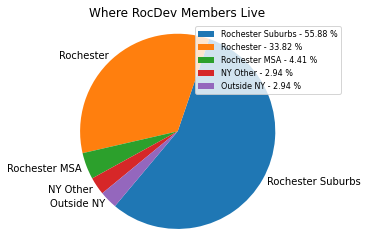

<Figure size 1200x1200 with 0 Axes>

In [8]:
# display(SVG(filename="../2020/figures/domicile.svg")) # Uncomment to compare with 2020
mmpie(data, "domicile", "Where RocDev Members Live", 230, "upper right", ["Rochester Suburbs", "Rochester", "Rochester MSA", "NY Other", "Outside NY"])

Most people who responded to the survey are primarily software developers (67%), but quite a few also work in adjacent areas.  This includes 9% each for those who work in DevOps and Testing, with most of the remainder composed of management (6%) and IT/Support (3%).  These numbers are slightly less heavily weighted towards software developers as compared with last year.

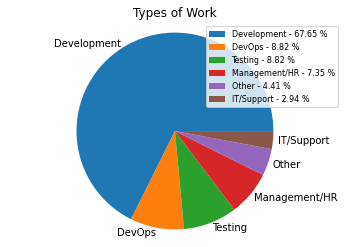

<Figure size 1200x1200 with 0 Axes>

In [9]:
# display(SVG(filename="../2020/figures/job_role.svg")) # Uncomment to compare with 2020
mmpie(data, "job_role", "Types of Work", 0, "upper right", ["Development", "DevOps", "Testing", "Management/HR", "Other", "IT/Support"])

Most respondents (73%) have a bachelors' degree, and a sizable fraction (16%) have graduate degrees.

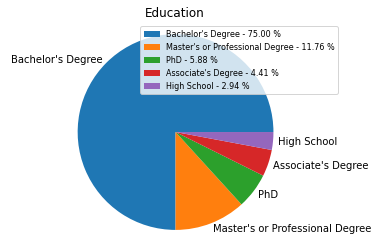

<Figure size 1200x1200 with 0 Axes>

In [10]:
mmpie(data, "education", "Education", 0, "upper right", [])

The average RocDev participant has around 13 years of experience in the industry.
There's also a "long tail" of people with considerably more experience.

In [11]:
data['tech_tenure'].mean()

13.621212121212121

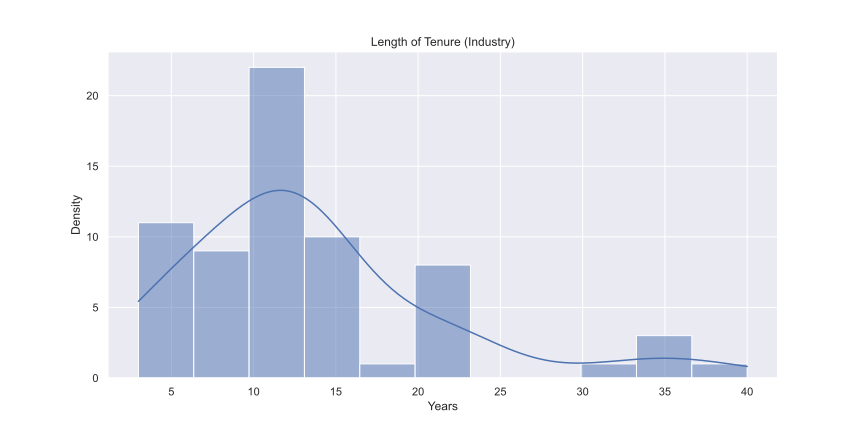

In [12]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(data, x="tech_tenure", kde=True)
plot.set(
    xlabel="Years",
    ylabel="Density",
    title="Length of Tenure (Industry)"
)
fn = "figures/tech_tenure.svg"
plot.get_figure().savefig(fn)
plt.close('all')
display(SVG(fn))

Participants in RocDev are predominately white and male.  This is roughly consistent with the broader demographic trends in software development overall, given the demographic composition of the greater Rochester area and the inherent uncertainty with small sample sizes.

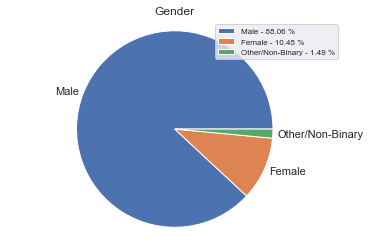

<Figure size 1200x1200 with 0 Axes>

In [13]:
mmpie(data, "gender", "Gender", 0, "upper right", [])

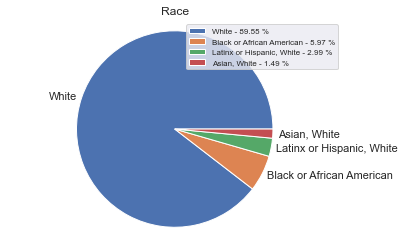

<Figure size 1200x1200 with 0 Axes>

In [14]:
mmpie(data, "race", "Race", 0, "upper right", [])

Other demographic variables of interest were the proportion of RocDev participants who (1) are parents (or expecting), (2) have some mental or physical disability, (3) identify as an LGBT person, or (4) are non-citizens.

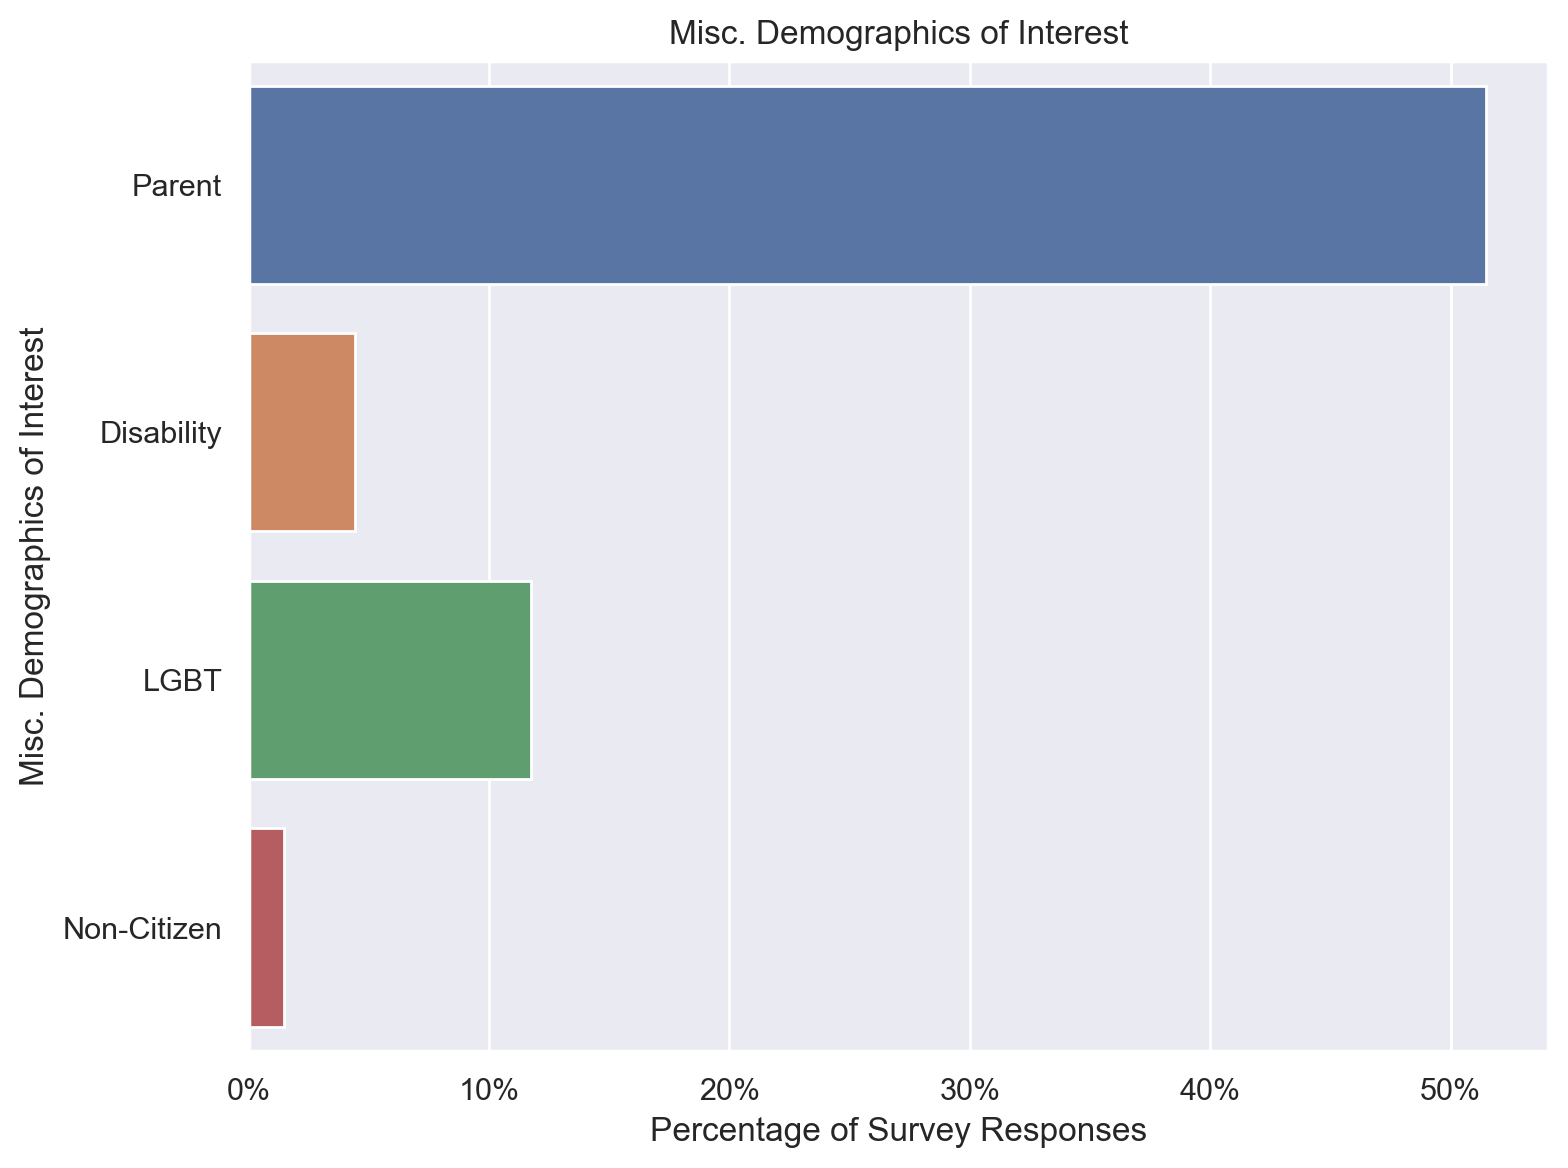

In [15]:
misc_labels = [
    "Parent",
    "Disability",
    "LGBT",
    "Non-Citizen",
]
misc_percentages = [
    data['misc_parent'].mean() * 100,
    data['misc_disability'].mean() * 100,
    data['misc_lgbt'].mean() * 100,
    data['misc_foreigner'].mean() * 100,
]
misc_df = pd.DataFrame({'Misc': misc_labels, 'Percentage':misc_percentages })

plt.figure(figsize=(8,6), dpi=200)
plot = sns.barplot(y="Misc", x="Percentage", data=misc_df)
plot.xaxis.set_major_formatter(mtick.PercentFormatter())
plot.set(
    xlabel="Percentage of Survey Responses",
    ylabel="Misc. Demographics of Interest",
    title="Misc. Demographics of Interest"
)
plt.tight_layout()
fn = "figures/misc.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close()

# About Employers and Jobs
Employers are roughly split between those that are primarily located in Rochester
and those that are primarily located elsewhere.  This is likely to have some overlap
with the portion of people do primarily do remote / telecommuting work.

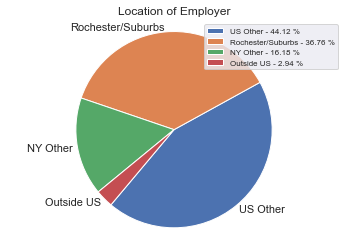

<Figure size 1200x1200 with 0 Axes>

In [16]:
mmpie(data, "org_where", "Location of Employer", 230, "upper right", ["US Other", "Rochester/Suburbs", "NY Other", "Outside US"])

The size of companies that RocDev participants work for varies considerably.  Note that the plot below uses a logarithmic scale, and has a bimodal distribution with the first mode around 50 employees and the second around 13,000 employees.

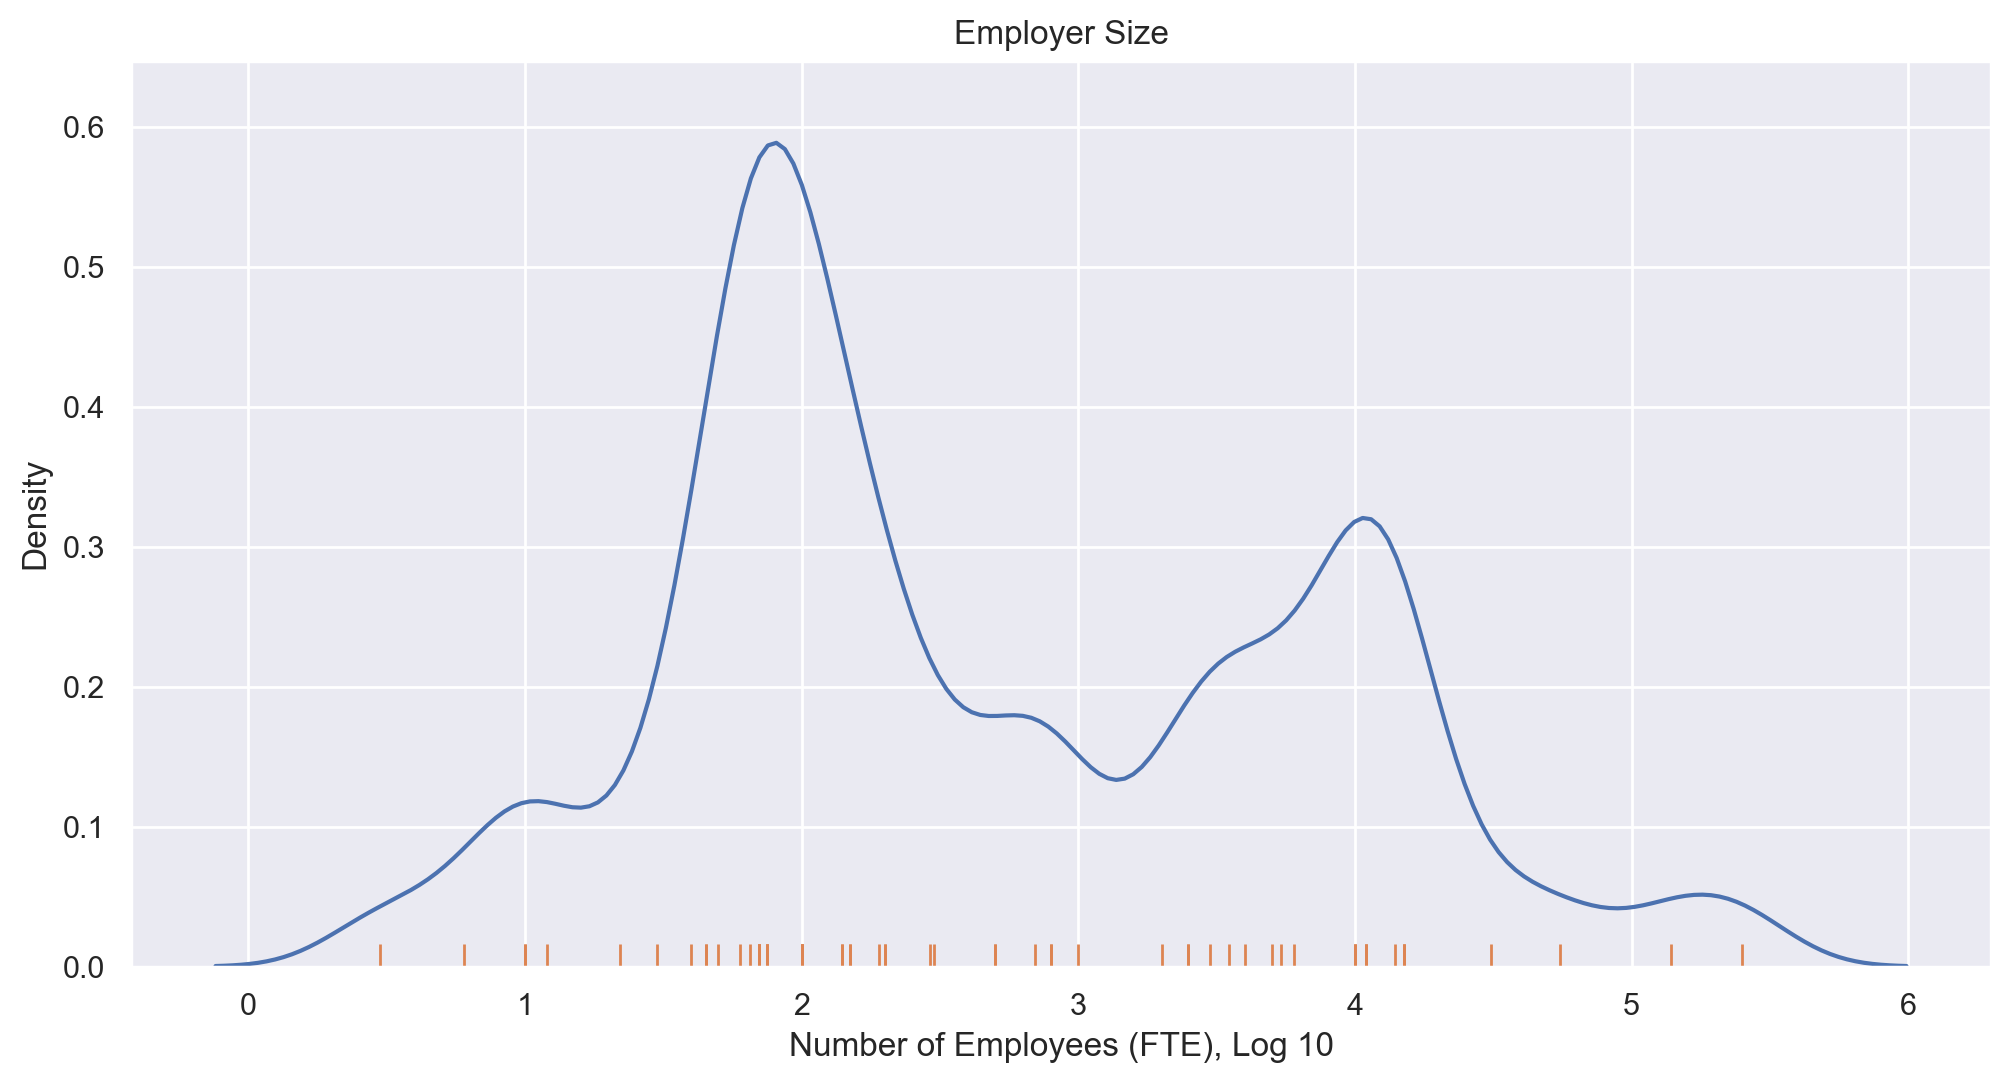

In [17]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.kdeplot(data['log_org_size'].dropna(), bw_adjust=0.4)
sns.rugplot(data=data, x="log_org_size")
plot.set(
    xlabel="Number of Employees (FTE), Log 10",
    ylabel="Density",
    title="Employer Size"
)
fn = "figures/org_size.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')

Unsurprisingly, the vast majority of respondents work in the private sector.  The ratio of people working for small, privately-held companies to publicly traded companies was a little more than 2:1.

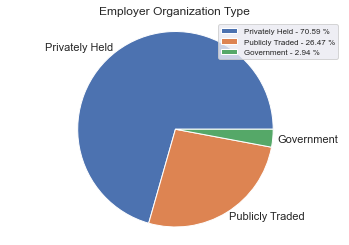

<Figure size 1200x1200 with 0 Axes>

In [18]:
mmpie(data, "org_type", "Employer Organization Type", 0, 'upper right', ["Privately Held", "Publicly Traded", "Government"])

The large majority of respondents were employed directly, rather than through
contracting agencies.

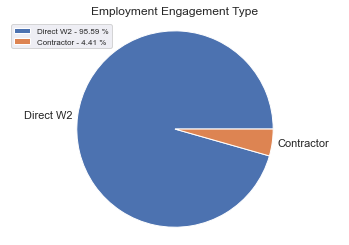

<Figure size 1200x1200 with 0 Axes>

In [19]:
mmpie(data, "job_type", "Employment Engagement Type", 0, 'upper left', ["Direct W2", "Contractor"])

This year, 17% of respondents have direct reports, which is a bit higher than was reported last year (~10%).

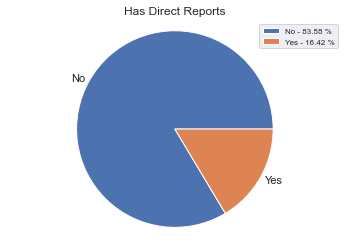

<Figure size 1200x1200 with 0 Axes>

In [20]:
mmpie(data, "job_supervisor", "Has Direct Reports", 0, "upper right", [])

A considerable portion (23%) also have some kind of second job or are involved in side projects in addition to their primary employment.

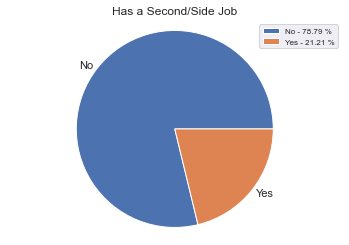

<Figure size 1200x1200 with 0 Axes>

In [21]:
mmpie(data, "side_job", "Has a Second/Side Job", 0, "upper right", [])

Another interesting aspect of the technology industry is the relatively short length of time that people will stay in the same job before moving on. Across _all_ respondents, the average amount of time in a job was around 3.4 years.  However, it's also important to note that the distribution has some right skew, so the more typical length of time people stay in the same job is closer to 2.5 years.

The 2021 distribution was similar to that in 2020.

In [22]:
data['job_avg_tenure'].mean()

3.165199615199616

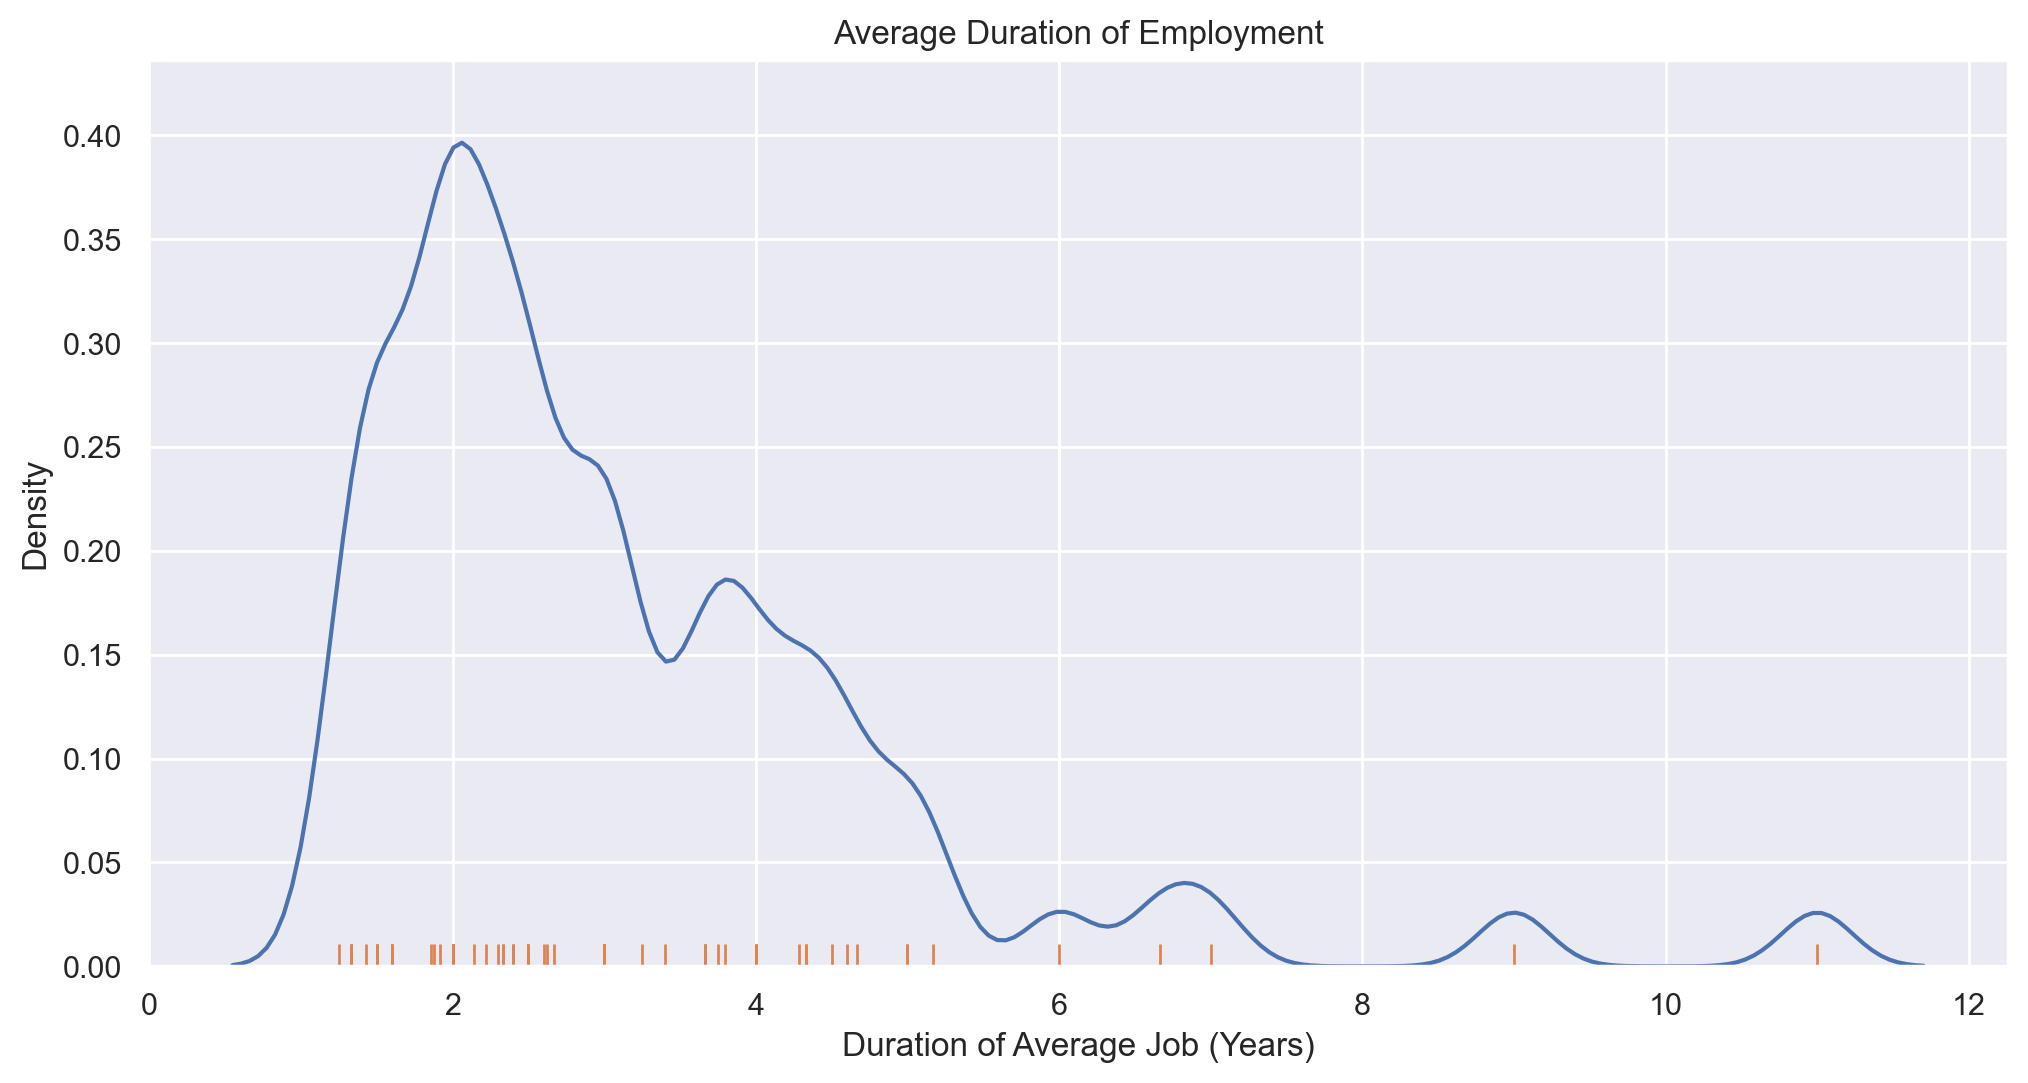

In [23]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.kdeplot(data['job_avg_tenure'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="job_avg_tenure")
plot.set(
    xlabel="Duration of Average Job (Years)",
    ylabel="Density",
    title="Average Duration of Employment"
)
fn = "figures/job_avg_tenure.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))
# display(SVG("../2020/figures/job_avg_tenure.svg")) # Uncomment to compare with 2020

The substantial majority of respondents reported working standard 40-hour weeks, while the remainder skewed towards slightly longer weeks.

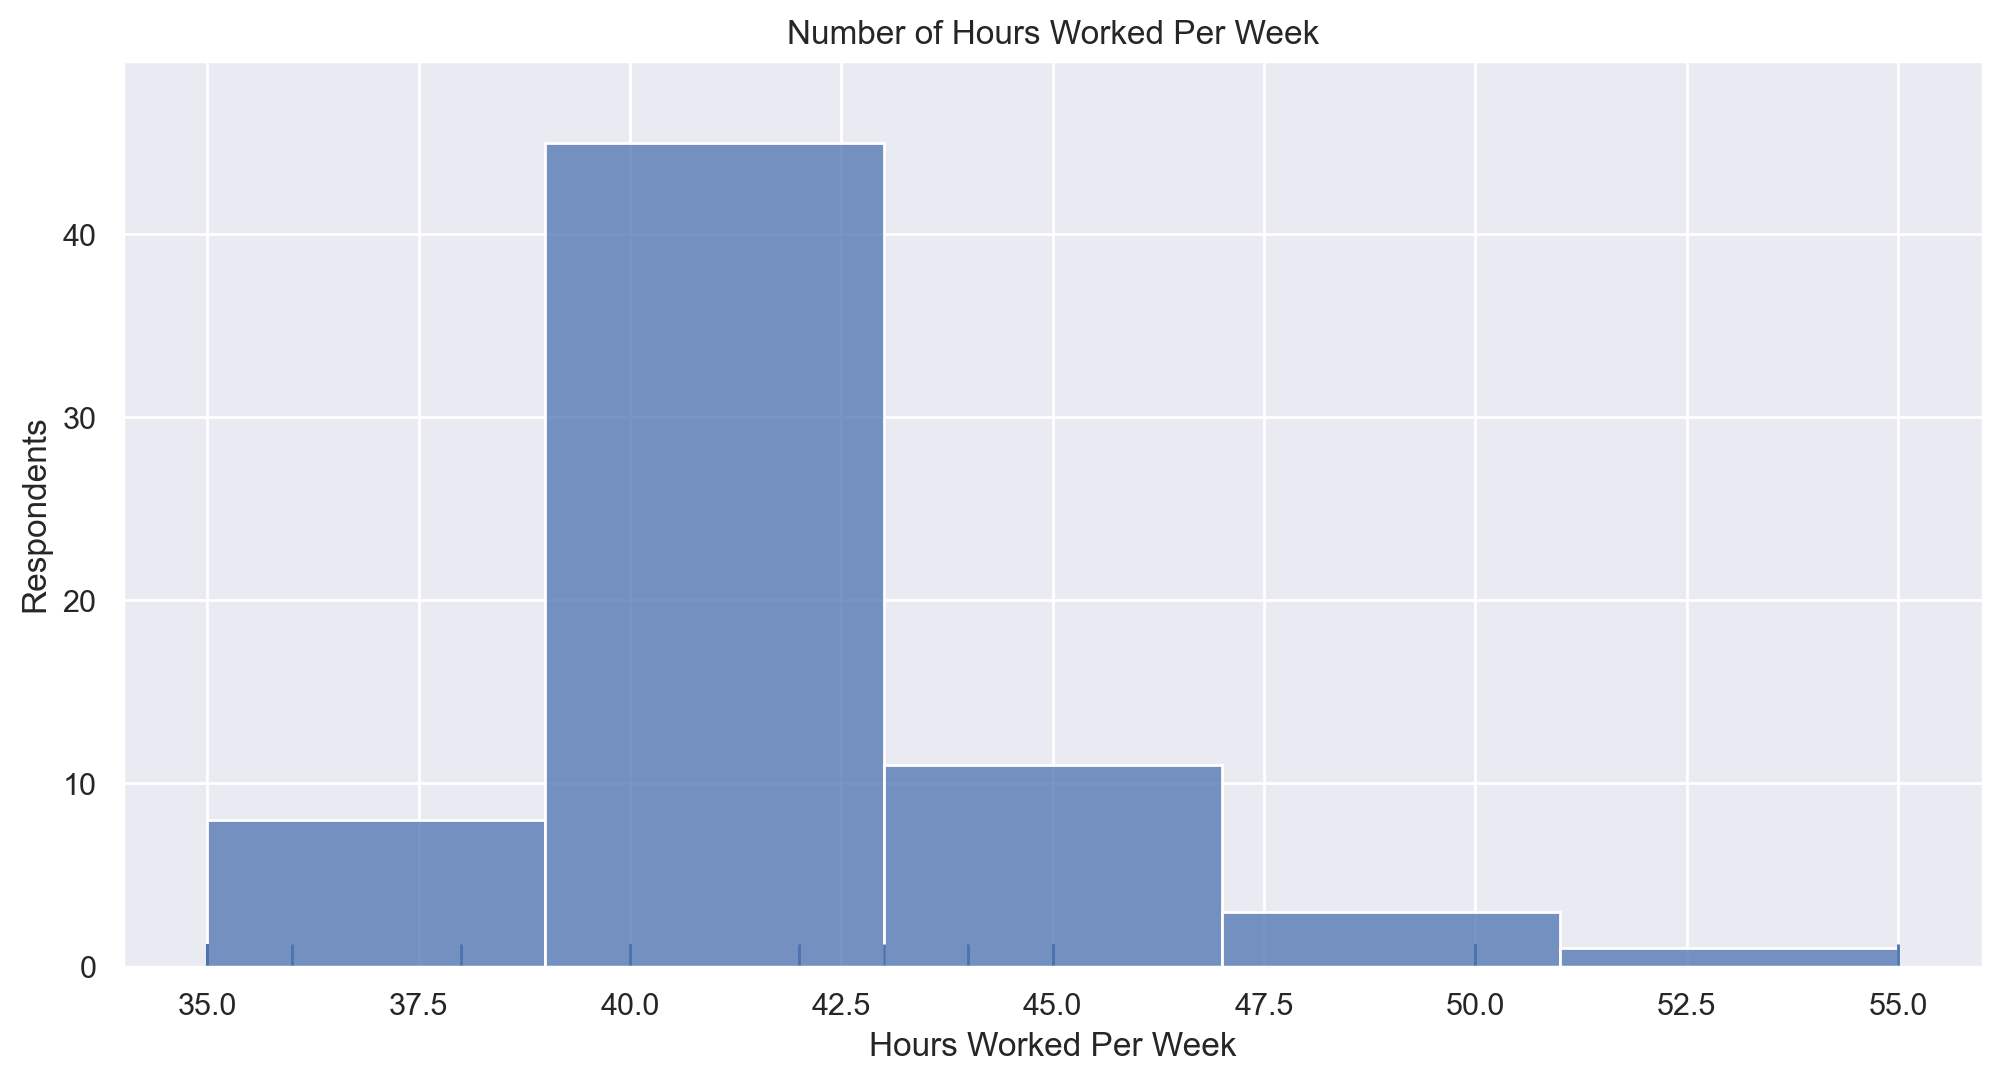

In [42]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "job_hours", bins=5, data=data)
# plot = sns.kdeplot(data['job_hours'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="job_hours")

plot.set(
    xlabel="Hours Worked Per Week",
    ylabel="Respondents",
    title="Number of Hours Worked Per Week"
)
fn = "figures/job_hours.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))

# Compensation

The average annual salary reported this year was 140,000, up significantly (15%) from 122,000 in 2020.

In [25]:
data['job_pay'].describe()

count     68.000000
mean     139.505882
std       46.129143
min       65.000000
25%      111.500000
50%      130.000000
75%      160.500000
max      315.000000
Name: job_pay, dtype: float64

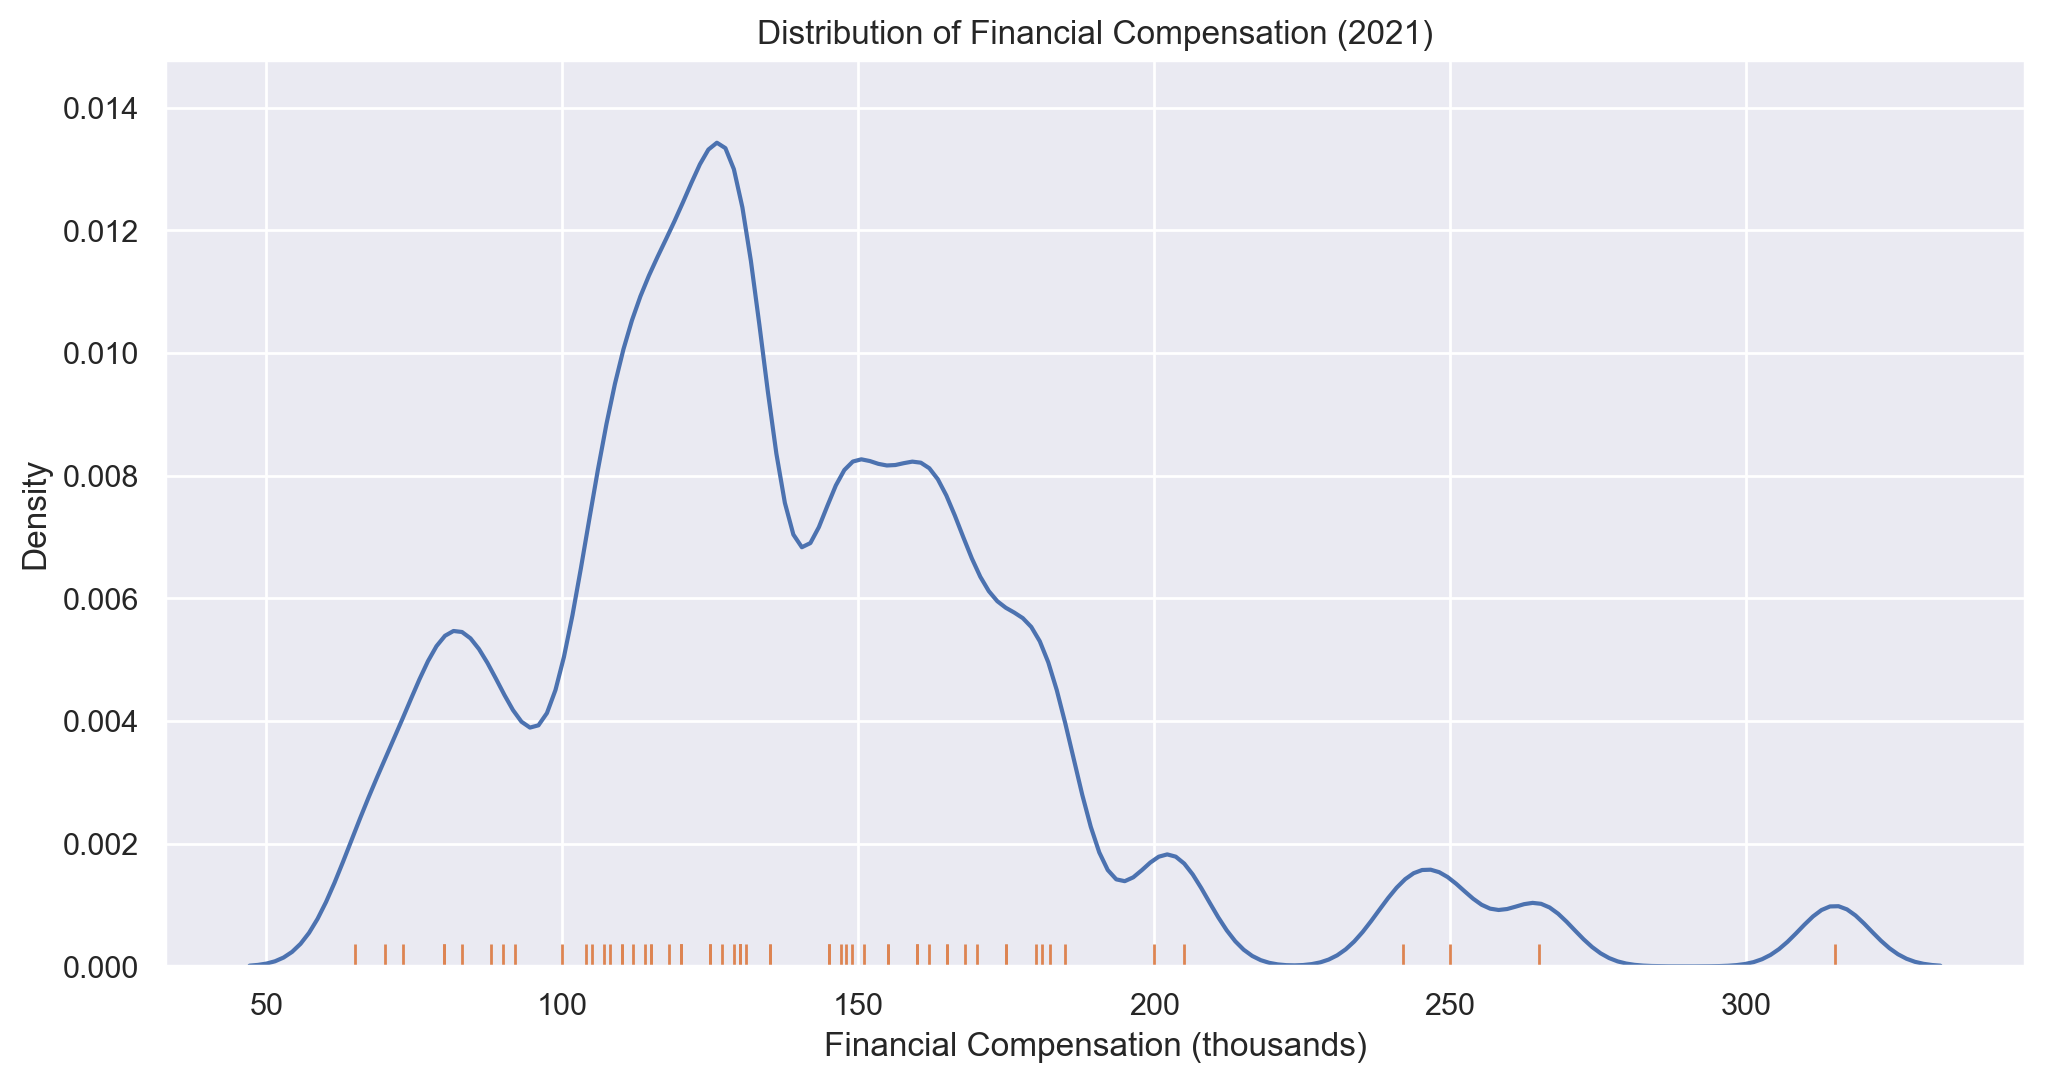

In [26]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.kdeplot(data['job_pay'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="job_pay")
plot.set(
    xlabel="Financial Compensation (thousands)",
    ylabel="Density",
    title="Distribution of Financial Compensation (2021)"
)
fn = "figures/job_pay.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))
# display(SVG("../2020/figures/job_pay.svg")) # uncomment for comparison with 2020
# display(SVG("../2019/figures/compensation.svg")) # uncomment for comparison with 2020

One of the things we're interested in this year is how average compensation has changed from previous years.

In [27]:
# Comparison with Previous Years
data2019 = pd.read_csv("../2019/2019.csv")
data2019.columns = [
    'consent_1', # important for data consent, irrelevant for analysis
    'extra', # Too sparse for stats
    'consent_2', # important for data consent, irrelevant for analysis
    'job_title', # Too sparse for stats
    'job_role', # Too sparse for stats
    'benefits_salary',
    'benefits_salary_year',
    'benefits_paid_vac_days', # many erroneous values (365)
    'benefits_bonus',
    'job_reports',
    'job_type',
    'employer_dept', # Too sparse for stats
    'employer_ownership',  # Shortened names
    'employer_fte', # Too few data points per category; not
    'loc', # Not enough diversity for stats
    'experience', # good spread
    'job_remote', # binary
    'employer_loc', # Not enough data for anything but ROC/Other
    'benefits_other', # Too sparse for stats
    'gender',
    'education',
    'identity', # multiple y/n variables requires further parsing, data sparse except for parents
    'race',
    'universities',  # Too sparse for useful stats
    'job_description',  # Too sparse for useful stats
    'job_tenure',
    'outside_income']

data2019['benefits_salary'] = data2019['benefits_salary'].replace('[\$,]', '', regex=True).astype(float)
data2019['benefits_bonus'] = data2019['benefits_bonus'].replace('[\$,]', '', regex=True).astype(float)
bonus = data2019['benefits_bonus'].to_numpy()
bonus_nas = np.isnan(data2019['benefits_bonus'])
bonus[bonus_nas] = 0
data2019['job_income'] = data2019['benefits_salary'].to_numpy() + bonus
data2019['job_pay'] = data2019['job_income'] / 1000
data2019['Year'] = pd.Series([2019 for x in range(len(data2019.index))])

data2020 = pd.read_csv("../2020/2020-cleaned.csv")
data2020.columns = [
    'timestamp', # When the survey was completed (from Google Forms)
    'consent', # important for data consent, irrelevant for analysis
    'org_type', # Public, private, or self-employed?
    'job_type', # Regular (i.e., W-2) employee or contractor?
    'org_size', # Approximately how many people work for your employer worldwide?
    'org_where', # Where is your employer located?
    'job_title', # What is your official job title?
    'job_role', # which of the following best describes your role?
    'job_description', # Please write a short description of what you do.
    'job_tenure', # How many years have you been with your current employer?
    'job_supervisor', # Do people report directly to you?
    'job_remote', # Did you work remotely (Pre-COVID)?
    'side_job', # Do you have a second job or side business?
    'tech_tenure', # How many years have you worked in the technology industry?
    'tech_jobs', # How many different jobs have you had in that time?
    'job_pay', # What is your approximate annual salary (in thousands) including bonuses?
    'job_when_negotiated', # What year was your current pay set?
    'job_hours', # How many yours do you work in an average week?
    'job_benefits', # What other kinds of compensation and benefits does your employer provide?
    'job_vacation', # If your employer offers paid vacation, how many paid days off per year?
    'side_job_pay', # If you have a second job or do outside contract work, approx. how much do you make on the side?
    'covid_actions', # What action(s) did your employer(s) take in response to COVID?
    'covid_return', # If you work(ed) remotely in response to COVID, when do you expect to be "back in the office?"
    'covid_satisfied', # How satisfied are you with your employer's response to the COVID-19 pandemic?
    'covid_changes', # Which of the following describe your personal experience with employment and COVID-19?
    'domicile', # Where do you live?  (Multiple choice general areas)
    'education', # What is the highest degree you have received?
    'school', # At which School/University did you receive this degree?
    'gender', # Gender
    'race', # Race
    'misc', # Do you identify with any of the following?
    'comments' # Do you have anything else to add?
]
data2020['Year'] = pd.Series([2020 for x in range(len(data2020.index))])

data2021 = data.copy()
data2021['Year'] = pd.Series([2021 for x in range(len(data2021.index))])
ts = [data2019[['job_pay', 'Year']], data2020[['job_pay', 'Year']], data2021[['job_pay', 'Year']]]
ts = pd.concat(ts)
ts['Year'] = ts['Year'].astype('category')



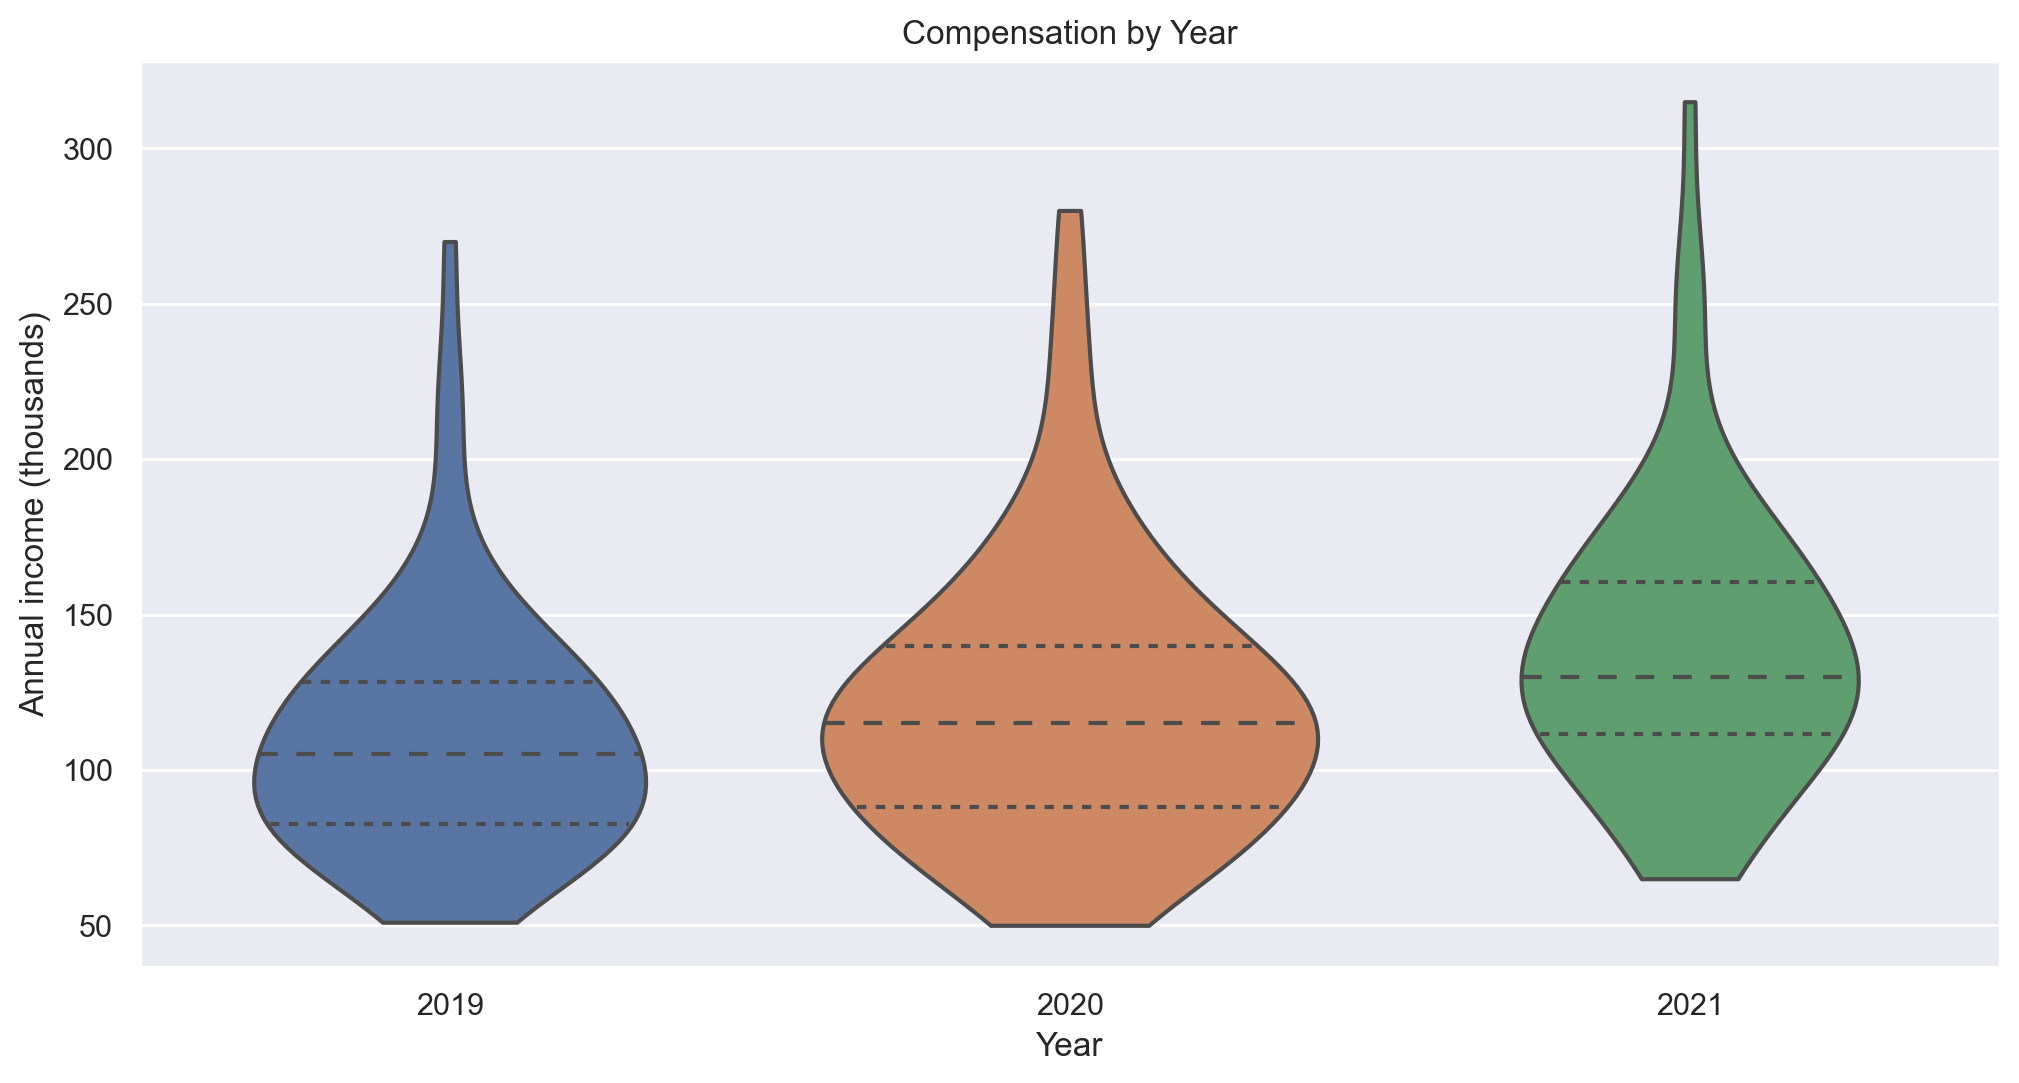

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     8.250
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000341
Time:                        21:56:07   Log-Likelihood:                -1281.1
No. Observations:                 247   AIC:                             2568.
Df Residuals:                     244   BIC:                             2579.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      110.5128      4.900     22.553   

In [28]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "Year",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    data=ts
)
plot.set(
    xlabel="Year",
    ylabel="Annual income (thousands)",
    title="Compensation by Year"
)
plot.get_figure().savefig("figures/job_pay_vs_year.svg")
plt.show()

model = sm.ols(formula="job_pay ~ Year", data=ts)
result = model.fit();
print(result.summary())

Average income varied based on an individual's level of experience in the technology industry, with salaries increasing by an average of around $2,200 for each additional year of experience.

In [29]:
model = sm.ols(formula="job_pay ~ tech_tenure", data=data)
result = model.fit();
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     8.621
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00461
Time:                        21:56:07   Log-Likelihood:                -340.04
No. Observations:                  66   AIC:                             684.1
Df Residuals:                      64   BIC:                             688.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     112.4031     10.295     10.918      

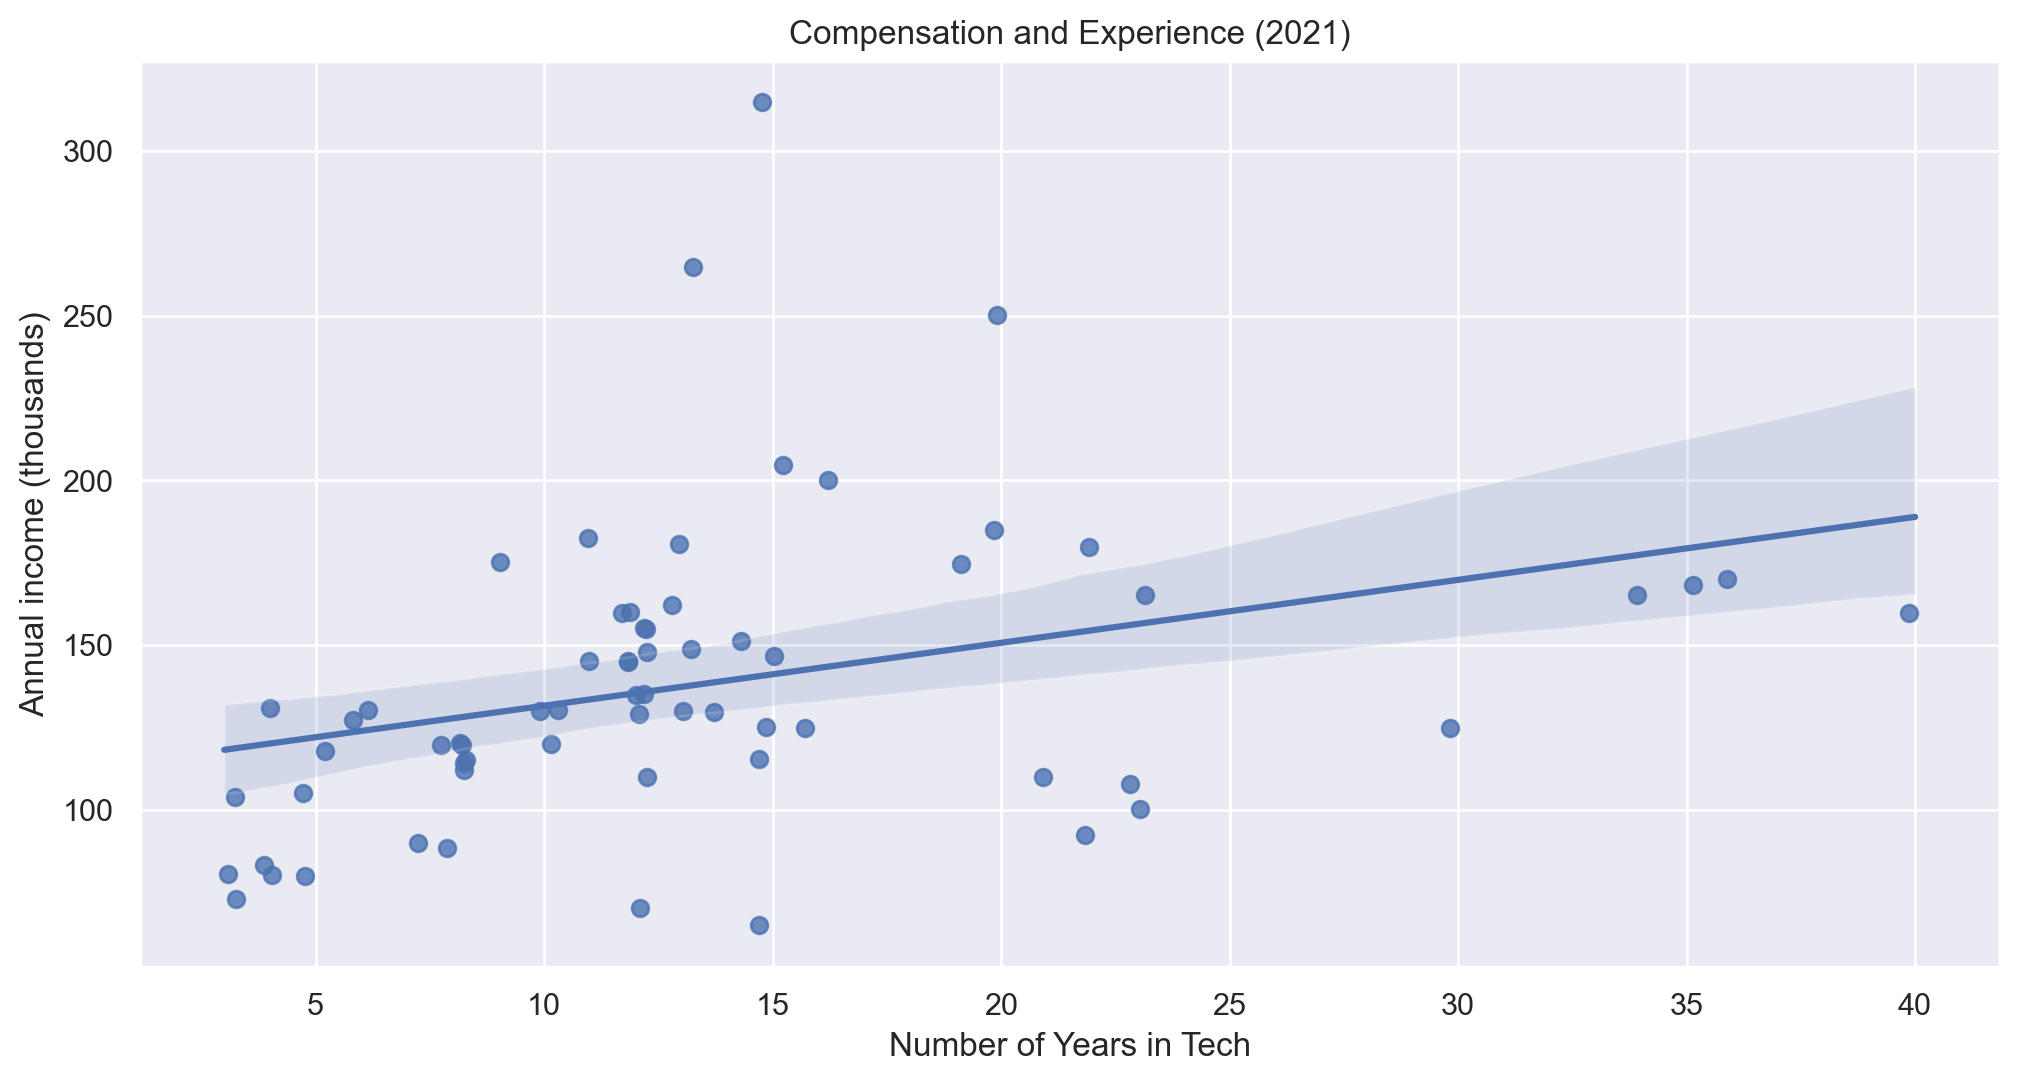

In [30]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.regplot(
    x = "tech_tenure",
    y = "job_pay",
    x_jitter = .3,
    y_jitter = .3,
    data=data)
plot.set(
    xlabel="Number of Years in Tech",
    ylabel="Annual income (thousands)",
    title="Compensation and Experience (2021)"
)
fn = "figures/job_pay_vs_tech_tenure.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))

While visualization of the data shows some apparent differences in the typical
salary across different education levels, the small number of respondents in
most categories and the large variation in salaries overall prevent making
reliable statistical inferences about these differences.

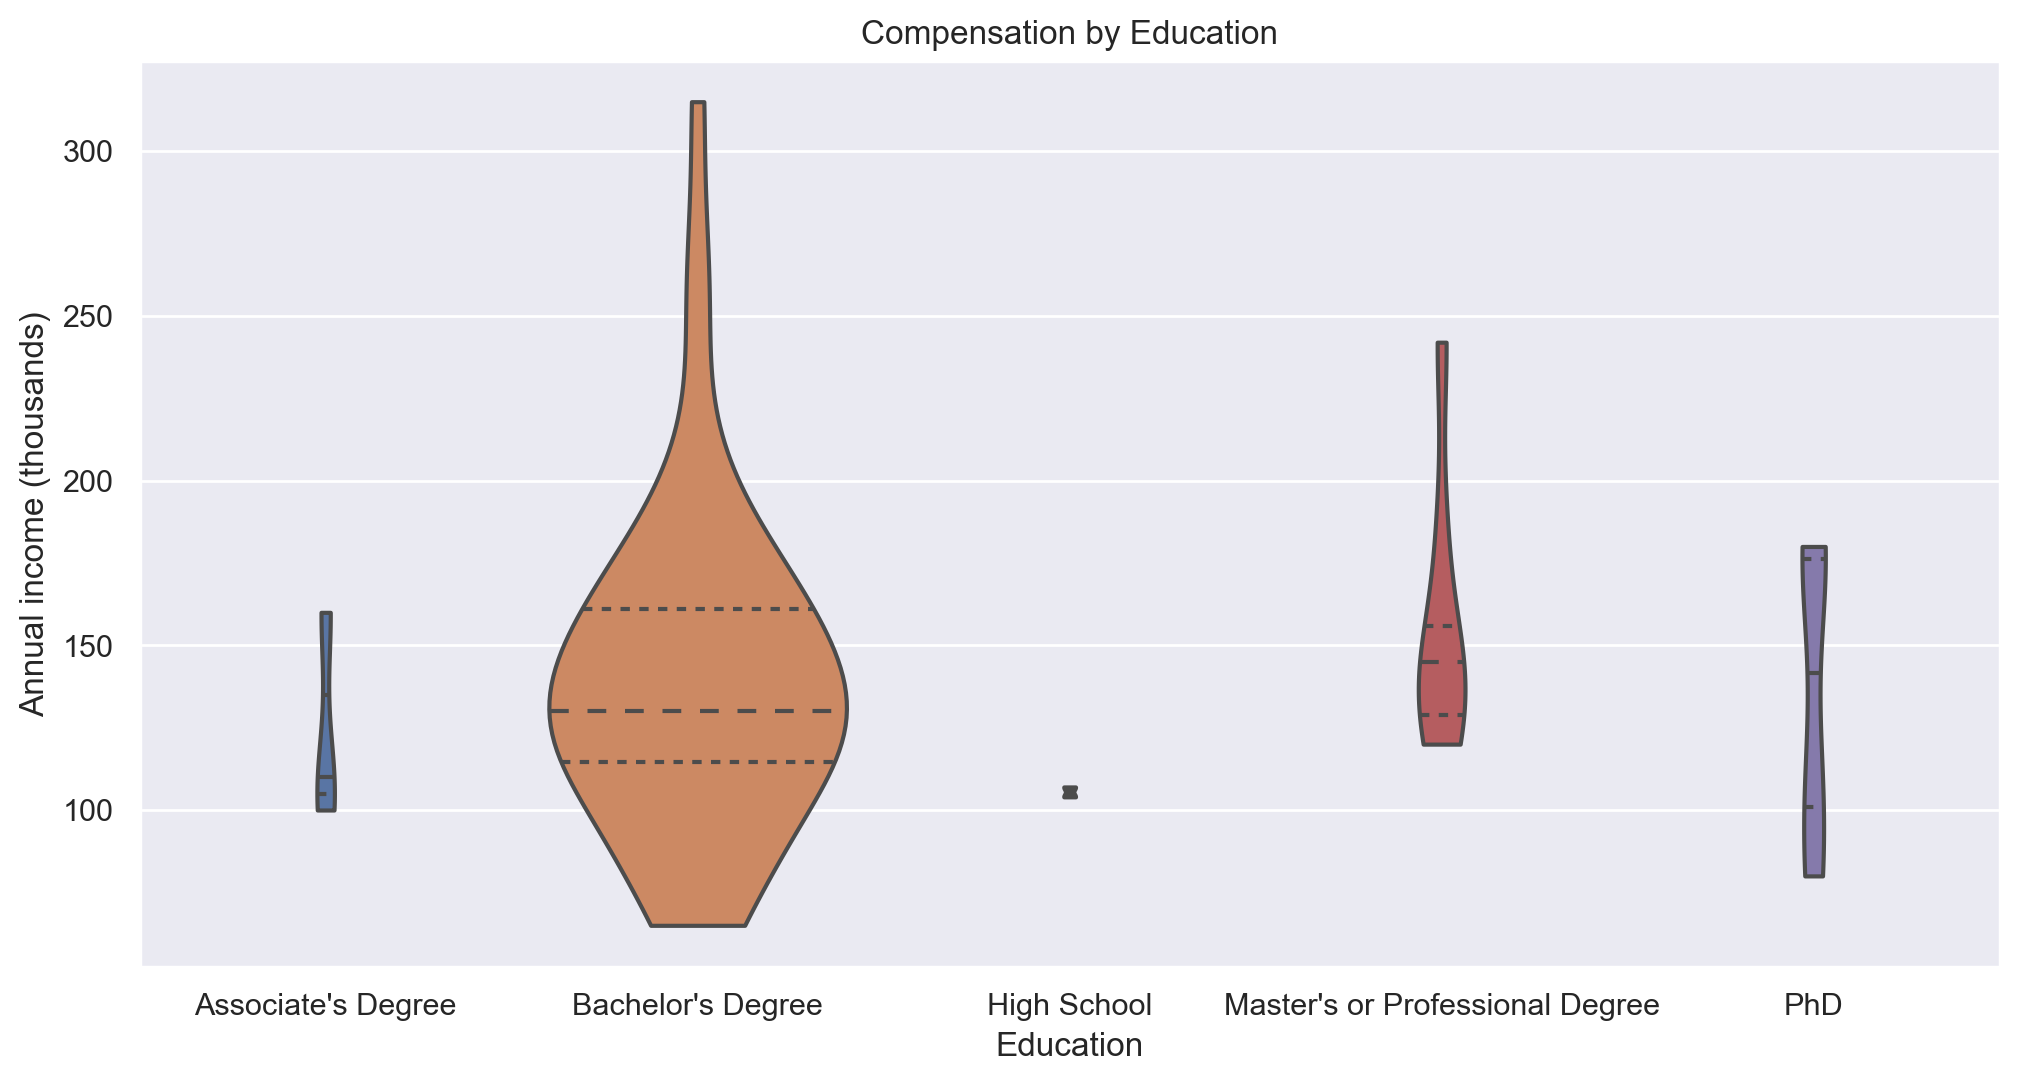

In [31]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "education",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Education",
    ylabel="Annual income (thousands)",
    title="Compensation by Education"
)
fn = "figures/job_pay_vs_education.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close("all")
# display(SVG(fn))


The same is true for comparisons between different types of work.

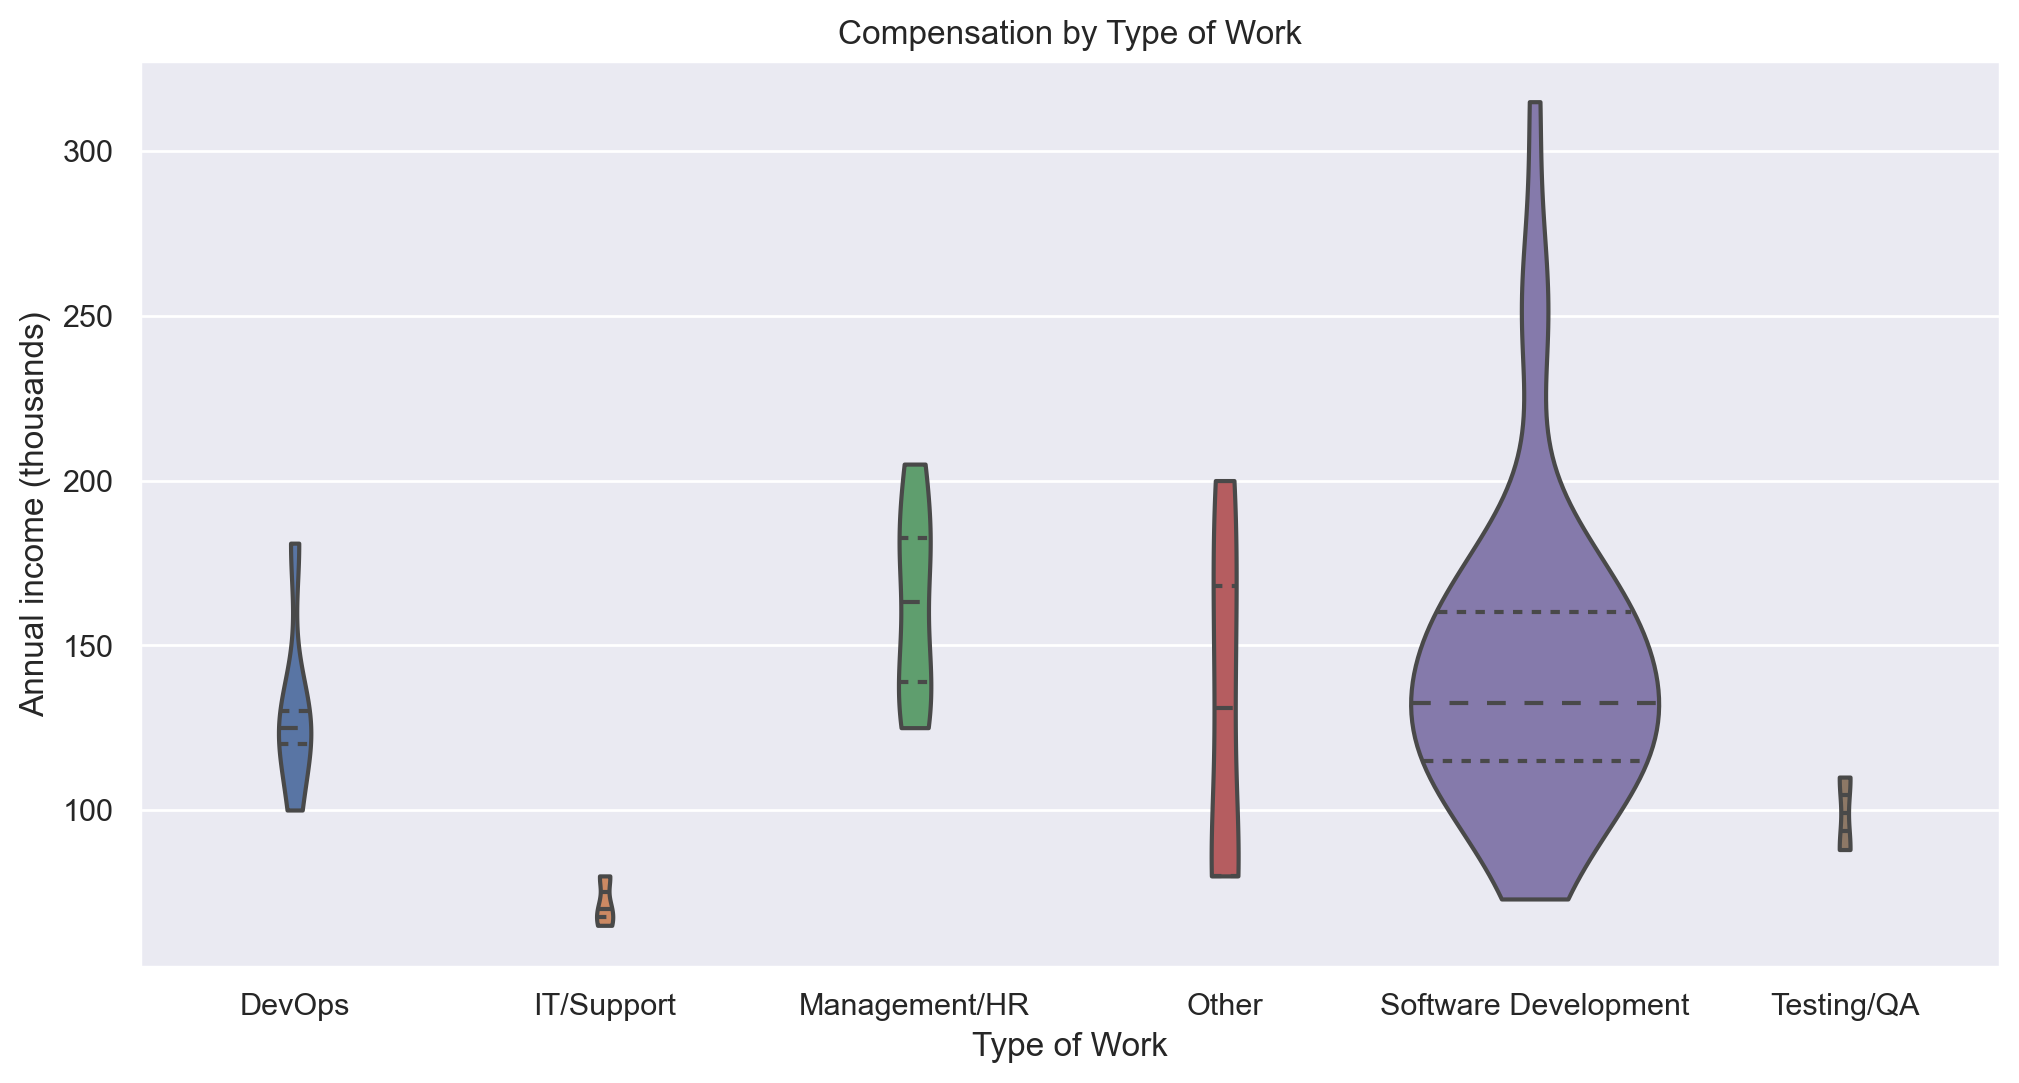

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2.309
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0547
Time:                        21:56:08   Log-Likelihood:                -350.72
No. Observations:                  68   AIC:                             713.4
Df Residuals:                      62   BIC:                             726.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [32]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "job_role",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Type of Work",
    ylabel="Annual income (thousands)",
    title="Compensation by Type of Work"
)
plot.get_figure().savefig("figures/job_pay_vs_job_role.svg")
plt.show()


model = sm.ols(formula="job_pay ~ job_role", data=data)
result = model.fit();
print(result.summary())

However, we can say with some confidence that, on average, remote work
pays more.  The average salary for local jobs was around 102,000, while
the average salary for those working remotely was around 143,000.

If the shift to more remote work persists long-term, this may put upward pressure
on the salaries necessary for local employers to attract and retain technical staff.

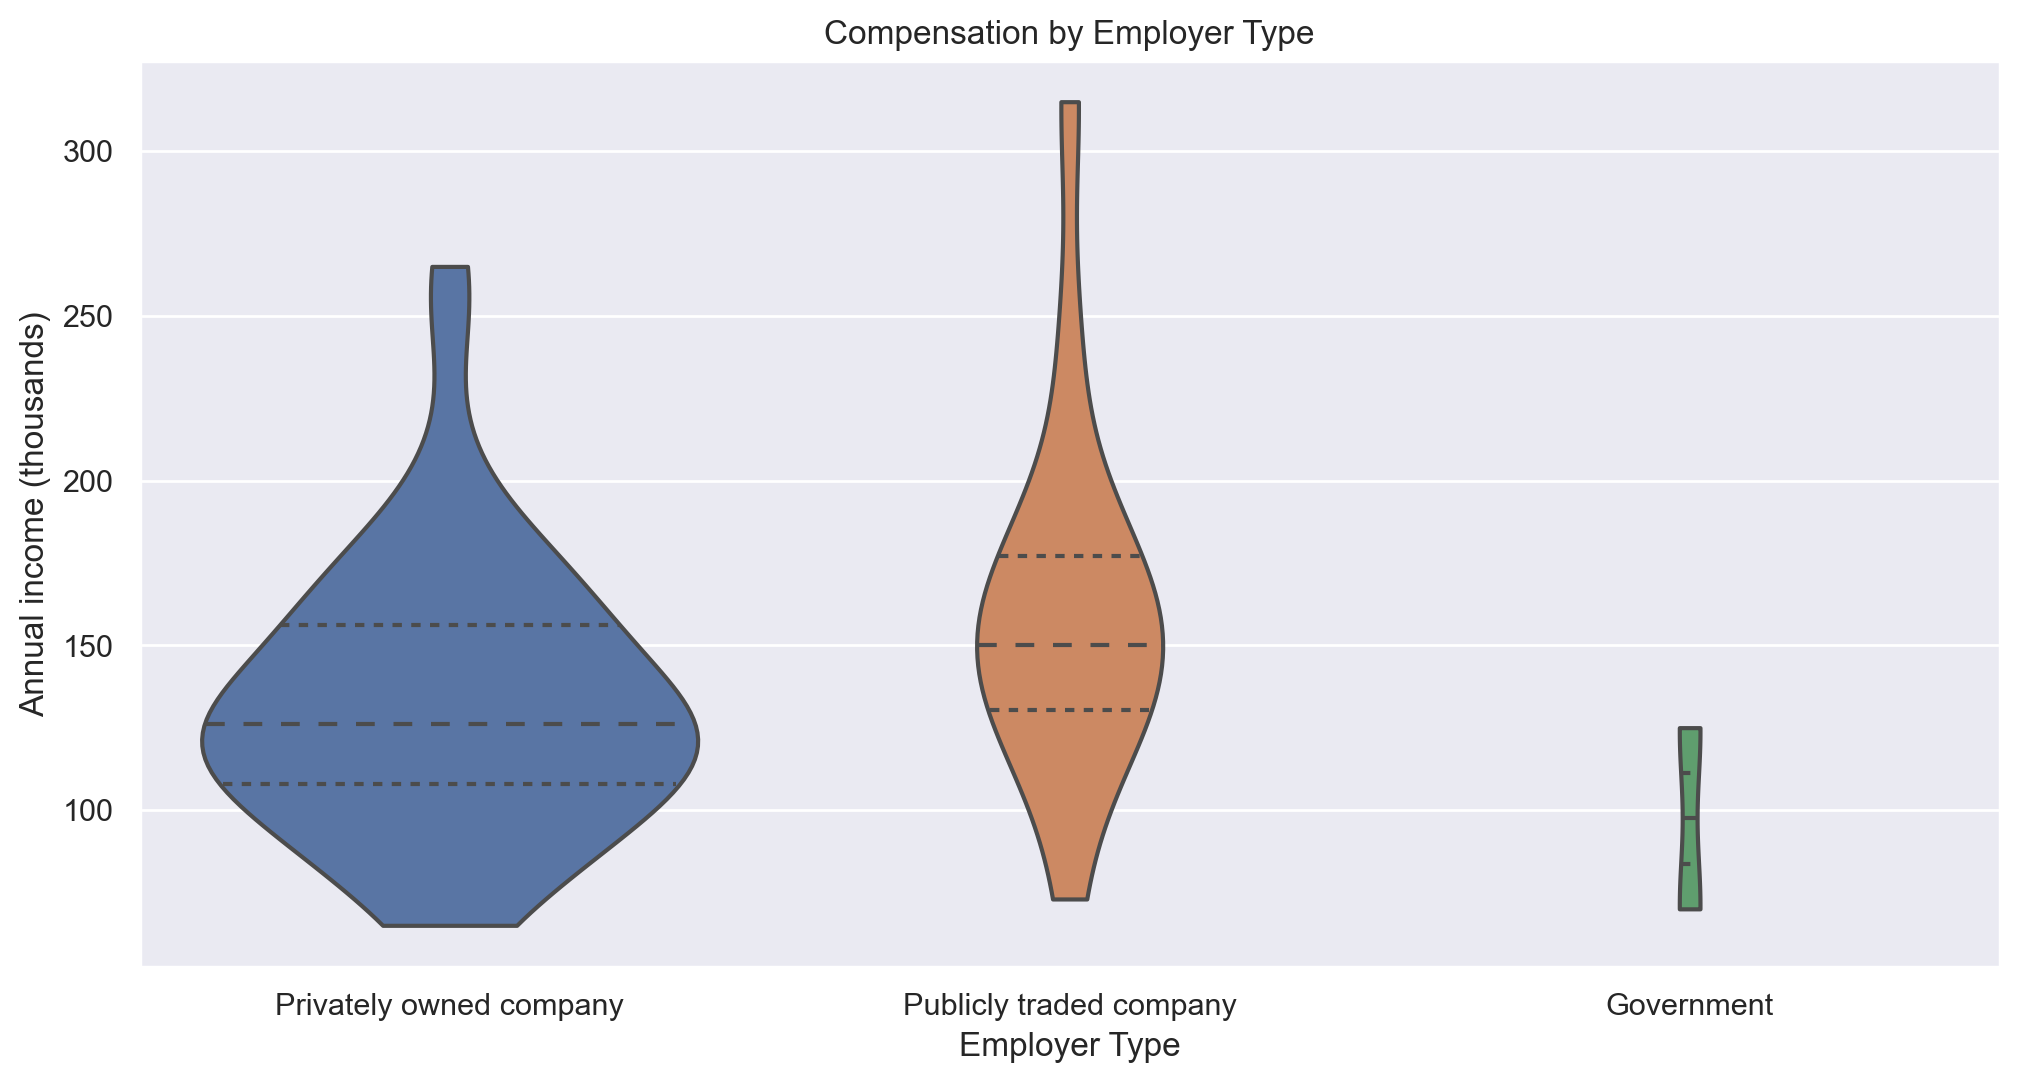

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.502
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0359
Time:                        21:56:08   Log-Likelihood:                -353.04
No. Observations:                  68   AIC:                             712.1
Df Residuals:                      65   BIC:                             718.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [33]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "org_type",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Employer Type",
    ylabel="Annual income (thousands)",
    title="Compensation by Employer Type"
)
plot.get_figure().savefig("figures/job_pay_vs_org_type.svg")
plt.show()

model = sm.ols(formula="job_pay ~ org_type", data=data)
result = model.fit();
print(result.summary())

While larger employers did pay more on average, the difference was small enough as to be not statistically significant.

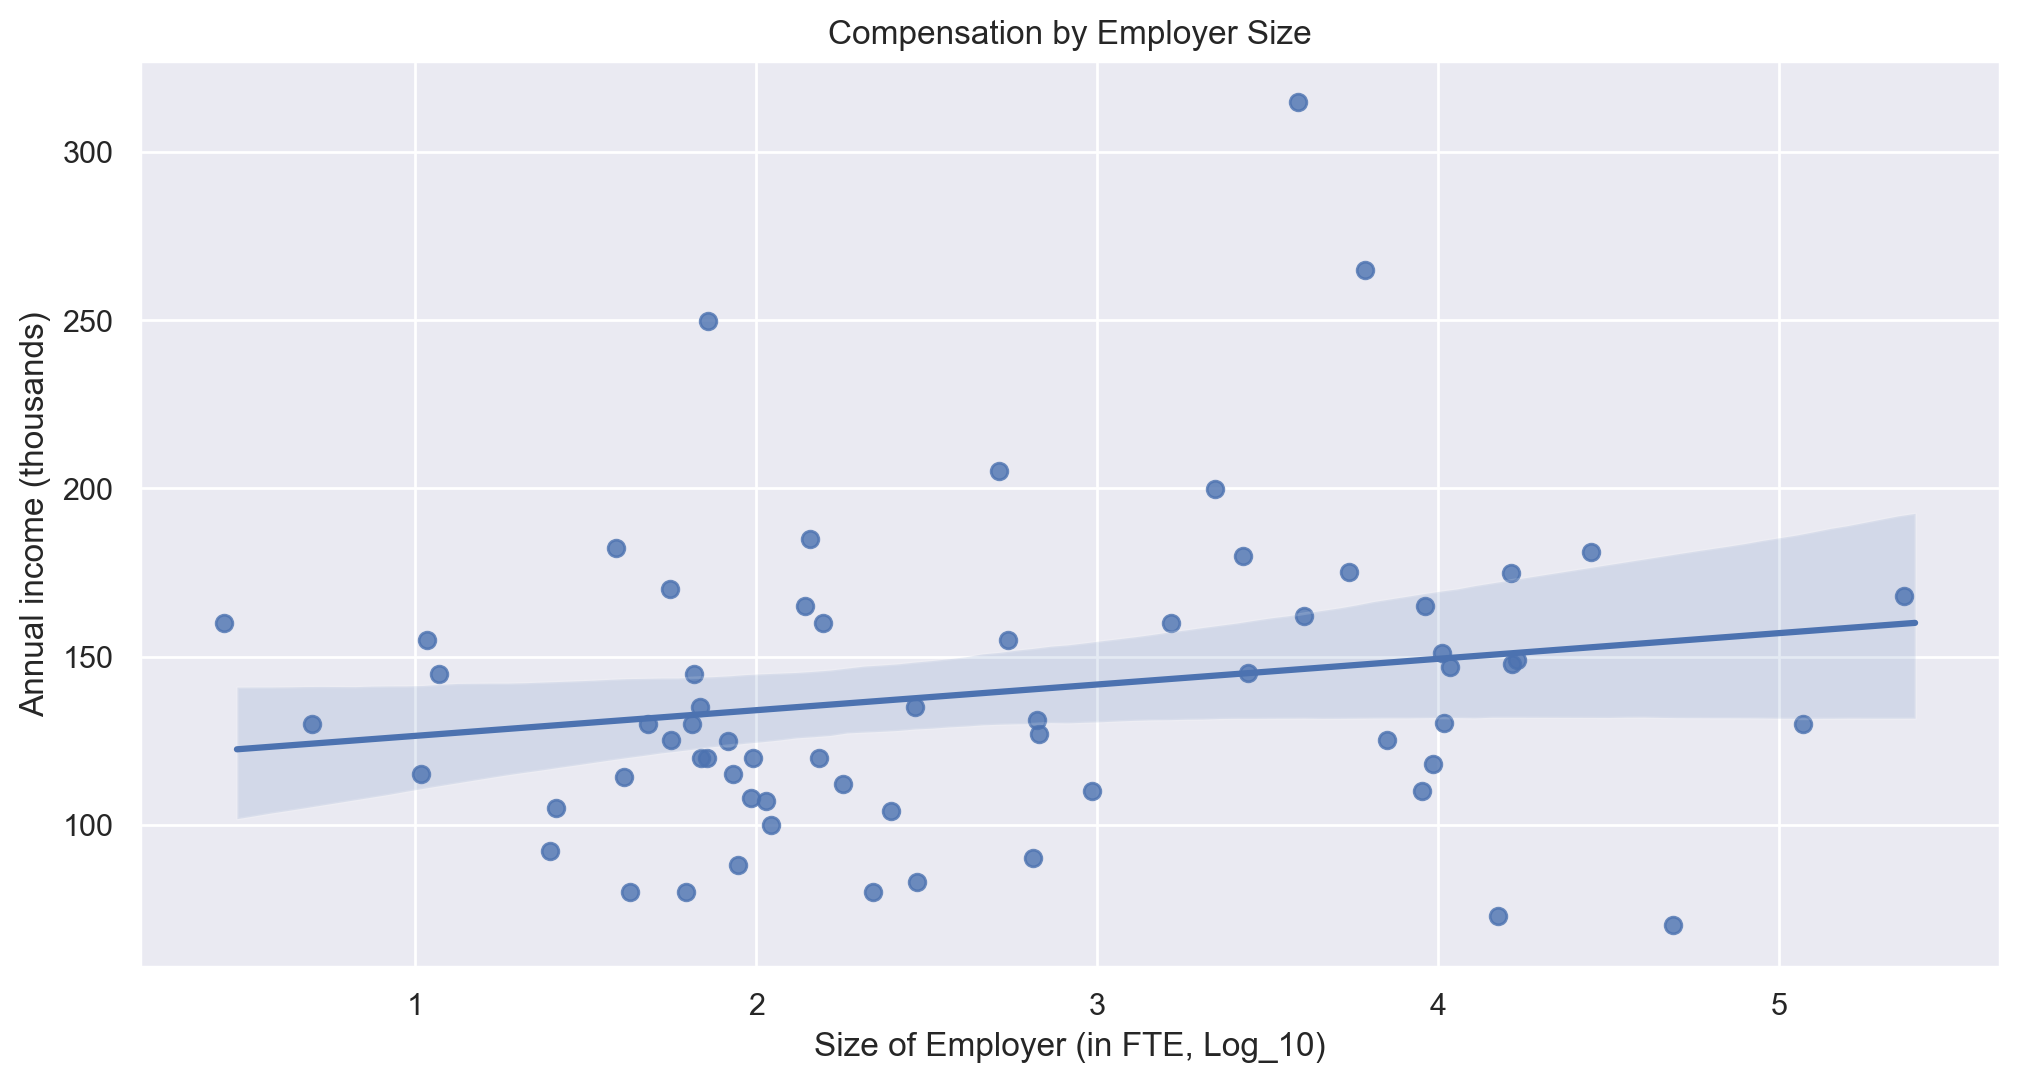

In [34]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.regplot(
    x = "log_org_size",
    y = "job_pay",
    fit_reg=True,
    x_jitter = 0.1,
    y_jitter = 0.1,
    data=data)
plot.set(
    xlabel="Size of Employer (in FTE, Log_10)",
    ylabel="Annual income (thousands)",
    title="Compensation by Employer Size"
)
plot.get_figure().savefig("figures/job_pay_vs_org_size.svg")
plt.show()
plt.close('all')

There is basically no relationship between average salary and the number of hours worked per week.  Overall, the average is 250/yr more per average additional hour, but there's so little correlation that the 95% confidence interval is +/- 3,100.  In part, this is also because there's very little variation--the large majority of respondents work 40 hour weeks.

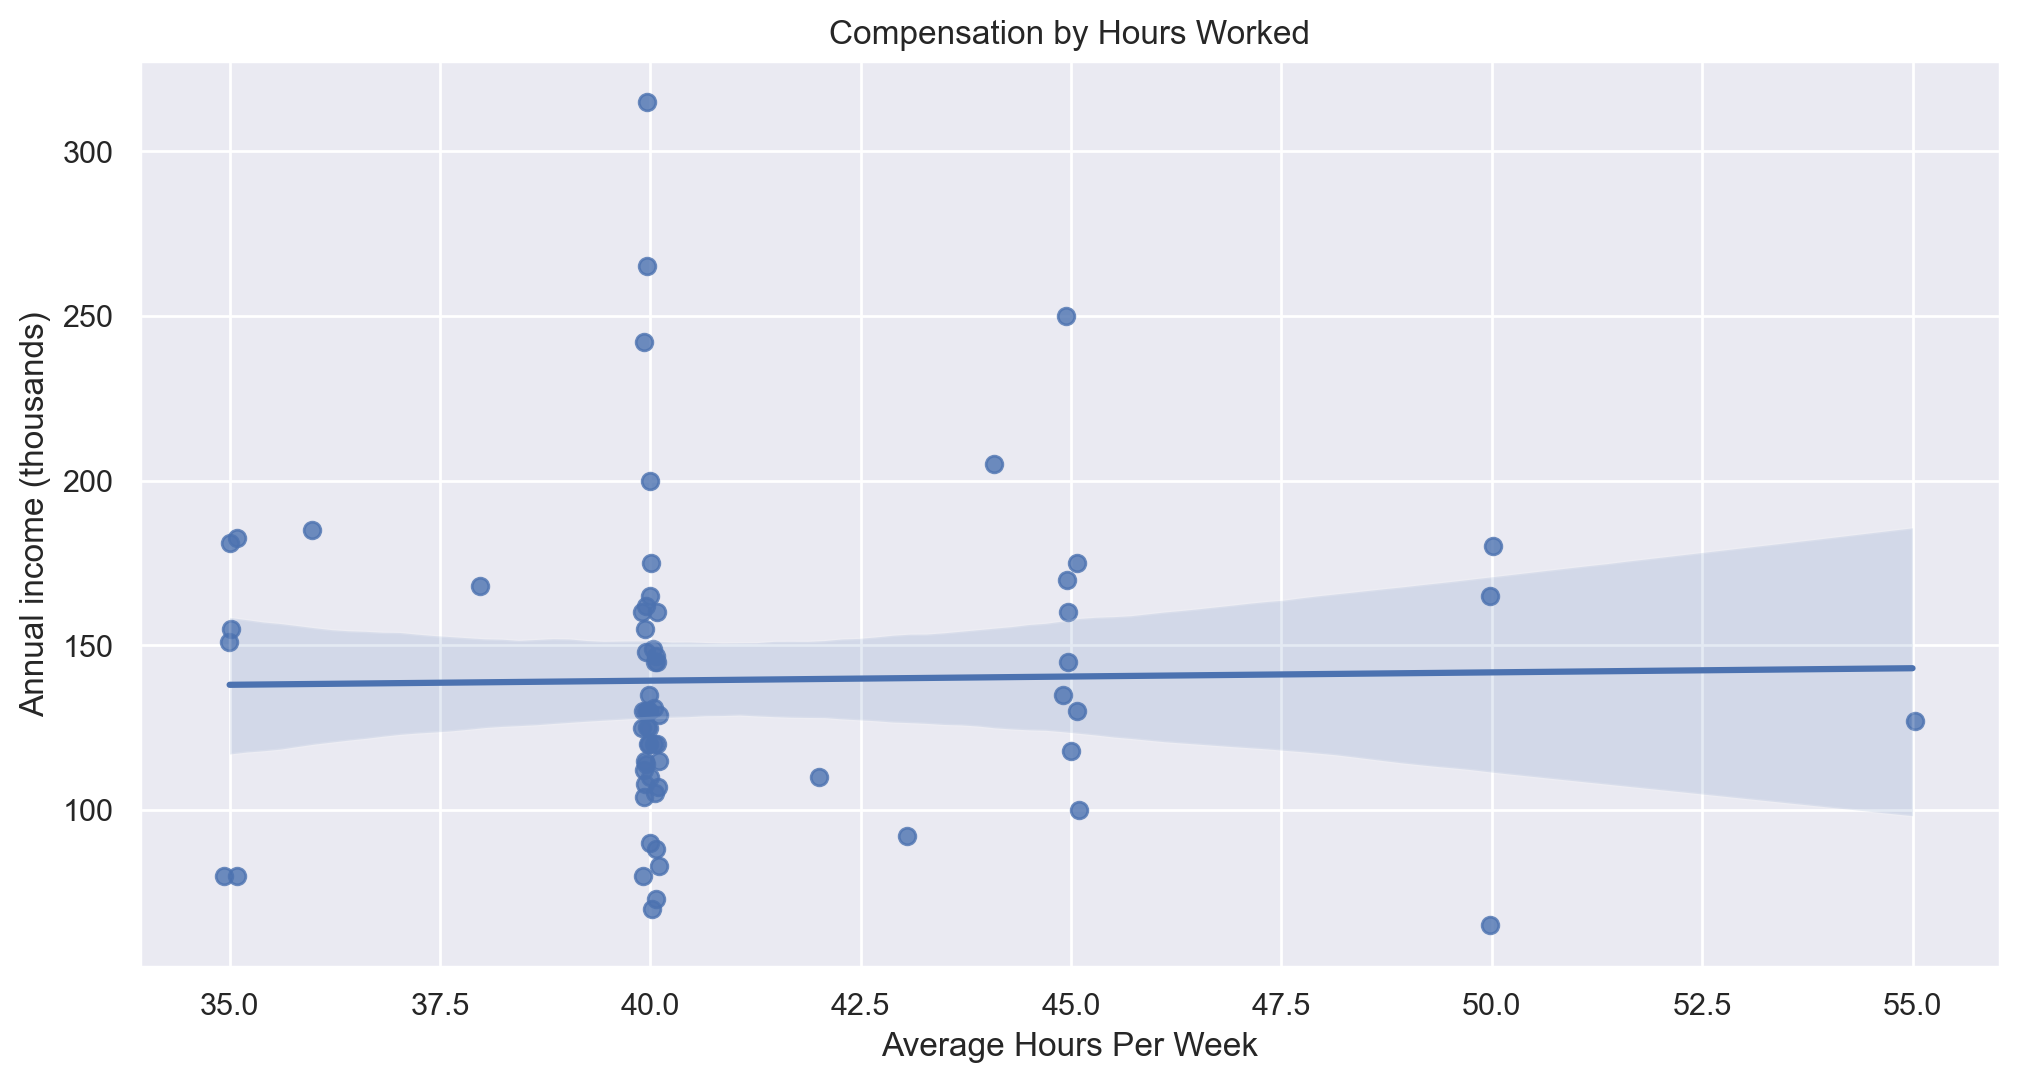

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                   0.02612
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.872
Time:                        22:02:15   Log-Likelihood:                -356.51
No. Observations:                  68   AIC:                             717.0
Df Residuals:                      66   BIC:                             721.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    129.2067     63.974      2.020      0.0

In [44]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.regplot(
    x = "job_hours",
    y = "job_pay",
    fit_reg=True,
    x_jitter = 0.1,
    y_jitter = 0.1,
    data=data)
plot.set(
    xlabel="Average Hours Per Week",
    ylabel="Annual income (thousands)",
    title="Compensation by Hours Worked"
)
plot.get_figure().savefig("figures/job_hours_vs_pay.svg")
plt.show()
plt.close('all')

model = sm.ols(formula="job_pay ~ job_hours", data=data)
result = model.fit();
print(result.summary())

The most common amount of paid vacation was four weeks per year, though
this represented a only a little less than half of respondents.

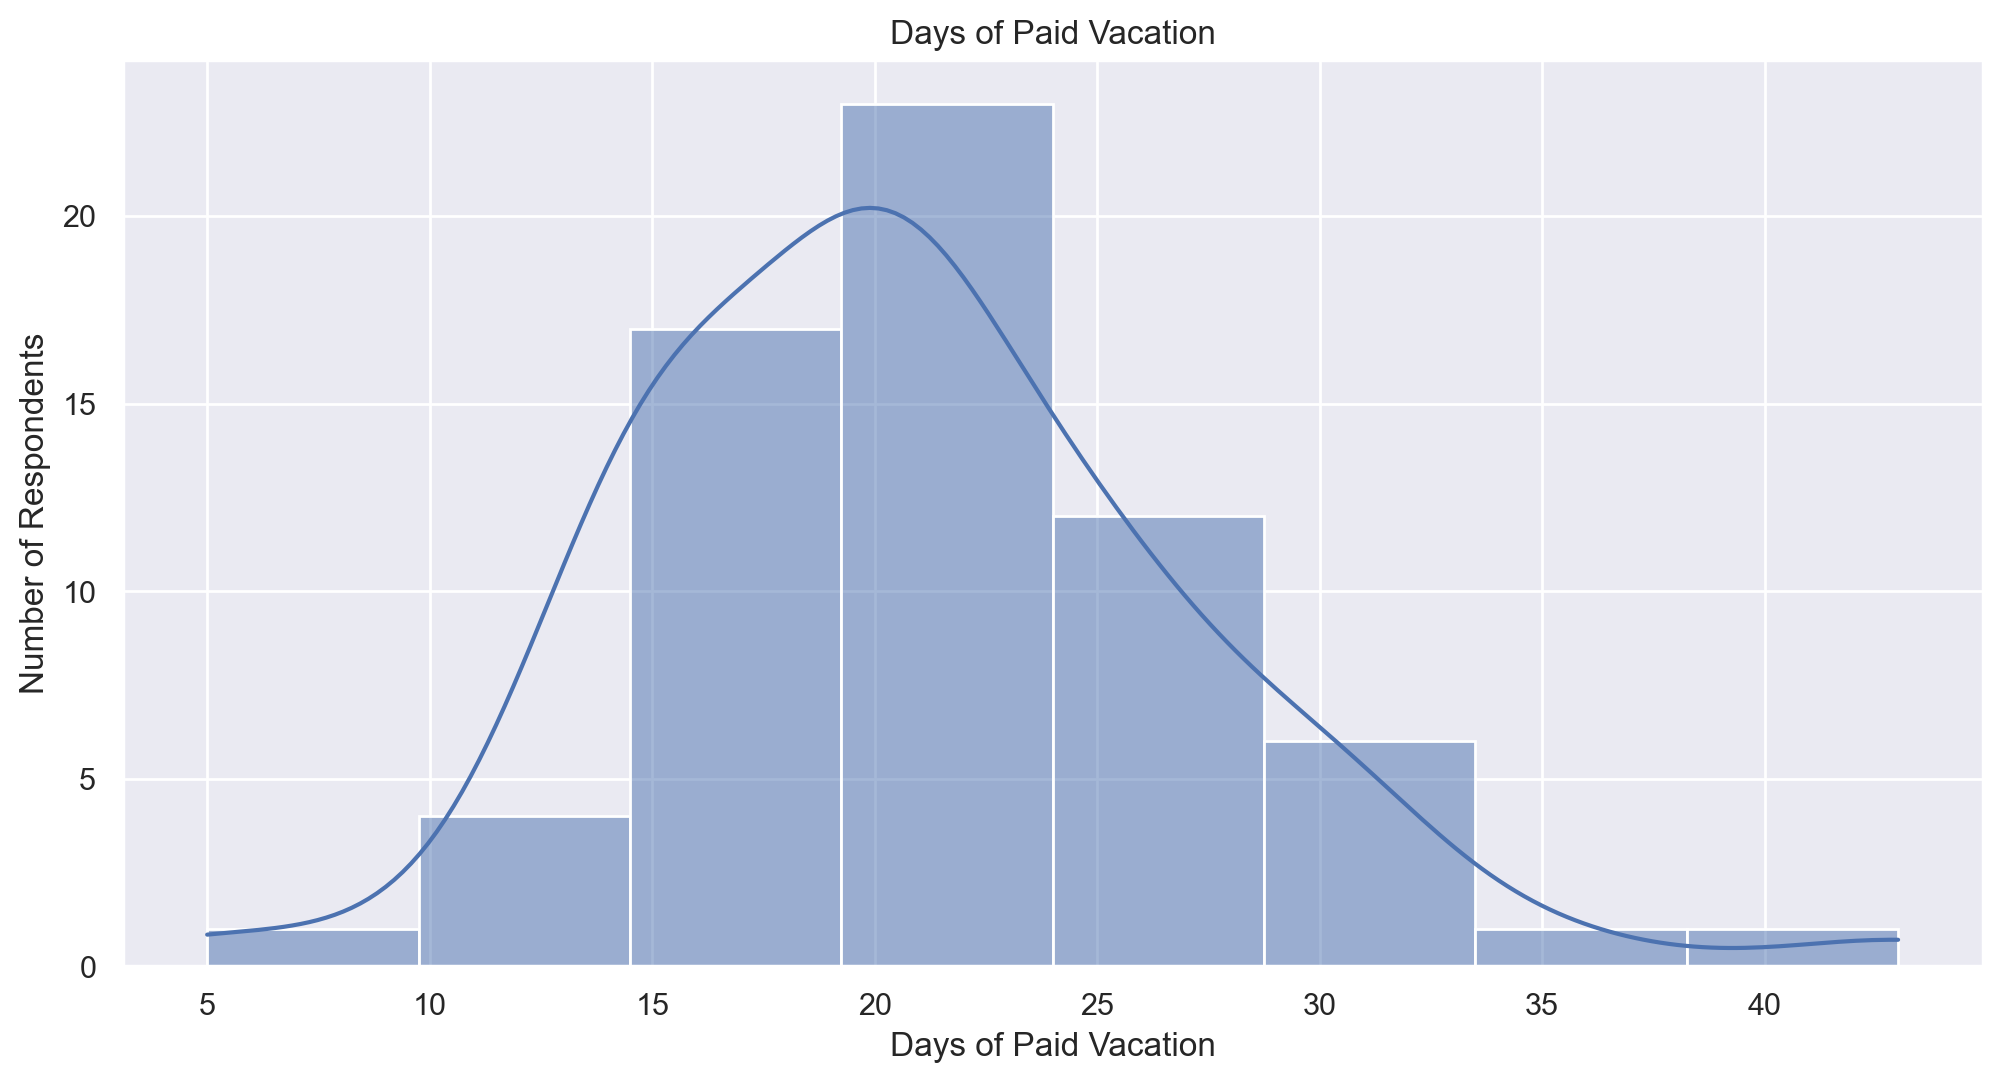

In [35]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "job_vacation", bins=8, kde=True, data=data)
plot.set(
    xlabel="Days of Paid Vacation",
    ylabel="Number of Respondents",
    title="Days of Paid Vacation"
)
plot.get_figure().savefig("figures/job_vacation.svg")
plt.show()

The most common benefits provided were health, dental, and vision insurance,
followed by matching contributions to eomployee retirement accounts.  Health 
savings accounts were also fairly popular.  Equity (or stock options), profit
sharing / incentive bonuses, and tuition reimbursement were also offered by
some employers.


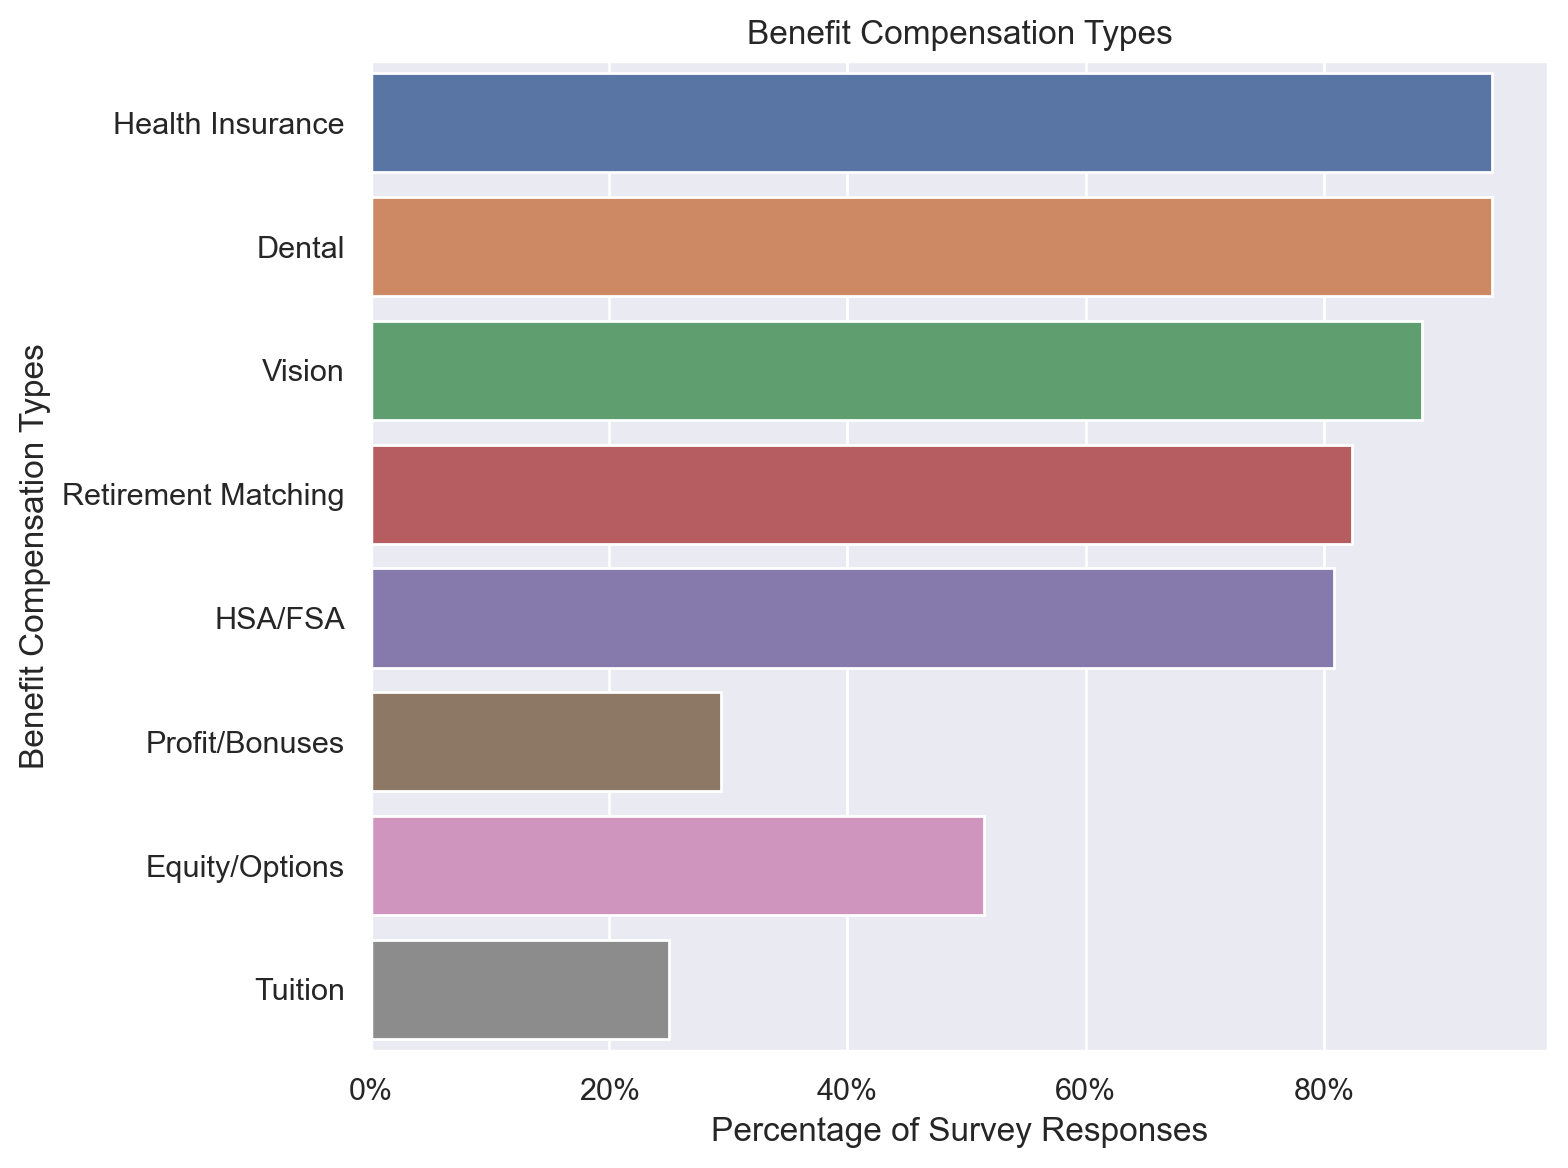

In [36]:
benefit_labels = [
    "Health Insurance",
    "Dental",
    "Vision",
    "Retirement Matching",
    "HSA/FSA",
    "Profit/Bonuses",
    "Equity/Options",
    "Tuition",
]
benefit_percentages = [
    data['benefits_health'].mean() * 100,
    data['benefits_dental'].mean() * 100,
    data['benefits_vision'].mean() * 100,
    data['benefits_retirement_matching'].mean() * 100,
    data['benefits_hsa'].mean() * 100,
    data['benefits_profit_sharing'].mean() * 100,
    data['benefits_equity_options'].mean() * 100,
    data['benefits_tuition'].mean() * 100,
]
benefits_df = pd.DataFrame({'Benefit': benefit_labels, 'Percentage':benefit_percentages })

plt.figure(figsize=(8,6), dpi=200)
plot = sns.barplot(y="Benefit", x="Percentage", data=benefits_df)
plot.xaxis.set_major_formatter(mtick.PercentFormatter())
plot.set(
    xlabel="Percentage of Survey Responses",
    ylabel="Benefit Compensation Types",
    title="Benefit Compensation Types"
)
plt.tight_layout()
plot.get_figure().savefig("figures/benefits.svg")
plt.show()
plt.close('all')


# Remote Work

TODO: Narrative for opinions on remote work.

In [37]:
def remote_likert(col_name, text, low_text = "Strongly Disagree", high_text = "Strongly Agree"):
    # if not low_text:
    #     low_text = "Strongly Disagree"
    # if not high_text:
    #     high_text = "Strongly Agree"
    plt.figure(figsize=(12,6), dpi=200)
    plot = sns.histplot(x = col_name, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], data=data)
    plot.set(
        xlabel=low_text + " (1) through " + high_text + " (7)",
        ylabel="Number of Respondents",
        title=text
    )
    plot.get_figure().savefig("figures/" + col_name + ".svg")
    plt.show()

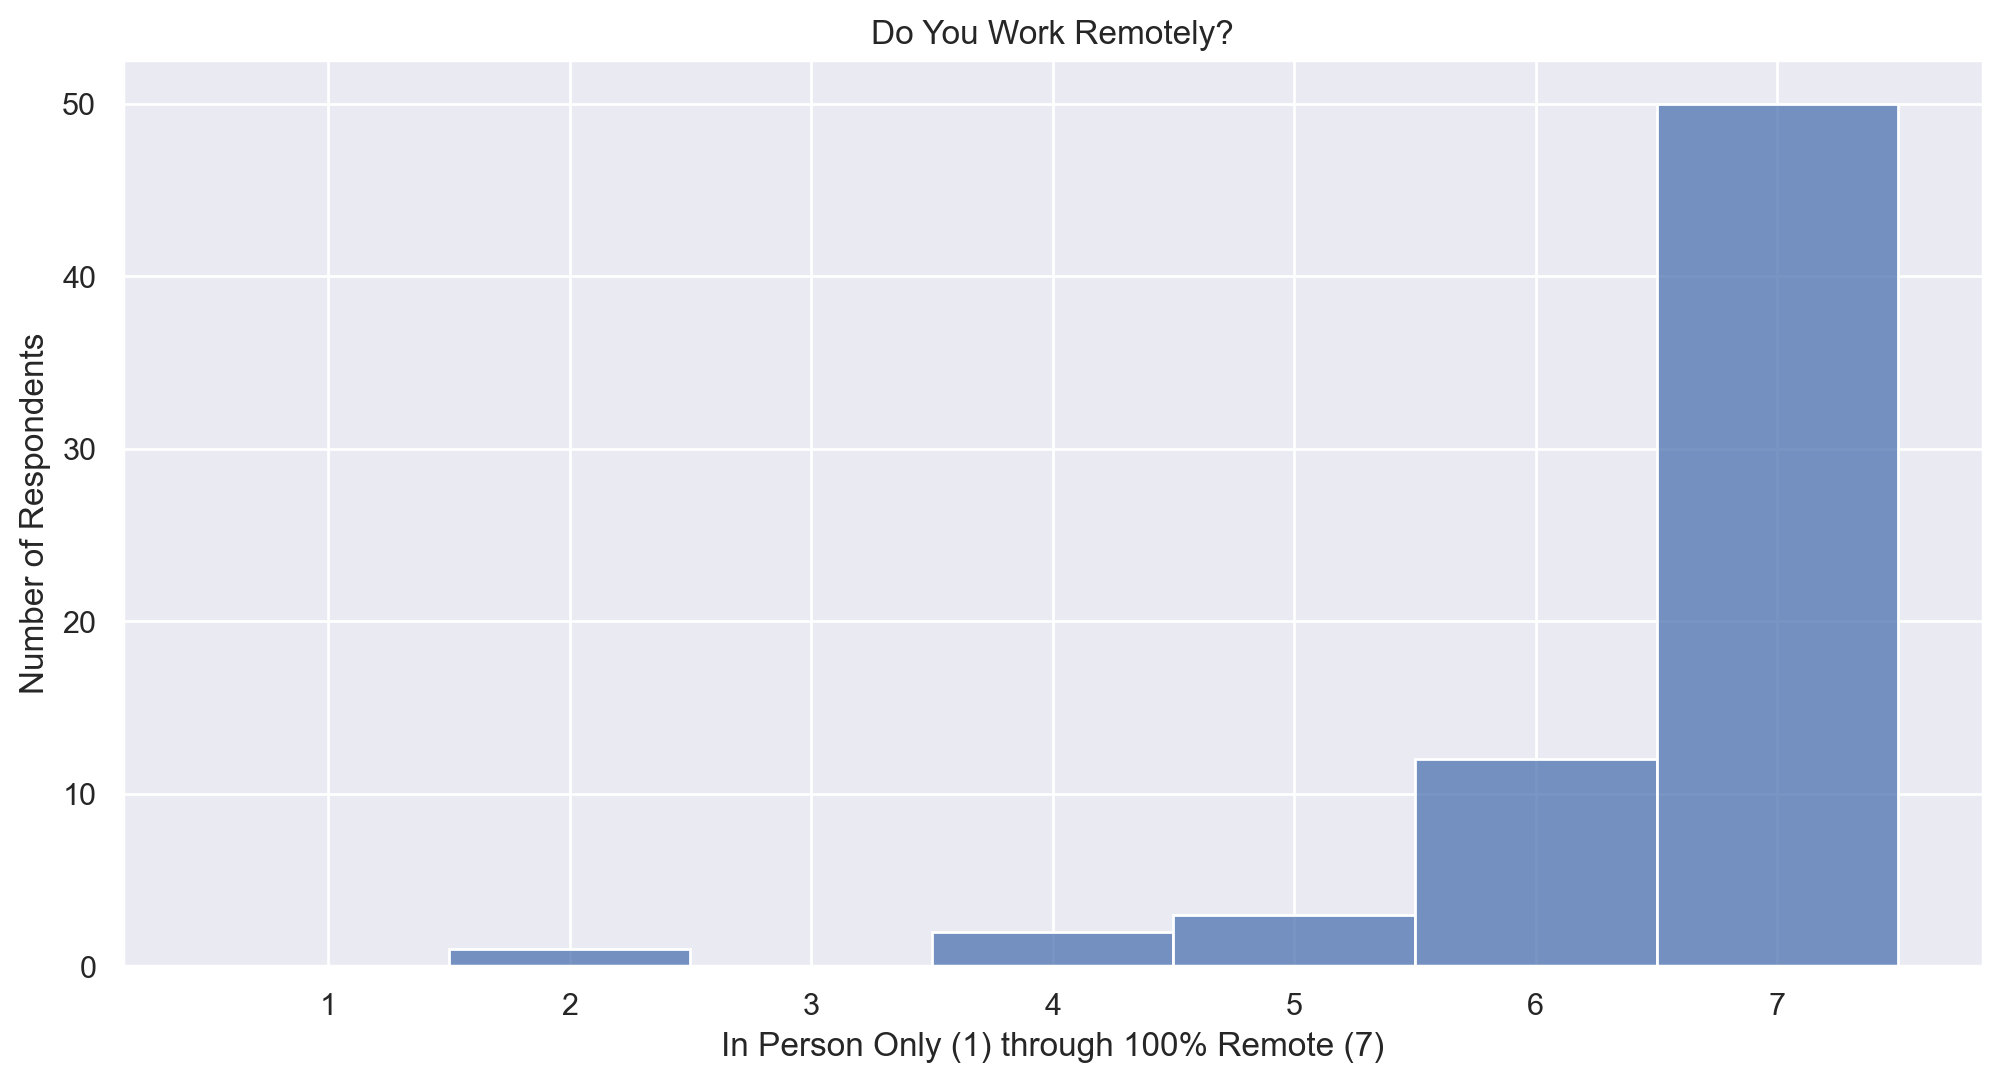

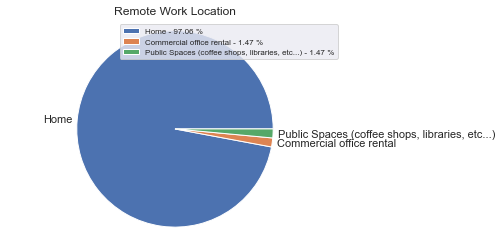

<Figure size 1200x1200 with 0 Axes>

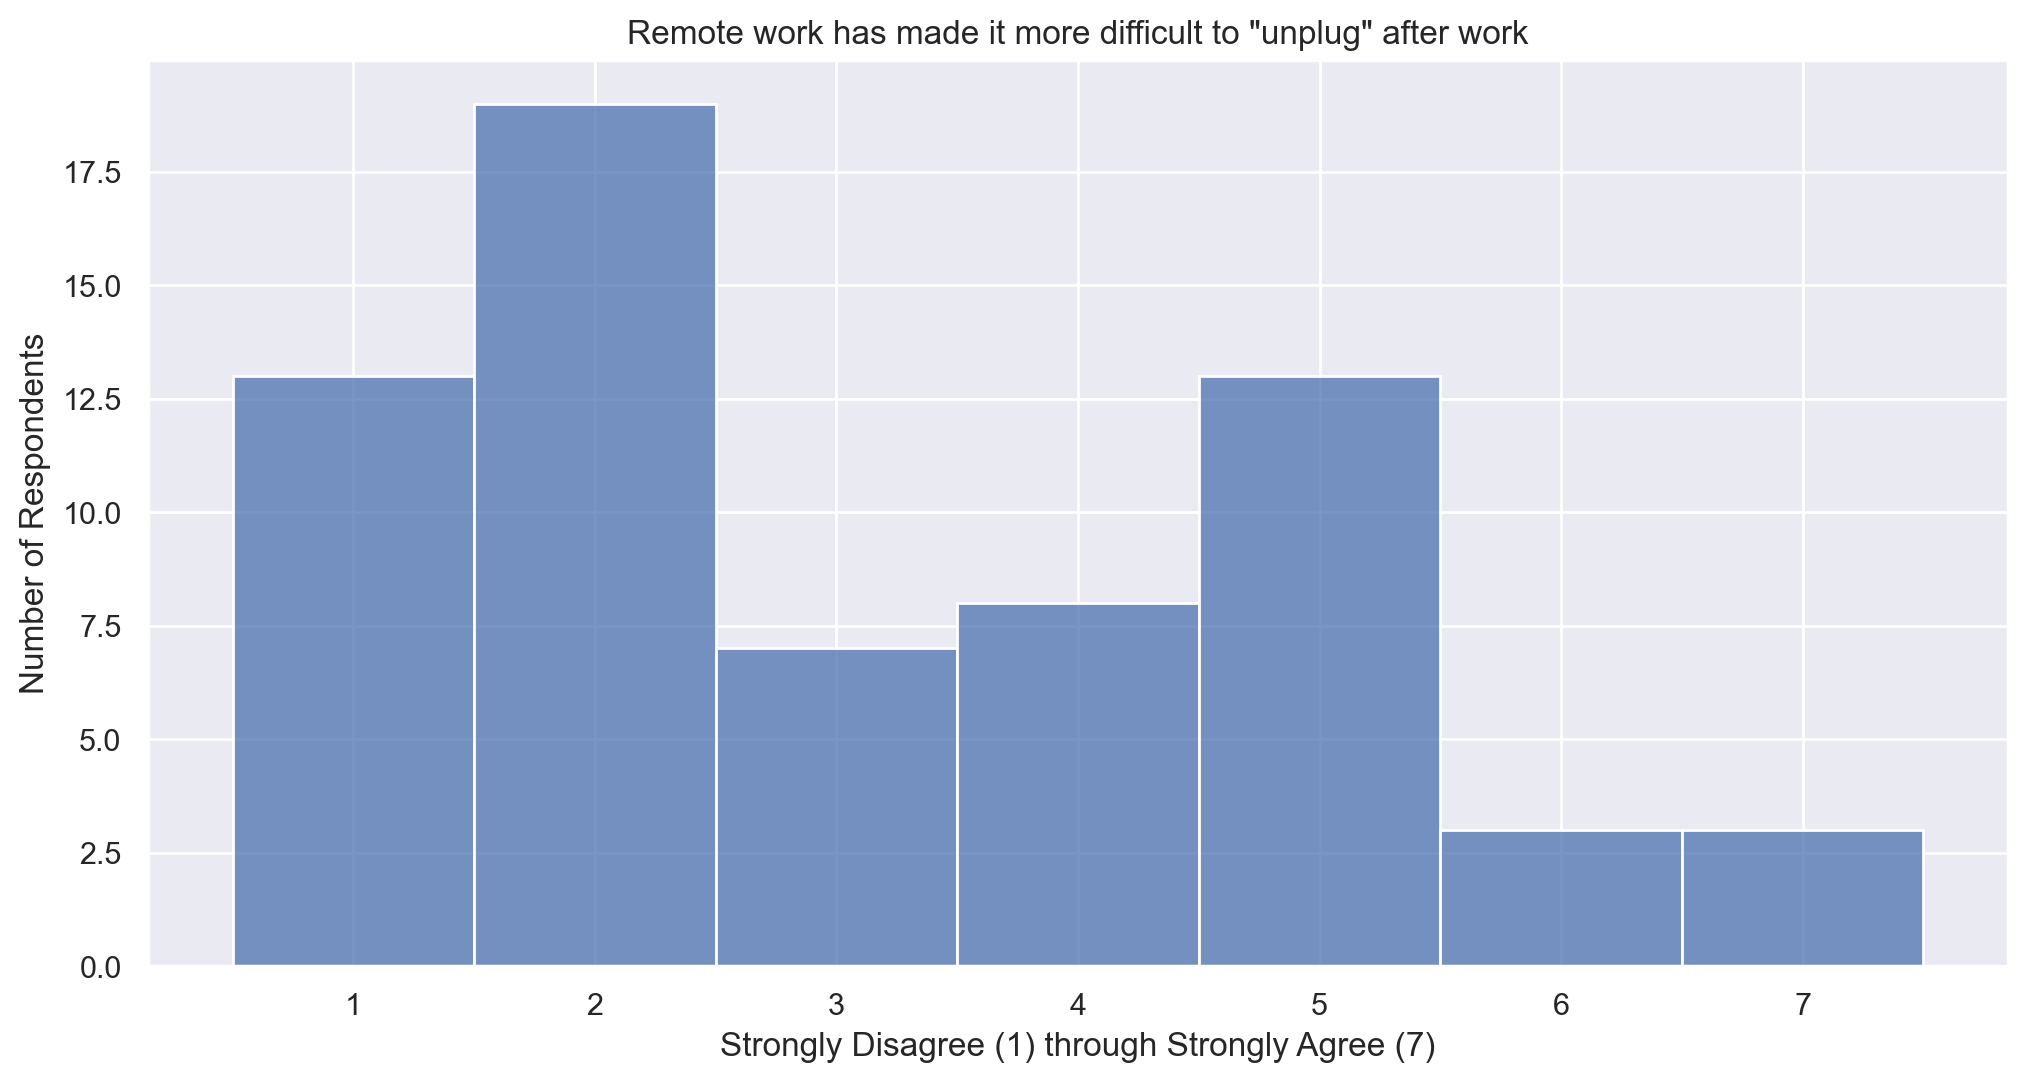

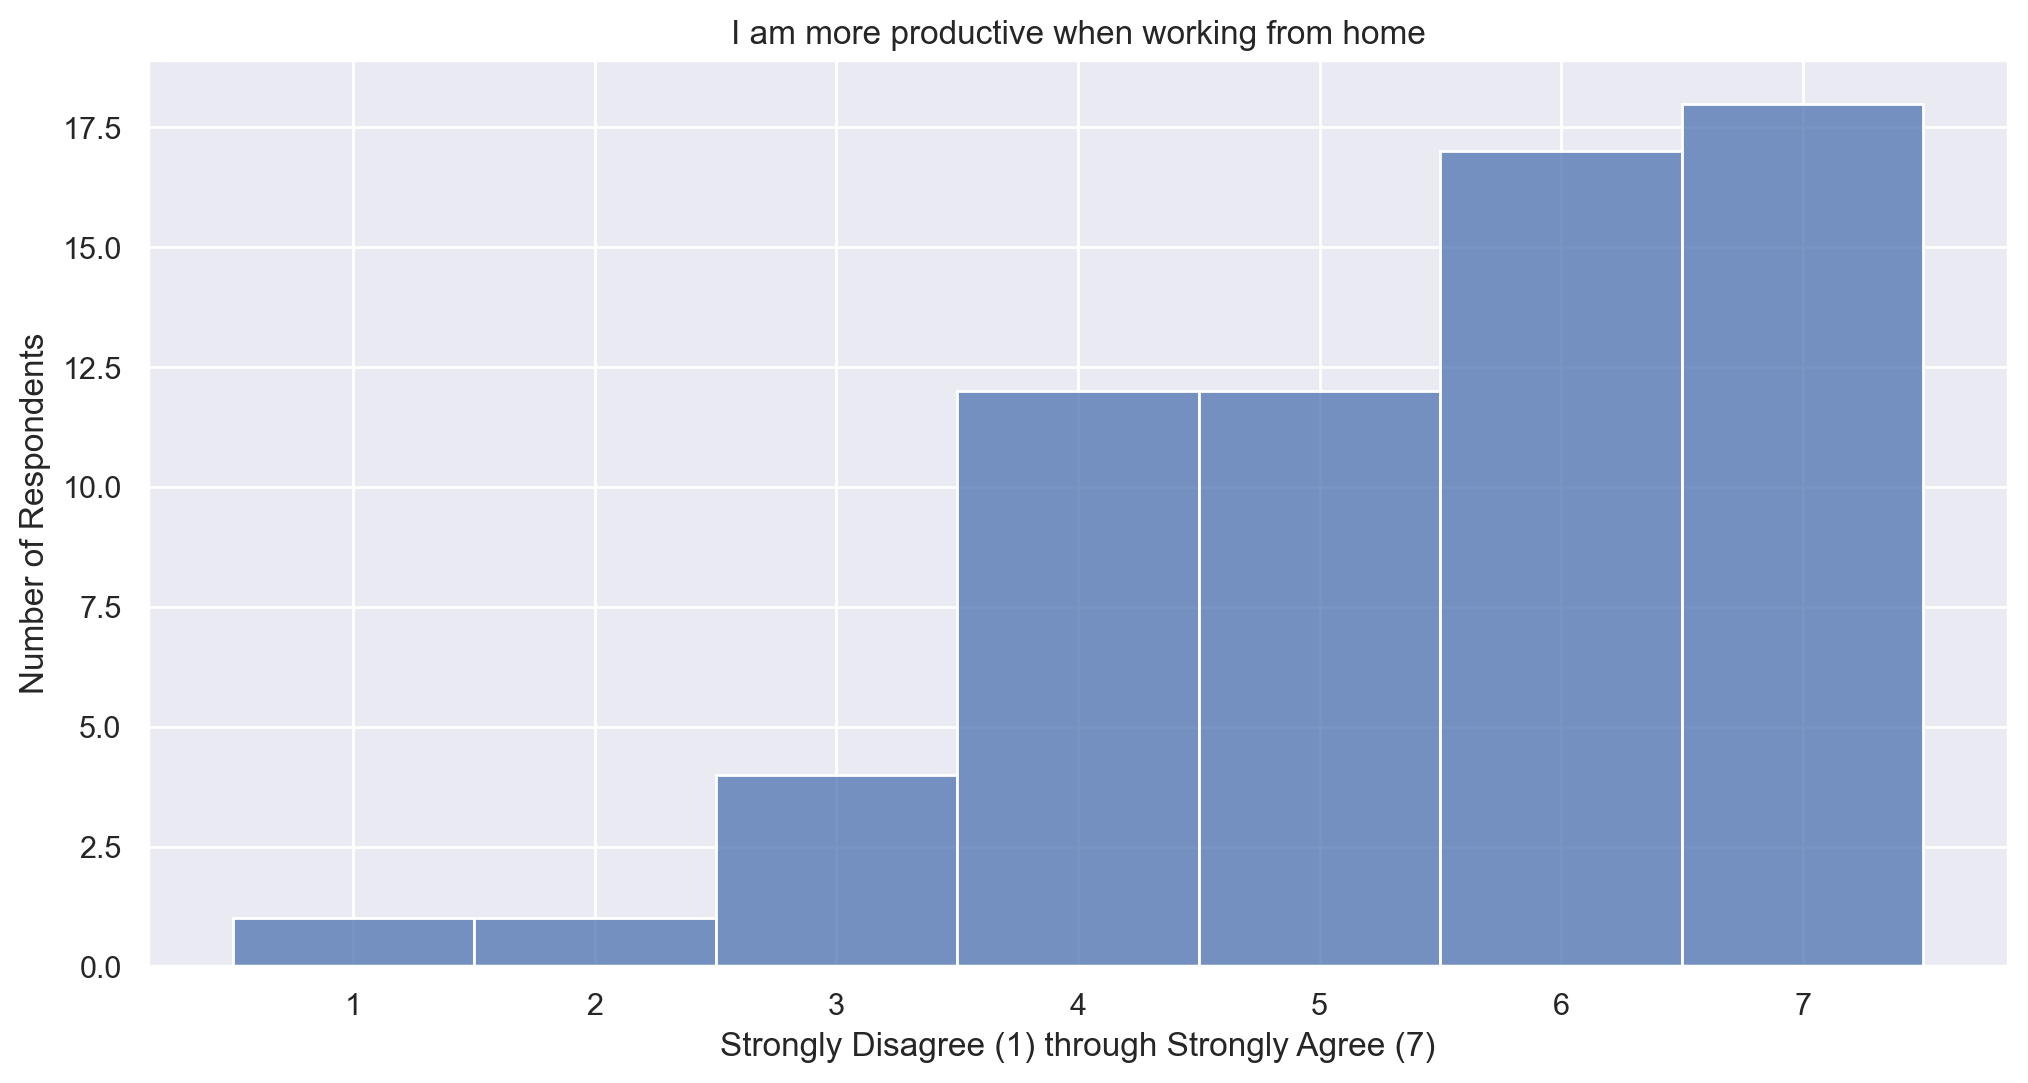

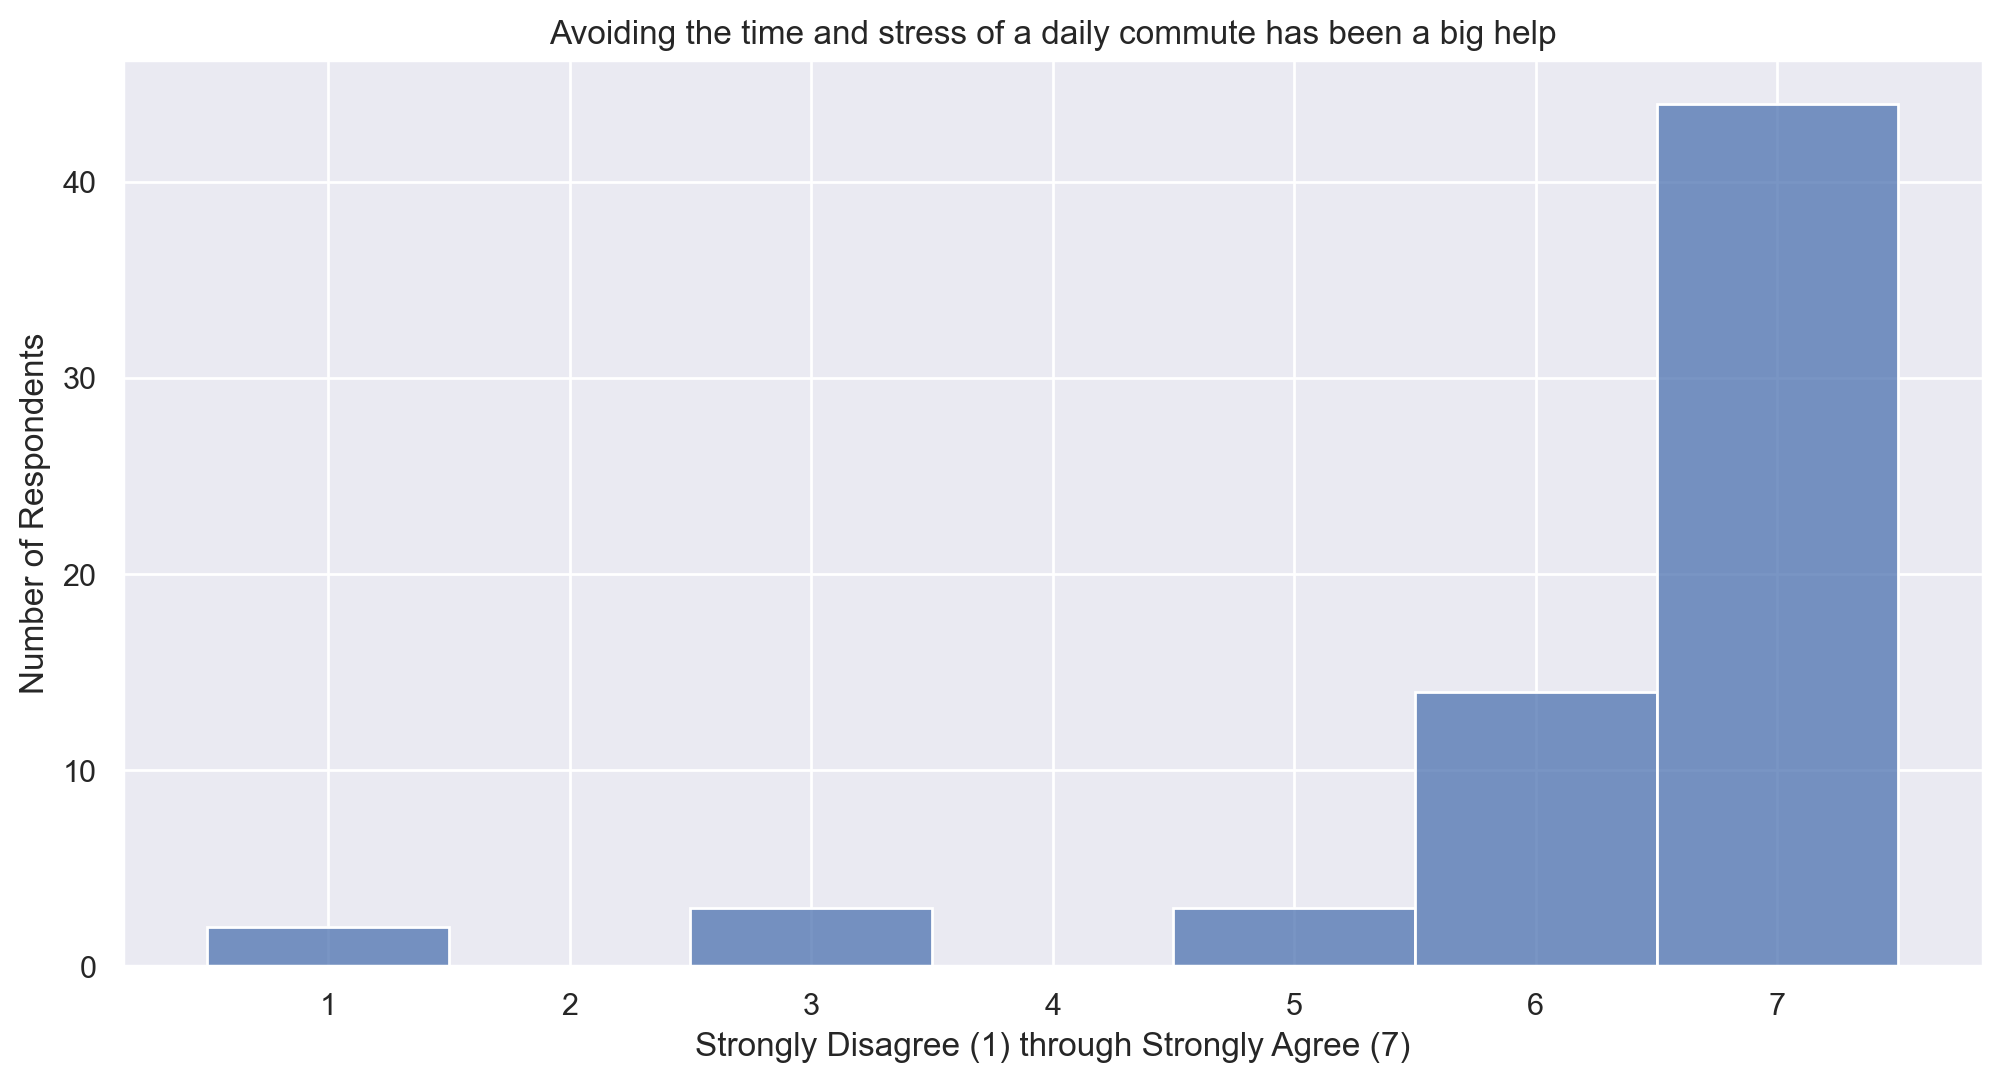

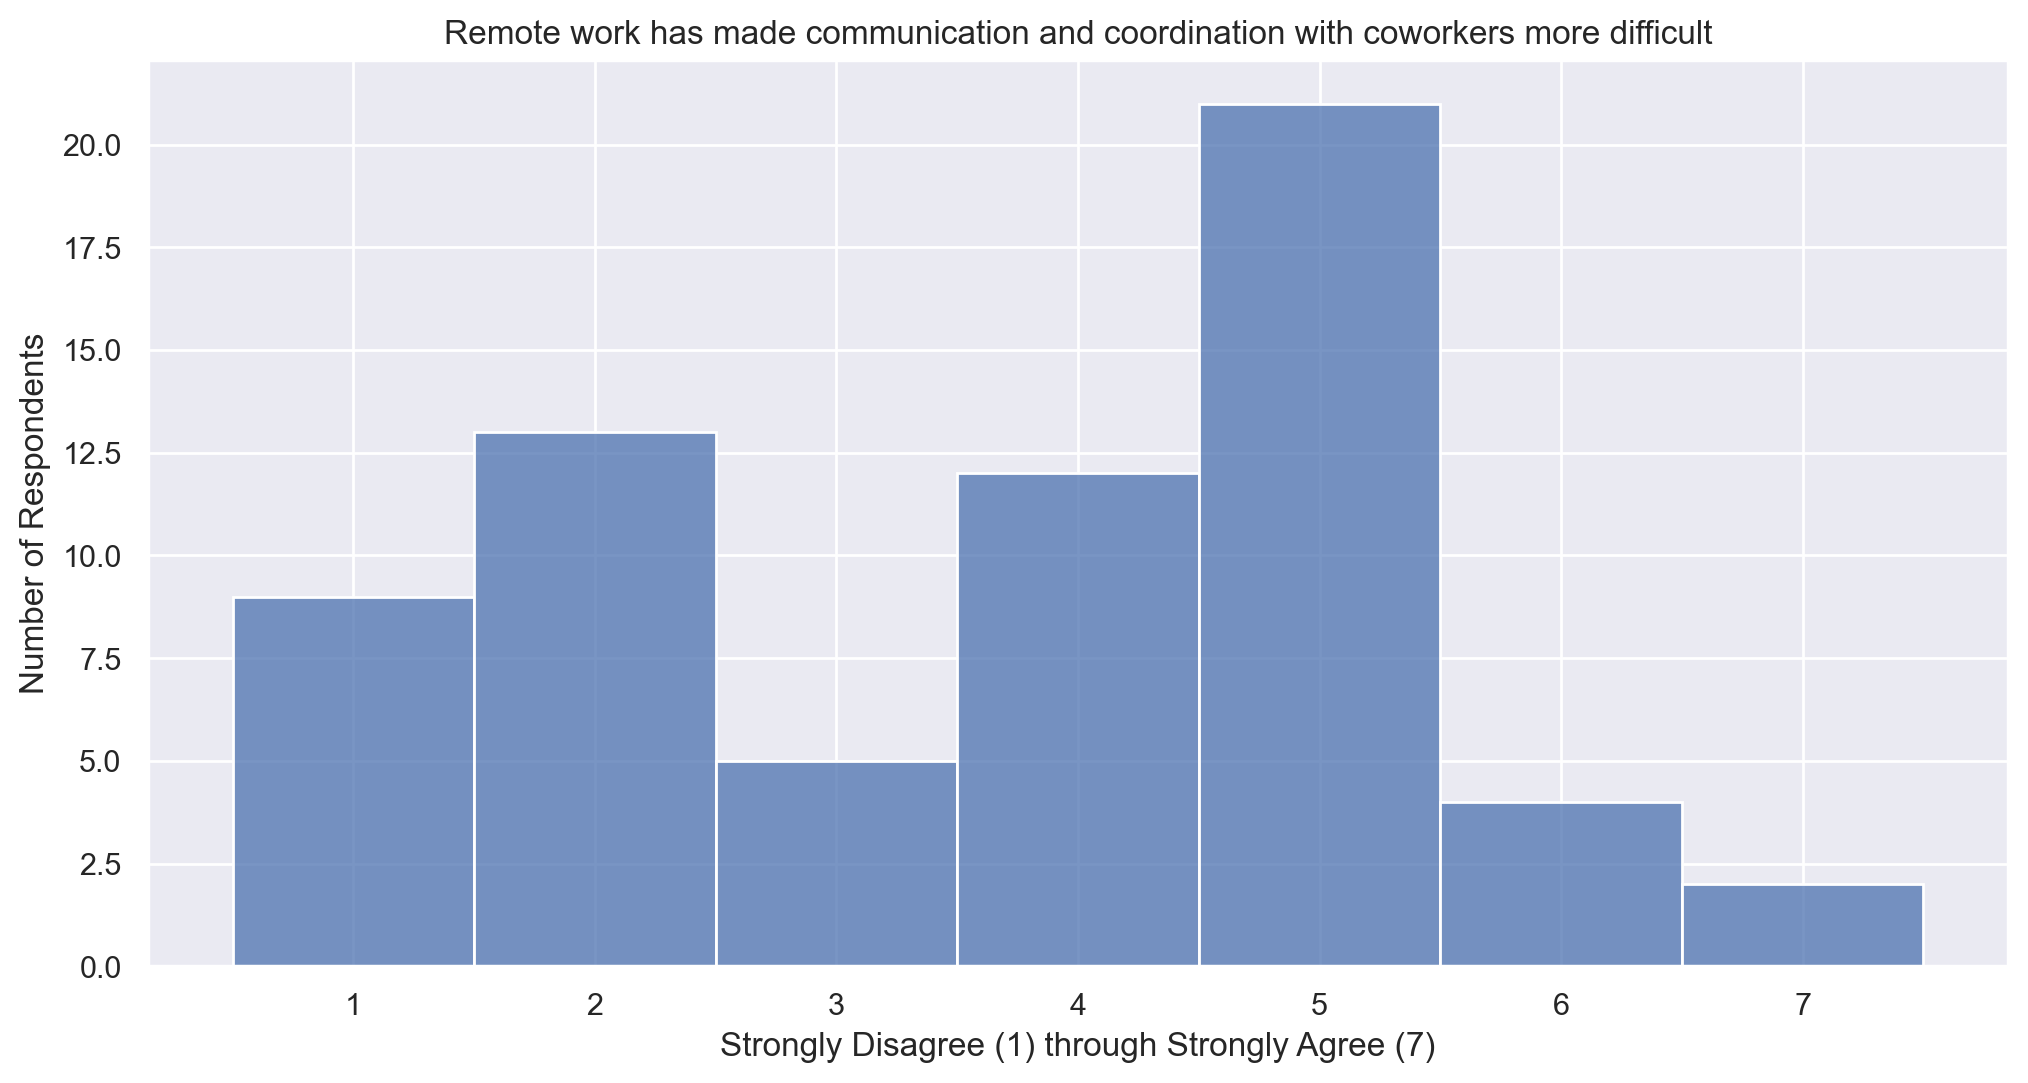

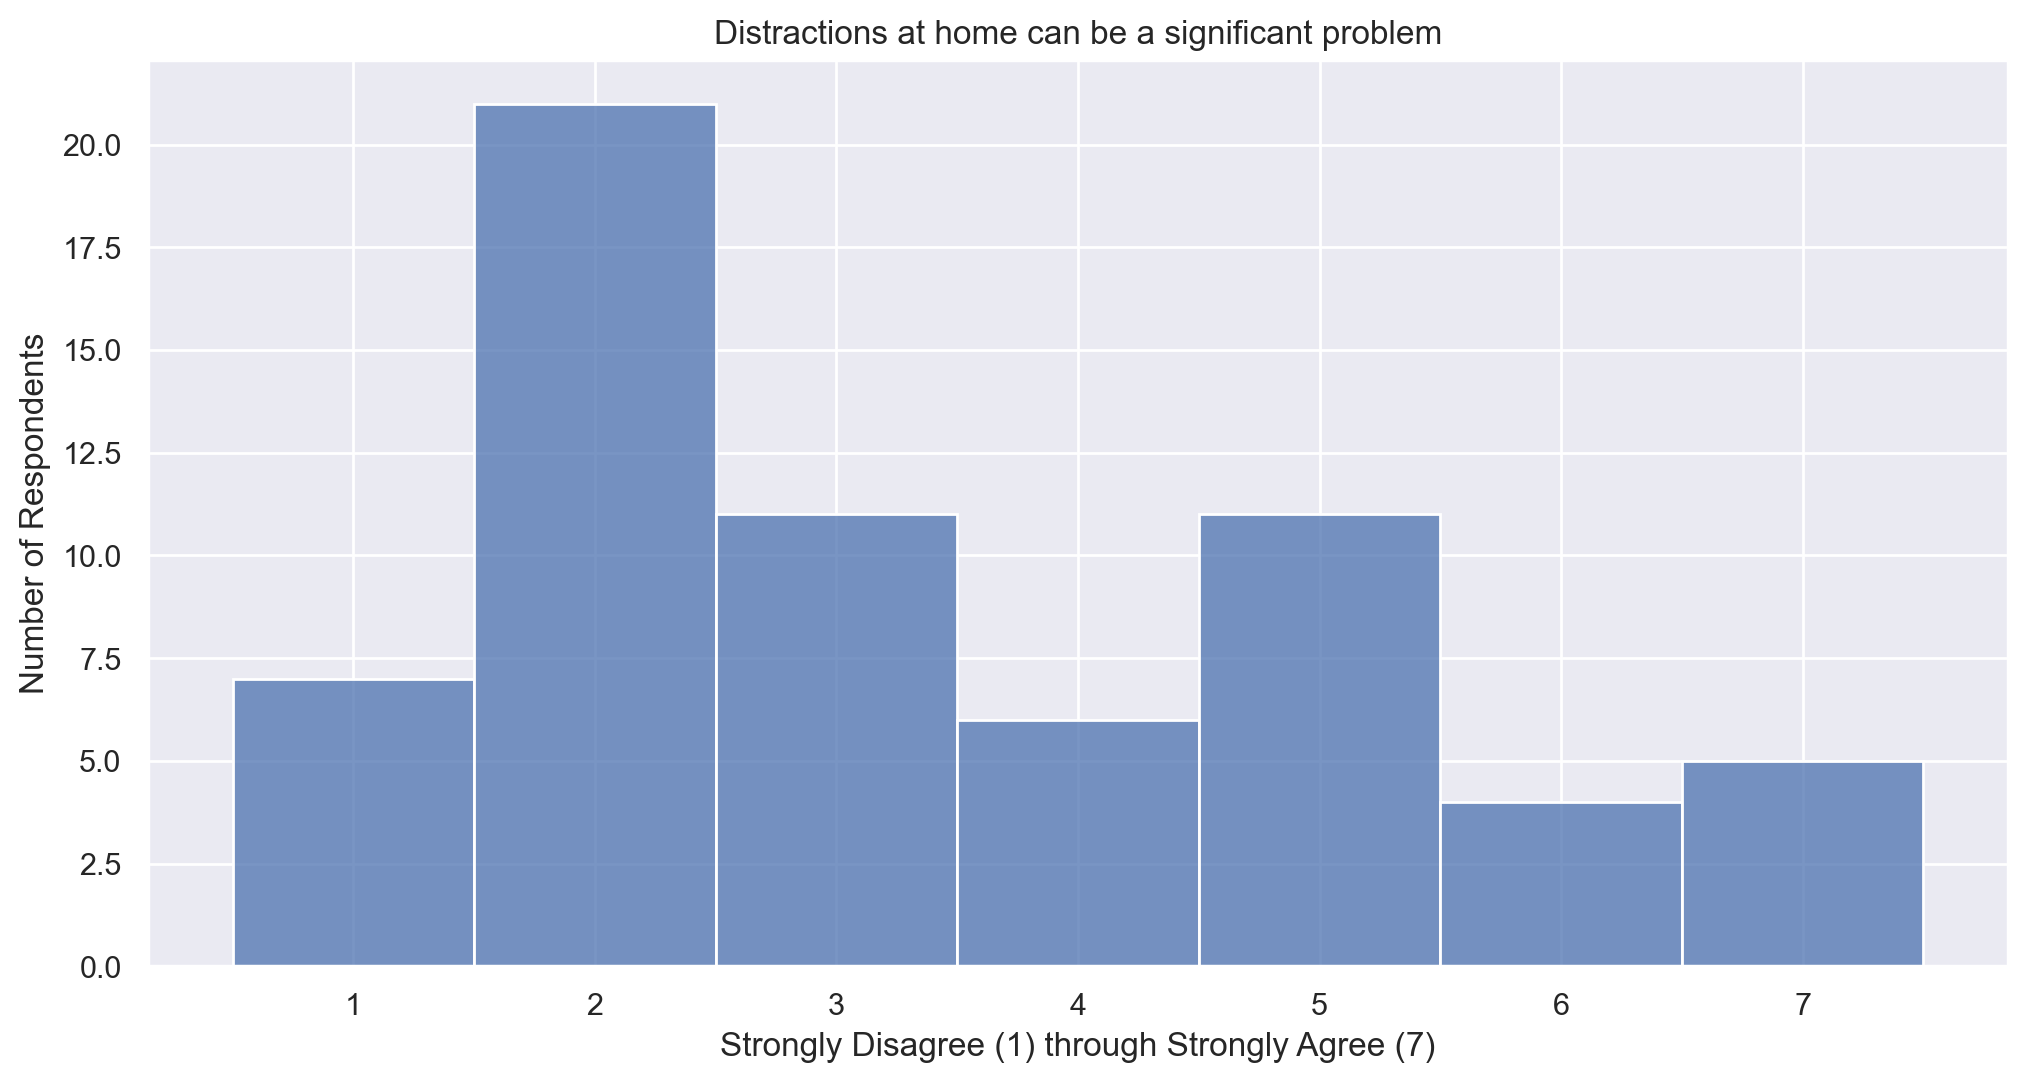

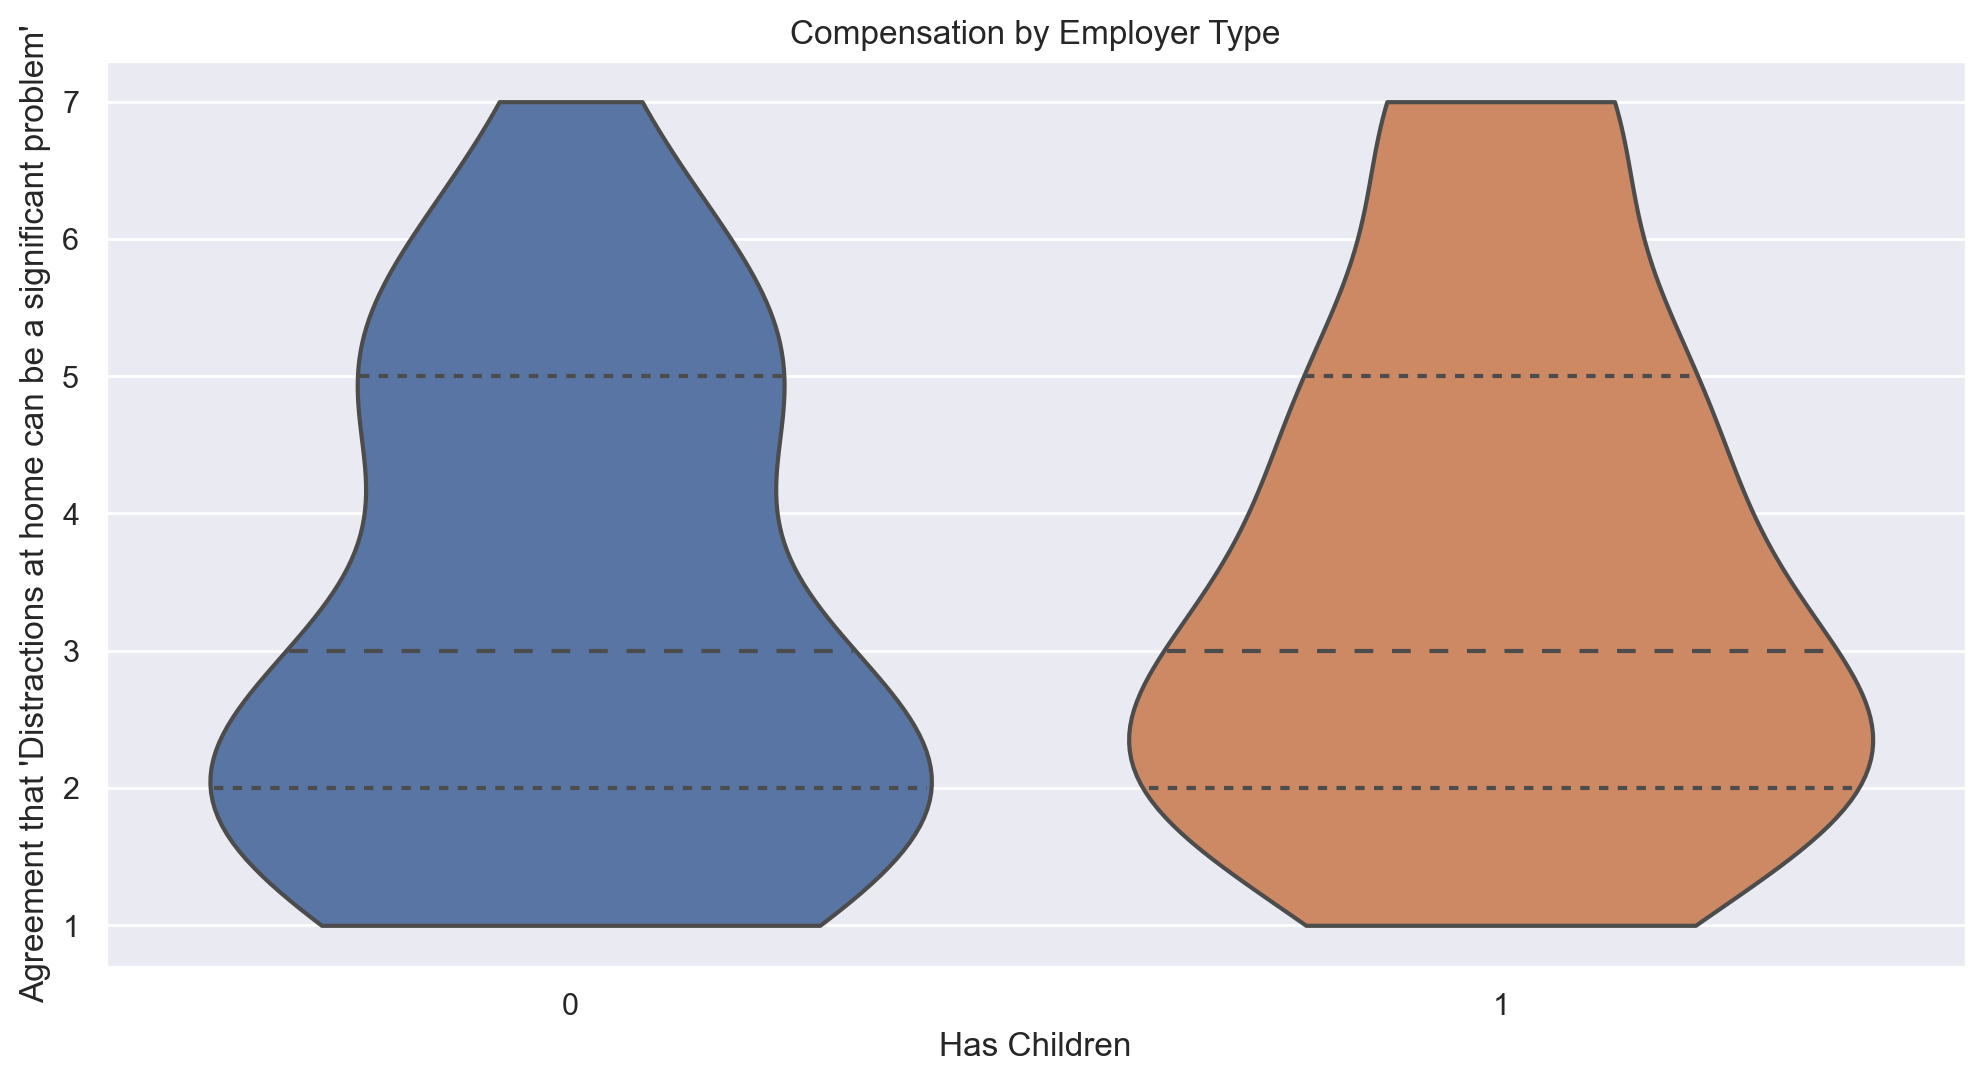

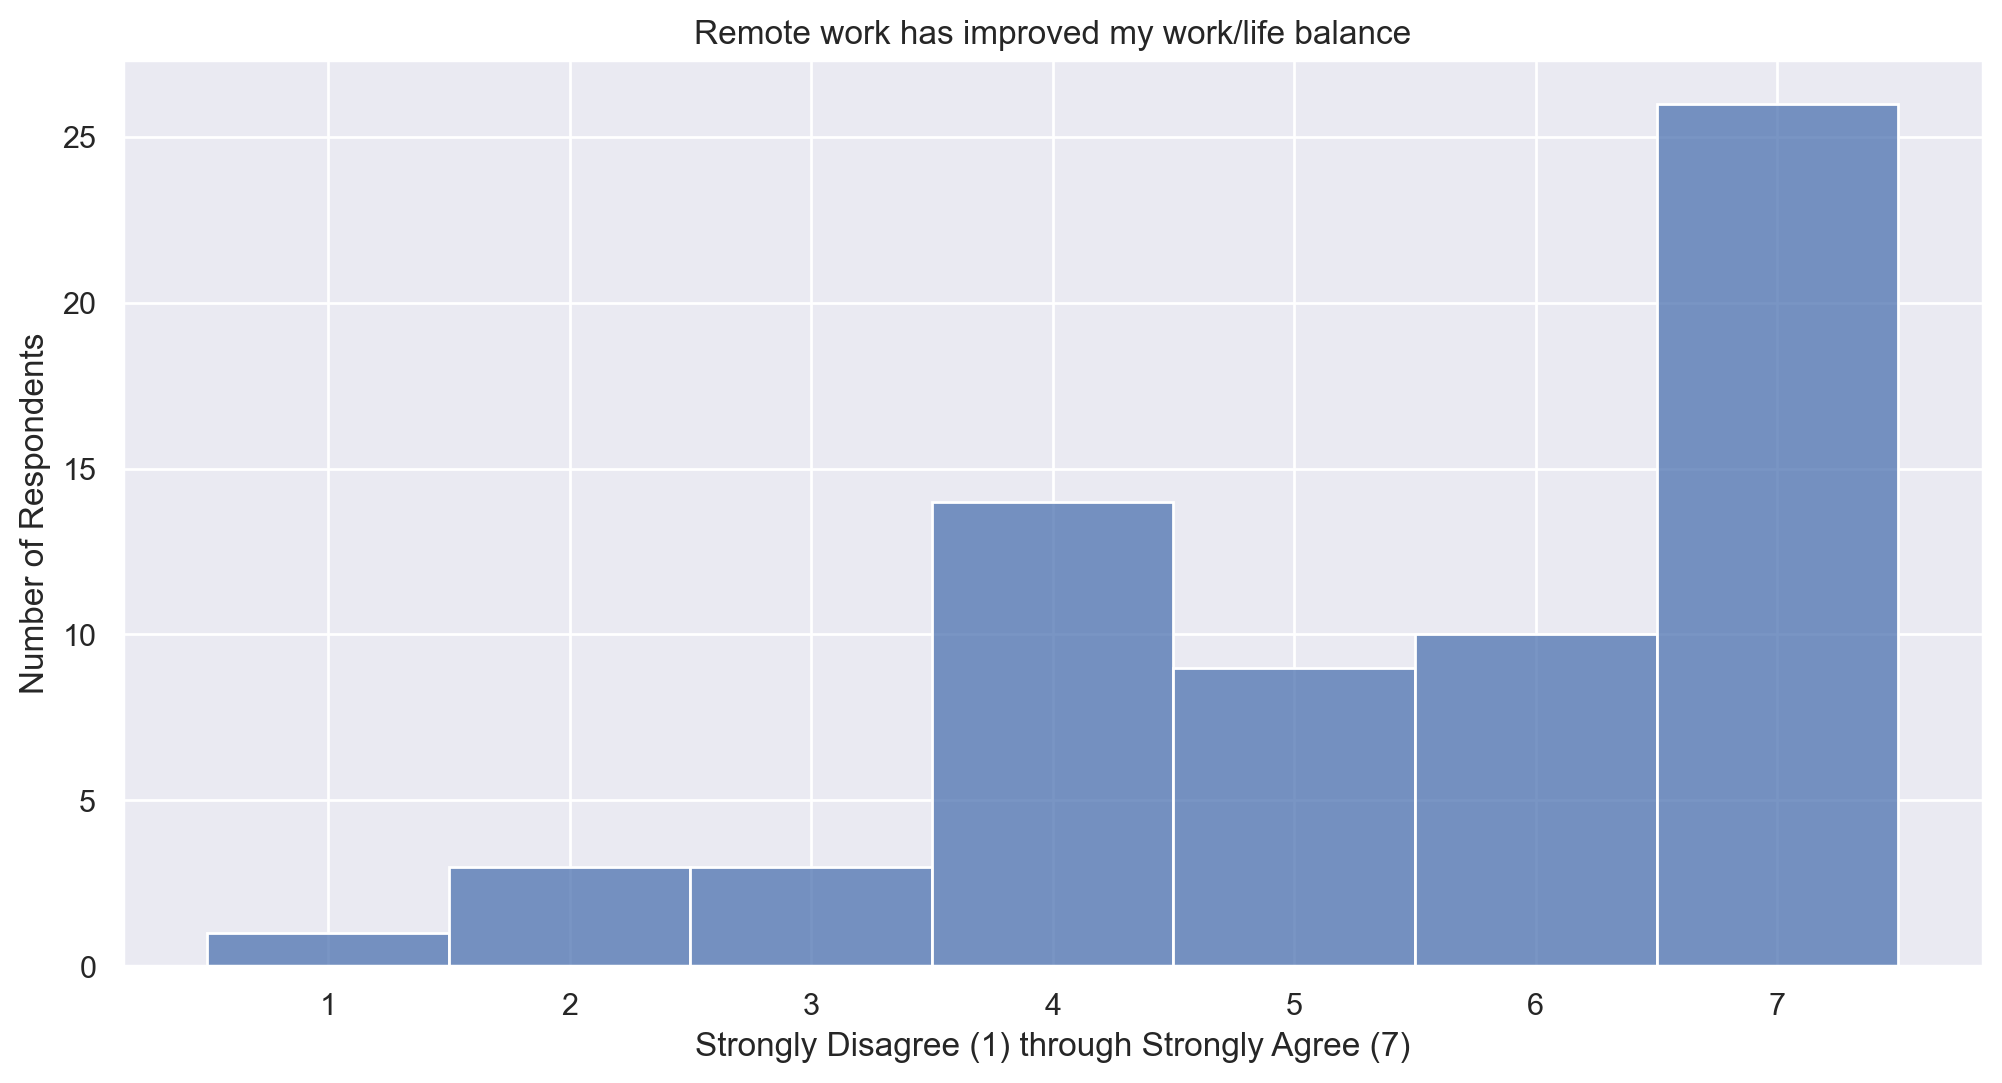

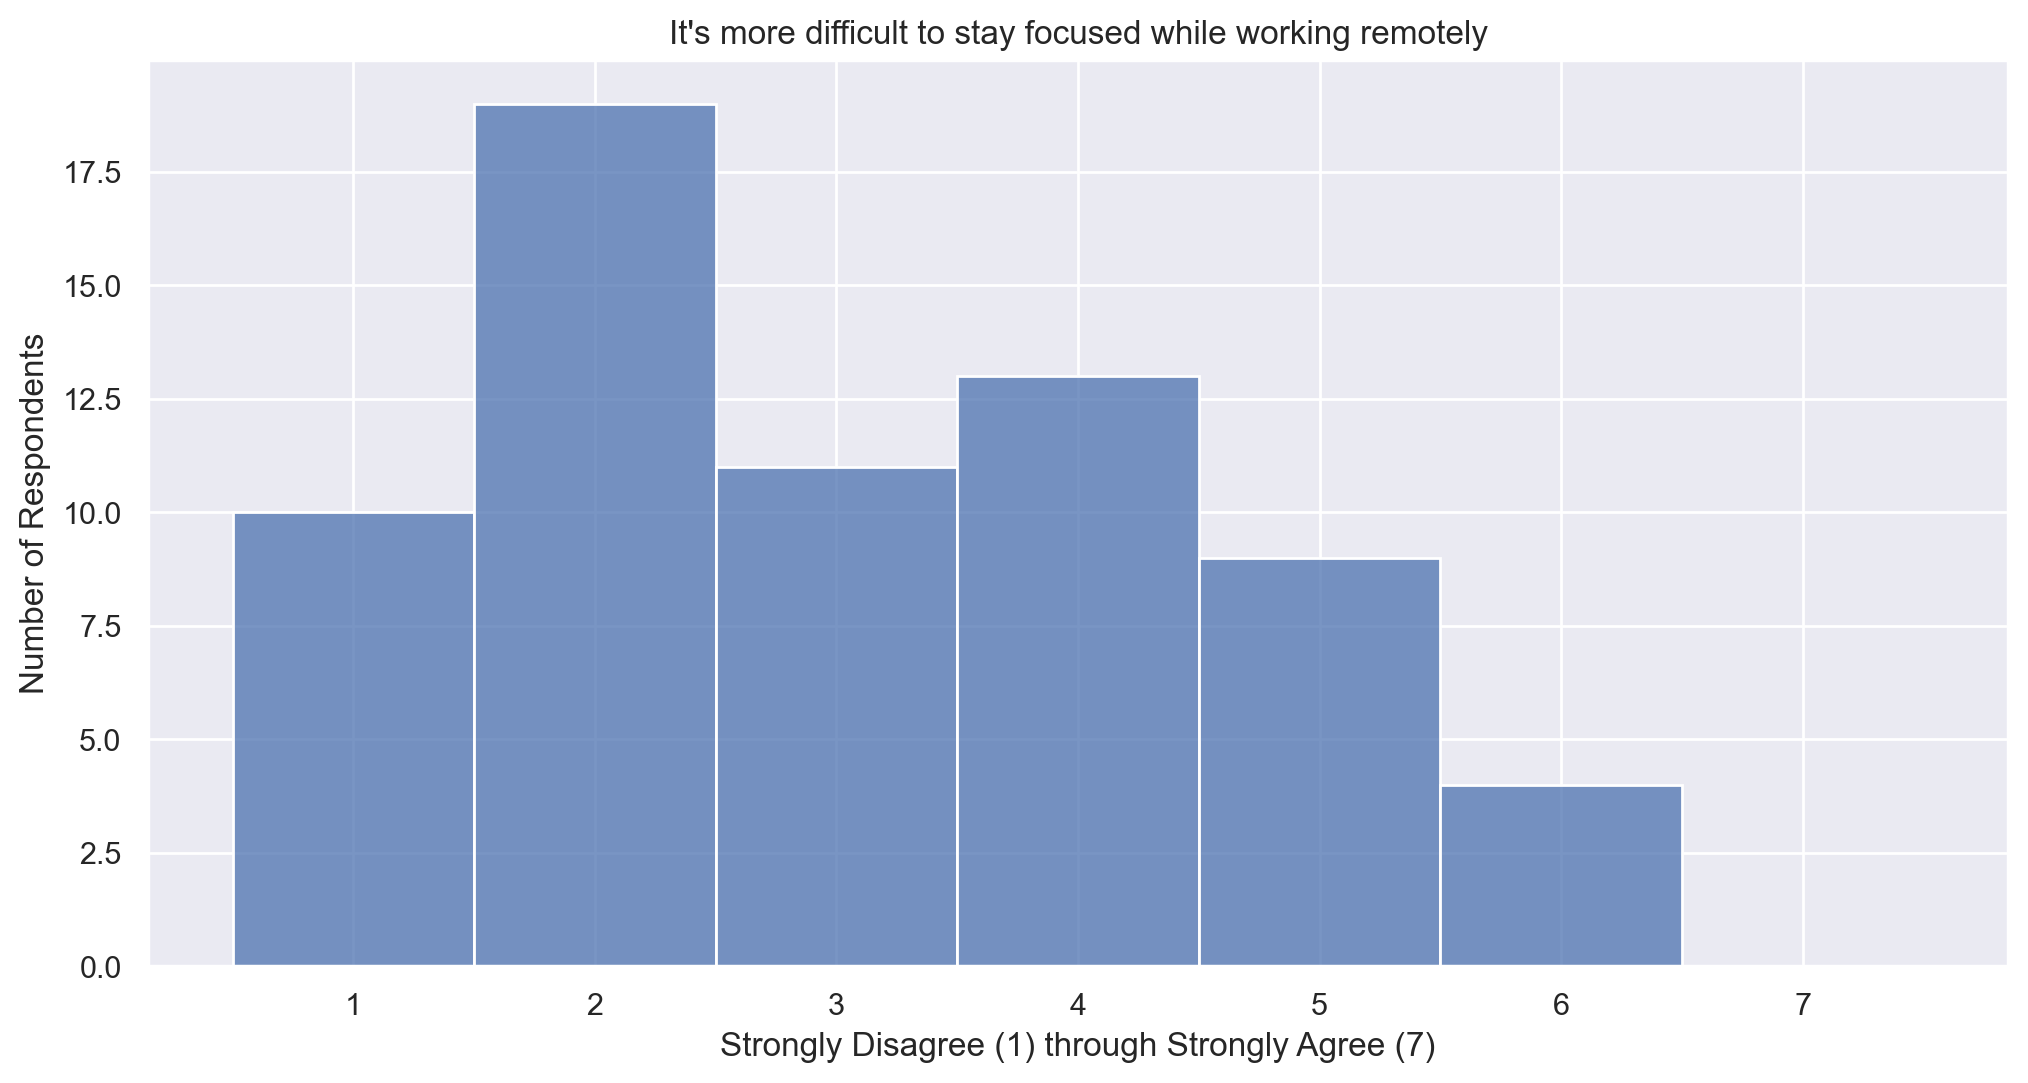

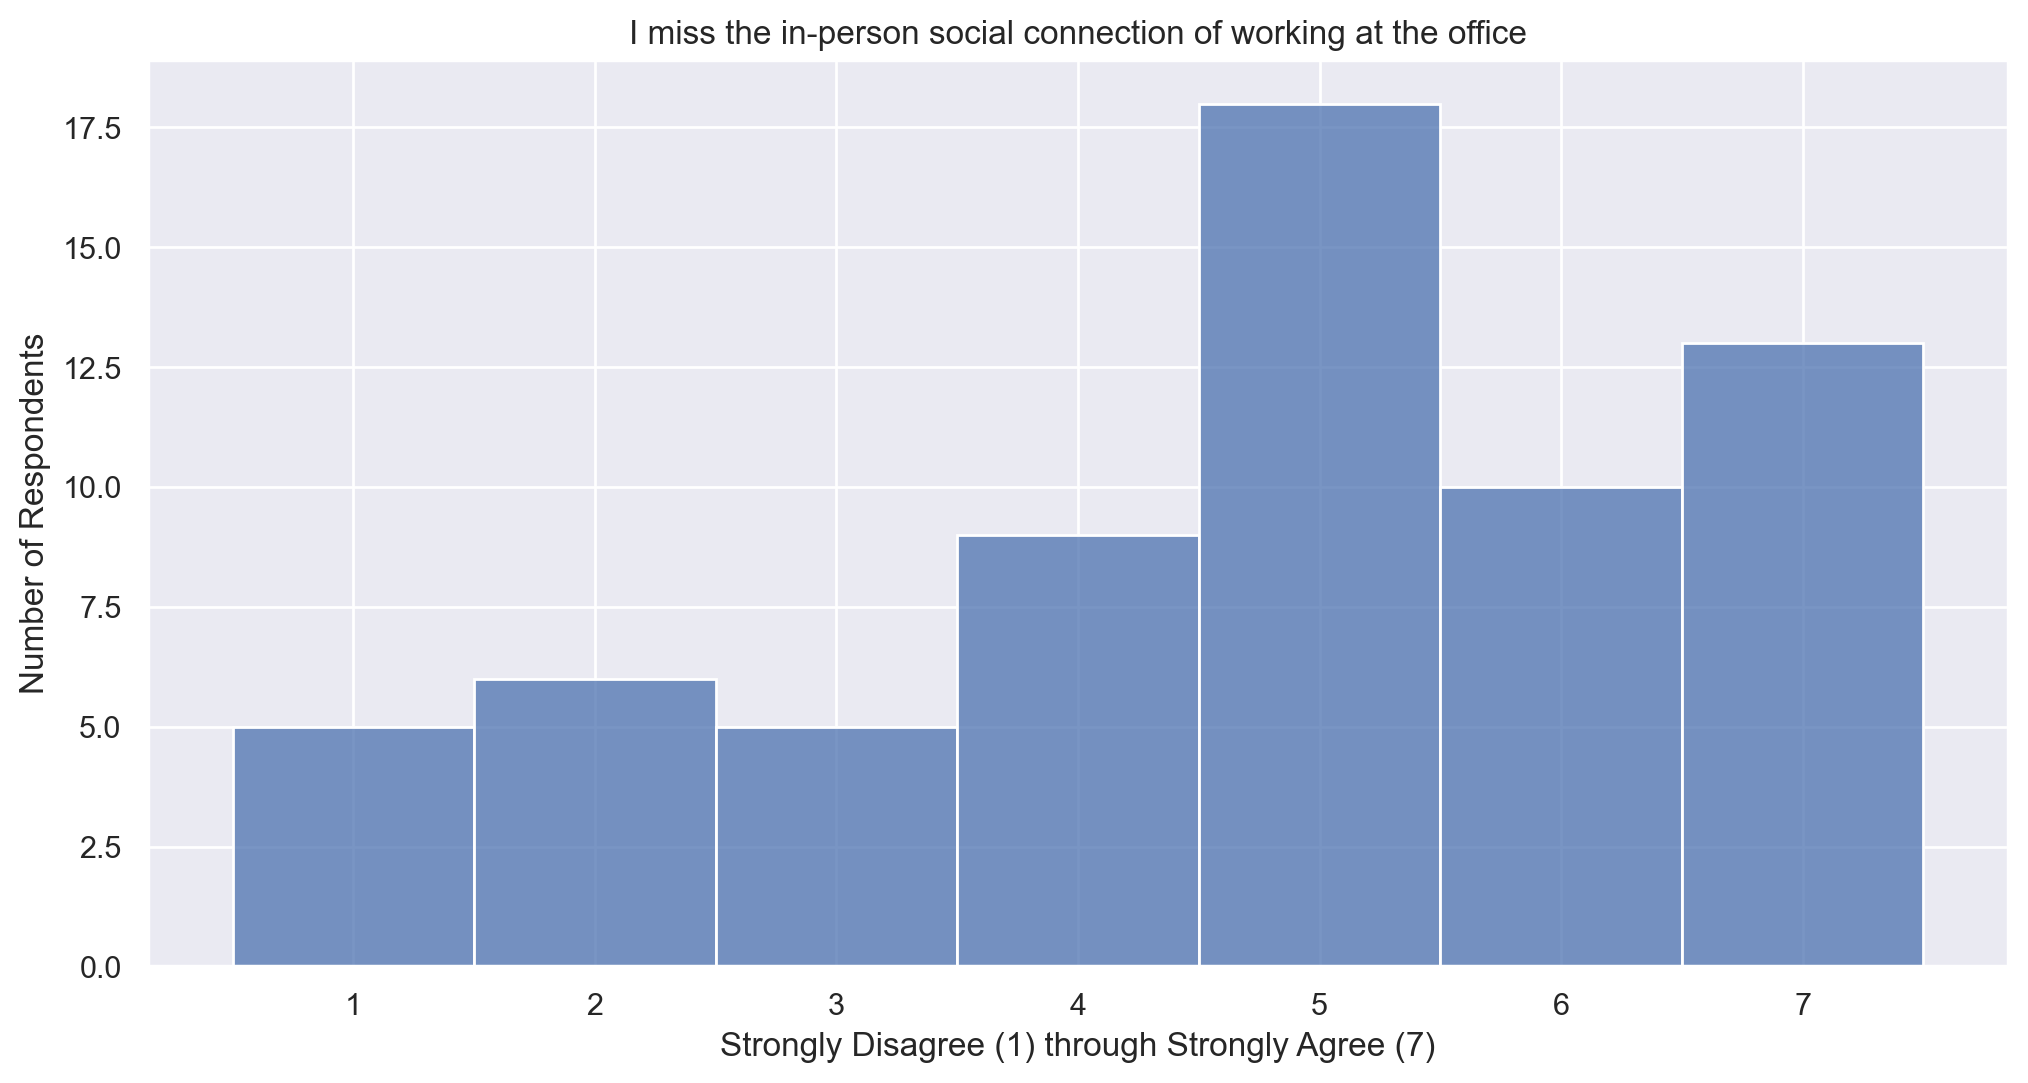

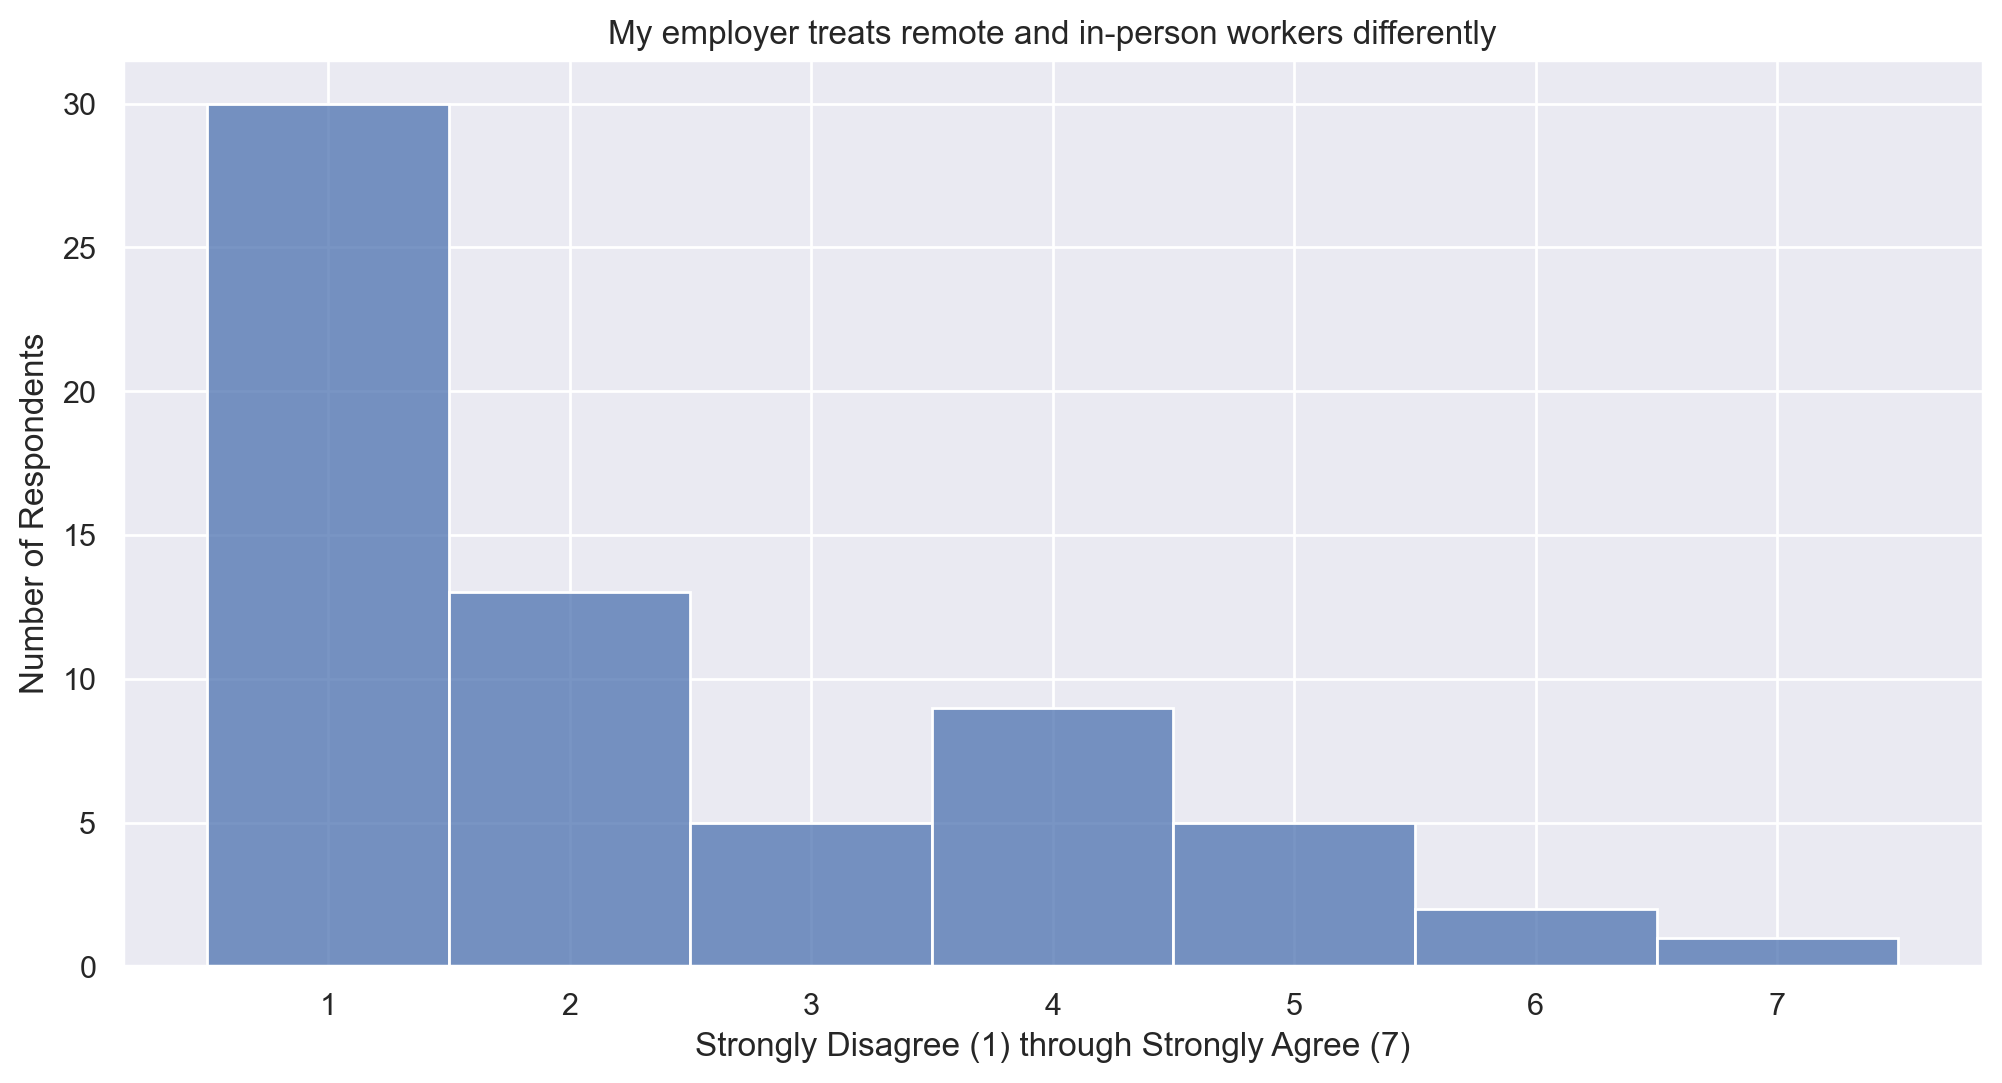

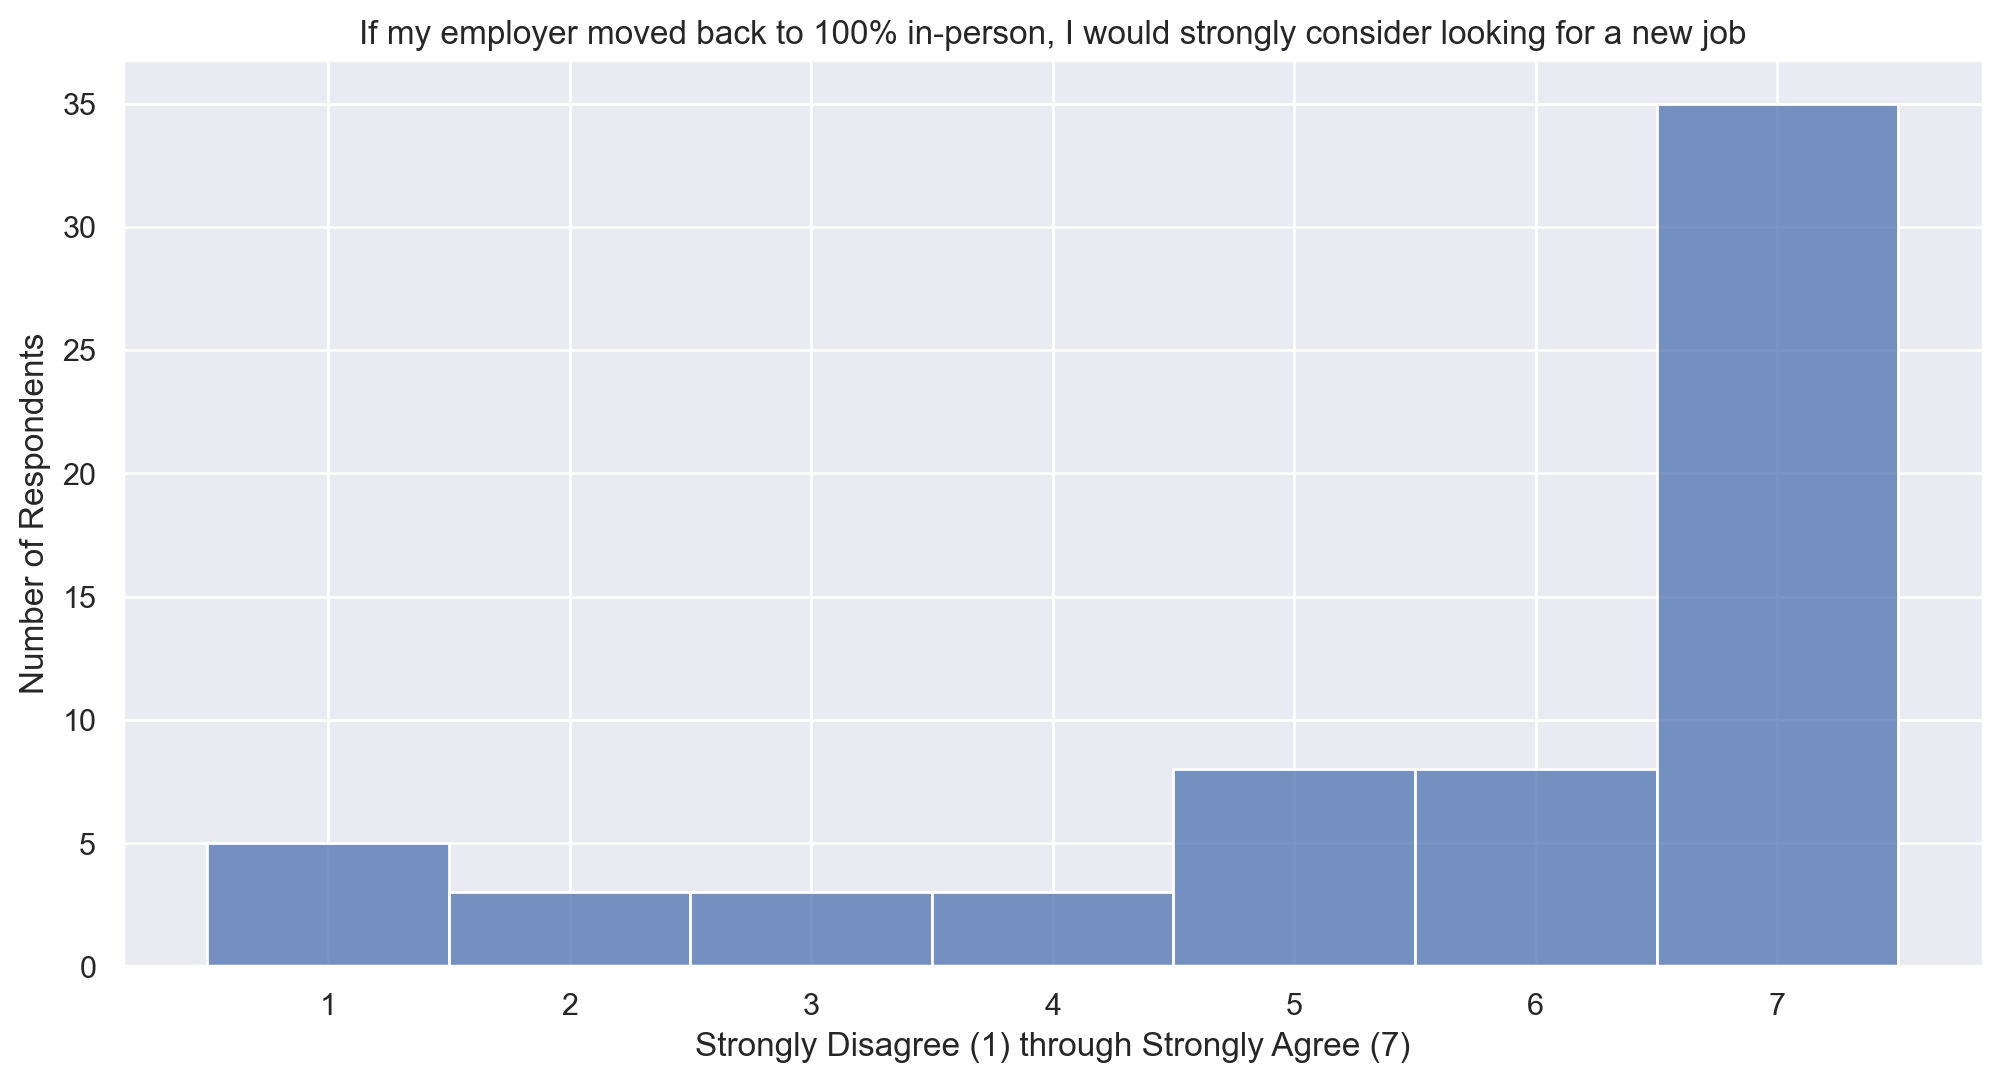

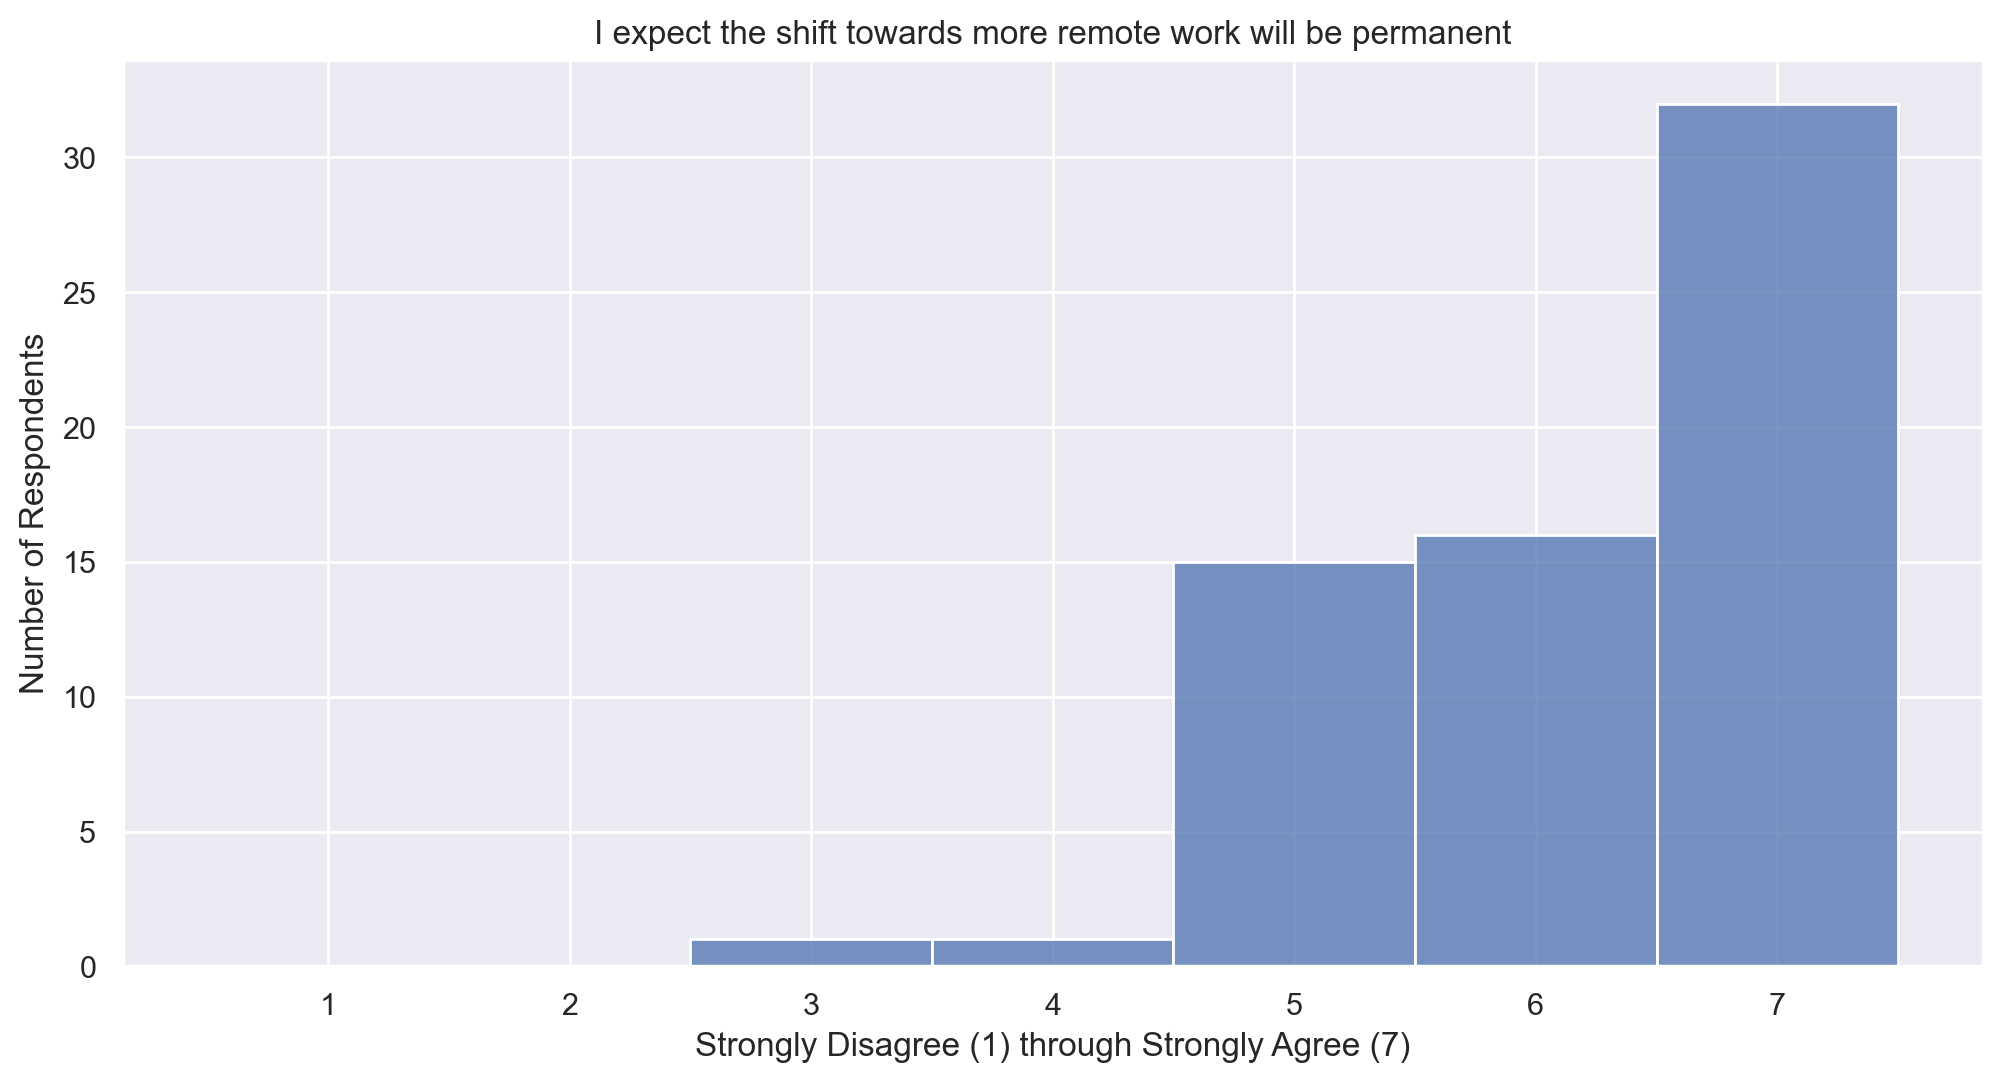

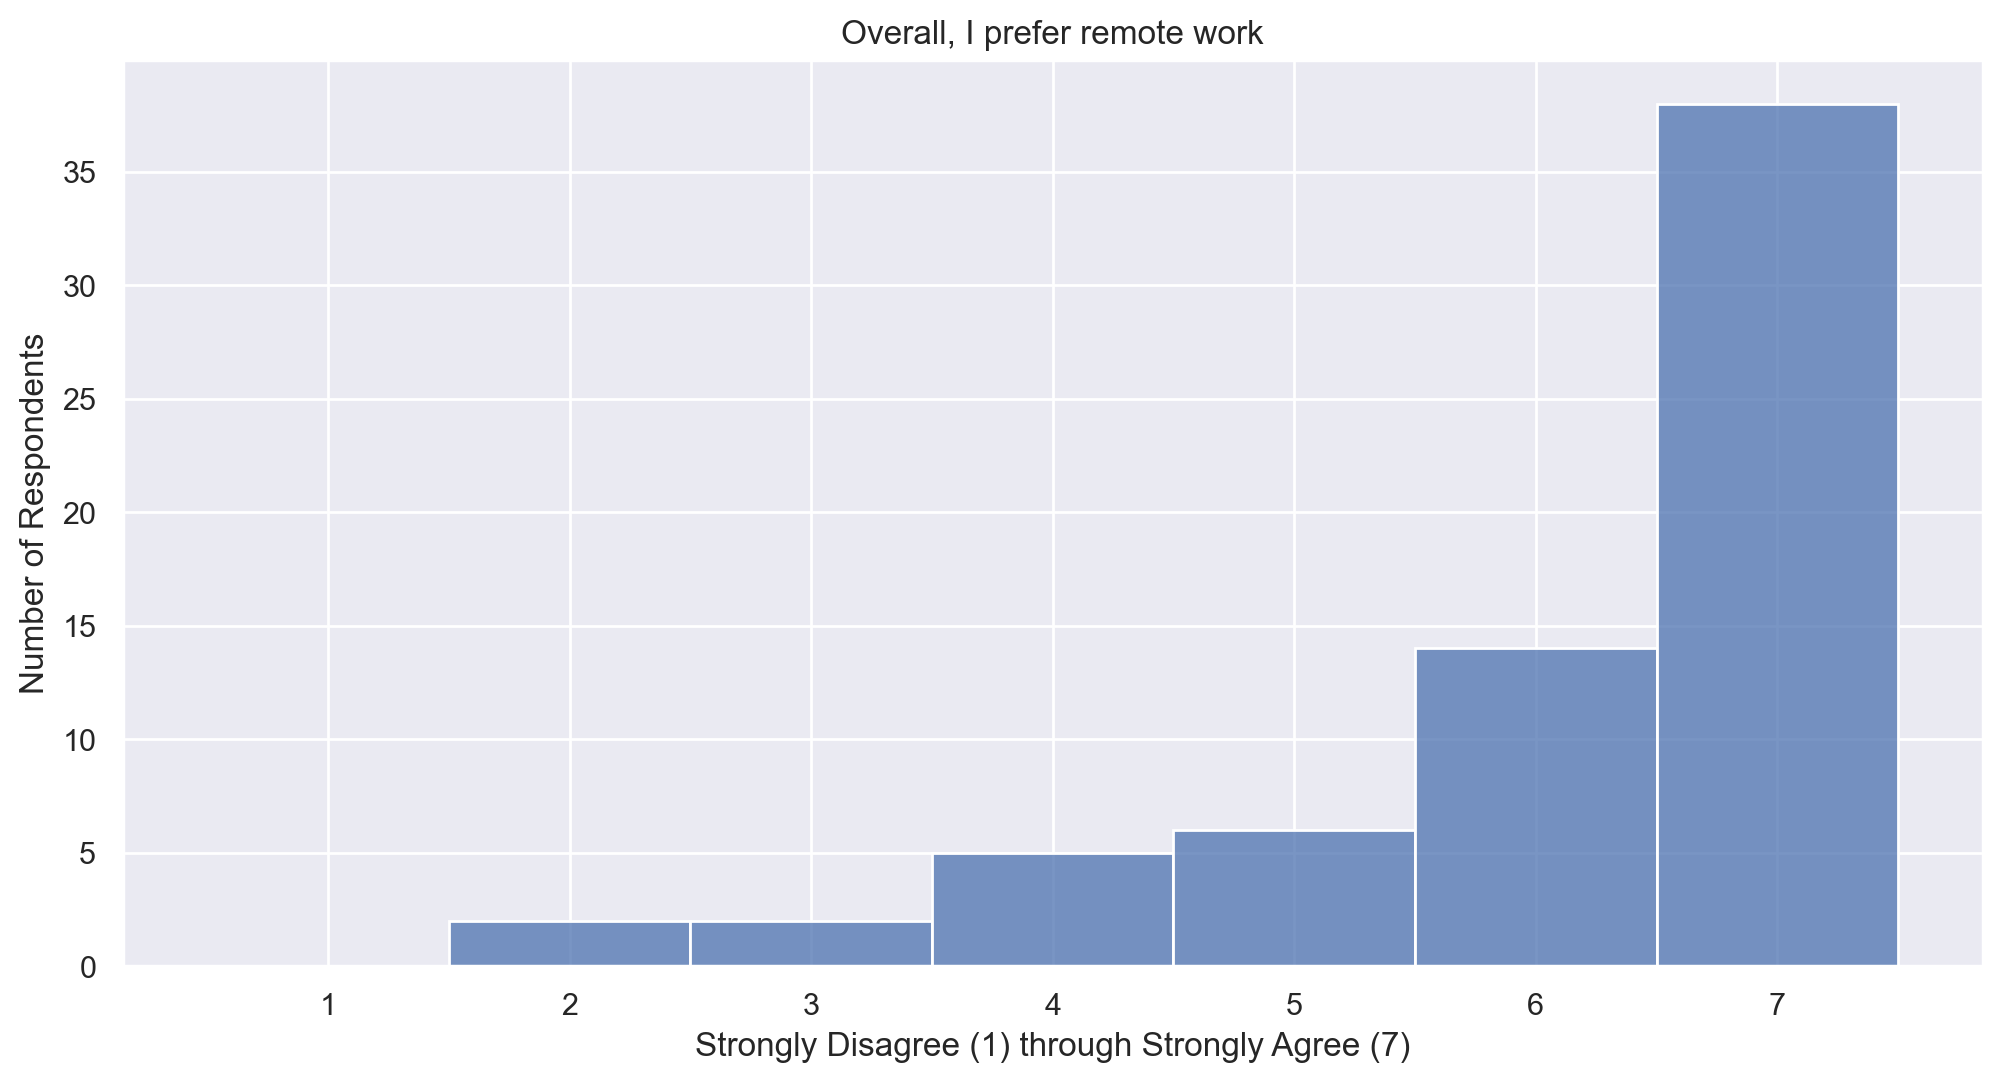

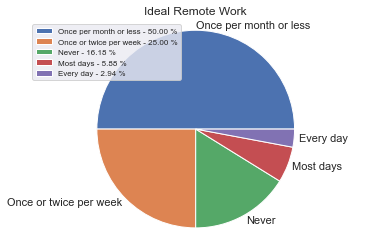

<Figure size 1200x1200 with 0 Axes>

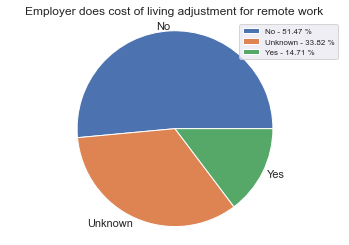

<Figure size 1200x1200 with 0 Axes>

In [45]:
remote_likert("remote", "Do You Work Remotely?", "In Person Only", "100% Remote")
mmpie(data, "remote_where", "Remote Work Location", 0, "upper right", [])
remote_likert("remote_unplug", "Remote work has made it more difficult to \"unplug\" after work")
remote_likert("remote_productive", "I am more productive when working from home")
remote_likert("remote_commute", "Avoiding the time and stress of a daily commute has been a big help")
remote_likert("remote_communicate", "Remote work has made communication and coordination with coworkers more difficult")
remote_likert("remote_distractions", "Distractions at home can be a significant problem")
remote_likert("remote_worklife", "Remote work has improved my work/life balance")
remote_likert("remote_focus", "It's more difficult to stay focused while working remotely")
remote_likert("remote_social", "I miss the in-person social connection of working at the office")
remote_likert("remote_different", "My employer treats remote and in-person workers differently")
remote_likert("remote_critical", "If my employer moved back to 100% in-person, I would strongly consider looking for a new job")
remote_likert("remote_permanent", "I expect the shift towards more remote work will be permanent")
remote_likert("remote_preferred", "Overall, I prefer remote work")

mmpie(data, "remote_ideal", "Ideal Remote Work", 0, "upper left", [])
mmpie(data, "remote_col", "Employer does cost of living adjustment for remote work", 0, "upper right", [])


# 'remote_ideal', # In your ideal job, how often would you come to the office in person?

Overall, respondents were quite satisfied with their employers responses' to the COVID-19 pandemic, with nearly half giving their employers the highest possible score (7/7), and only two respondents indicating that they were some level of dissatistifed.

# Misc

While the data from this survey is _consistent_ with a "gender gap" in wages, there are significant limitations (e.g., the small sample size) that prevent us from making statistically reliable observations on this issue with this data.

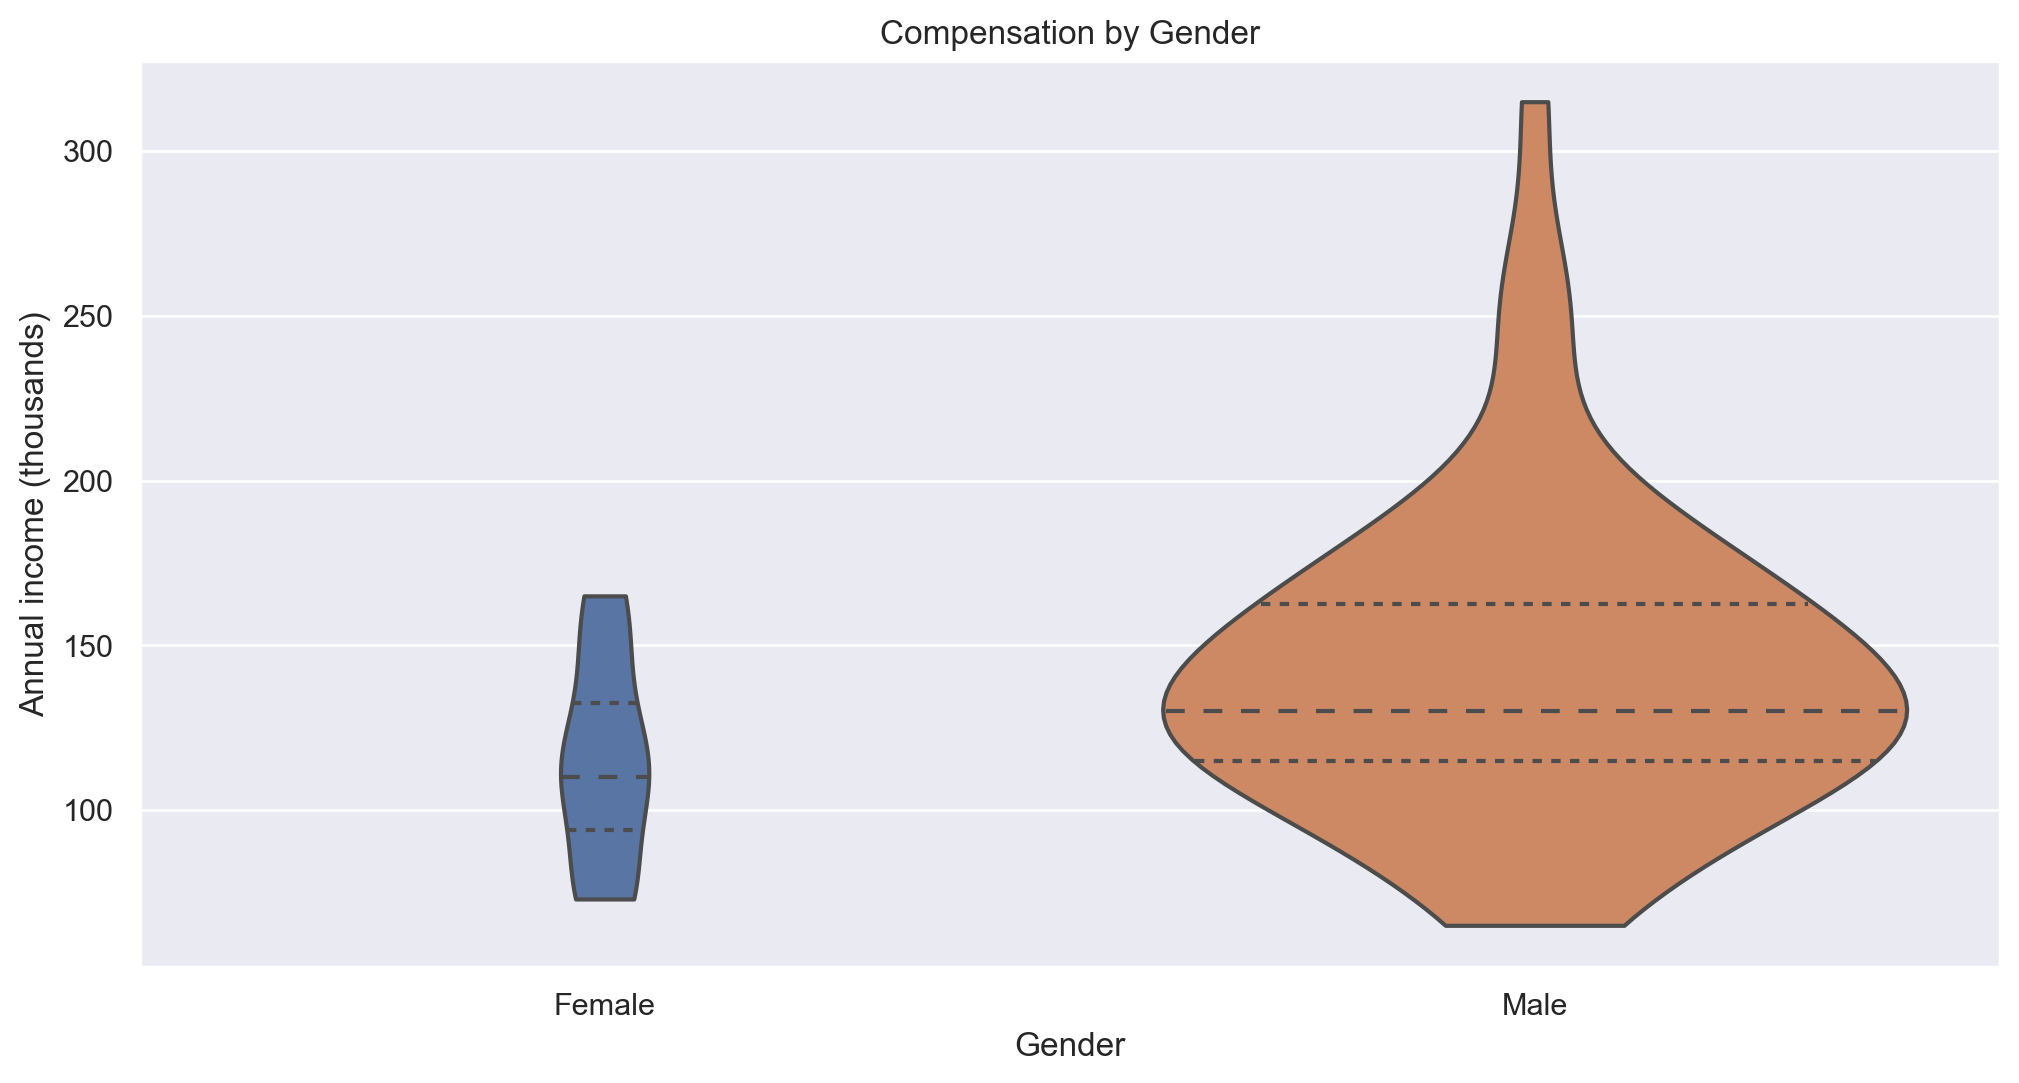

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.430
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.124
Time:                        21:56:12   Log-Likelihood:                -345.05
No. Observations:                  66   AIC:                             694.1
Df Residuals:                      64   BIC:                             698.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        114.4286     17.314      6.

In [39]:
# for privacy of single respondent
filtered = data.copy()
filtered = filtered[filtered['gender'] != "Other/Non-Binary"]
filtered['gender'] = filtered['gender'].astype('string')
filtered['gender'] = filtered['gender'].astype('category')

plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "gender",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    data=filtered  # Removed for privacy--1 response.
)
plot.set(
    xlabel="Gender",
    ylabel="Annual income (thousands)",
    title="Compensation by Gender"
)
plot.get_figure().savefig("figures/job_pay_vs_gender.svg")
plt.show()

model = sm.ols(formula="job_pay ~ gender", data=filtered)
result = model.fit()
print(result.summary())


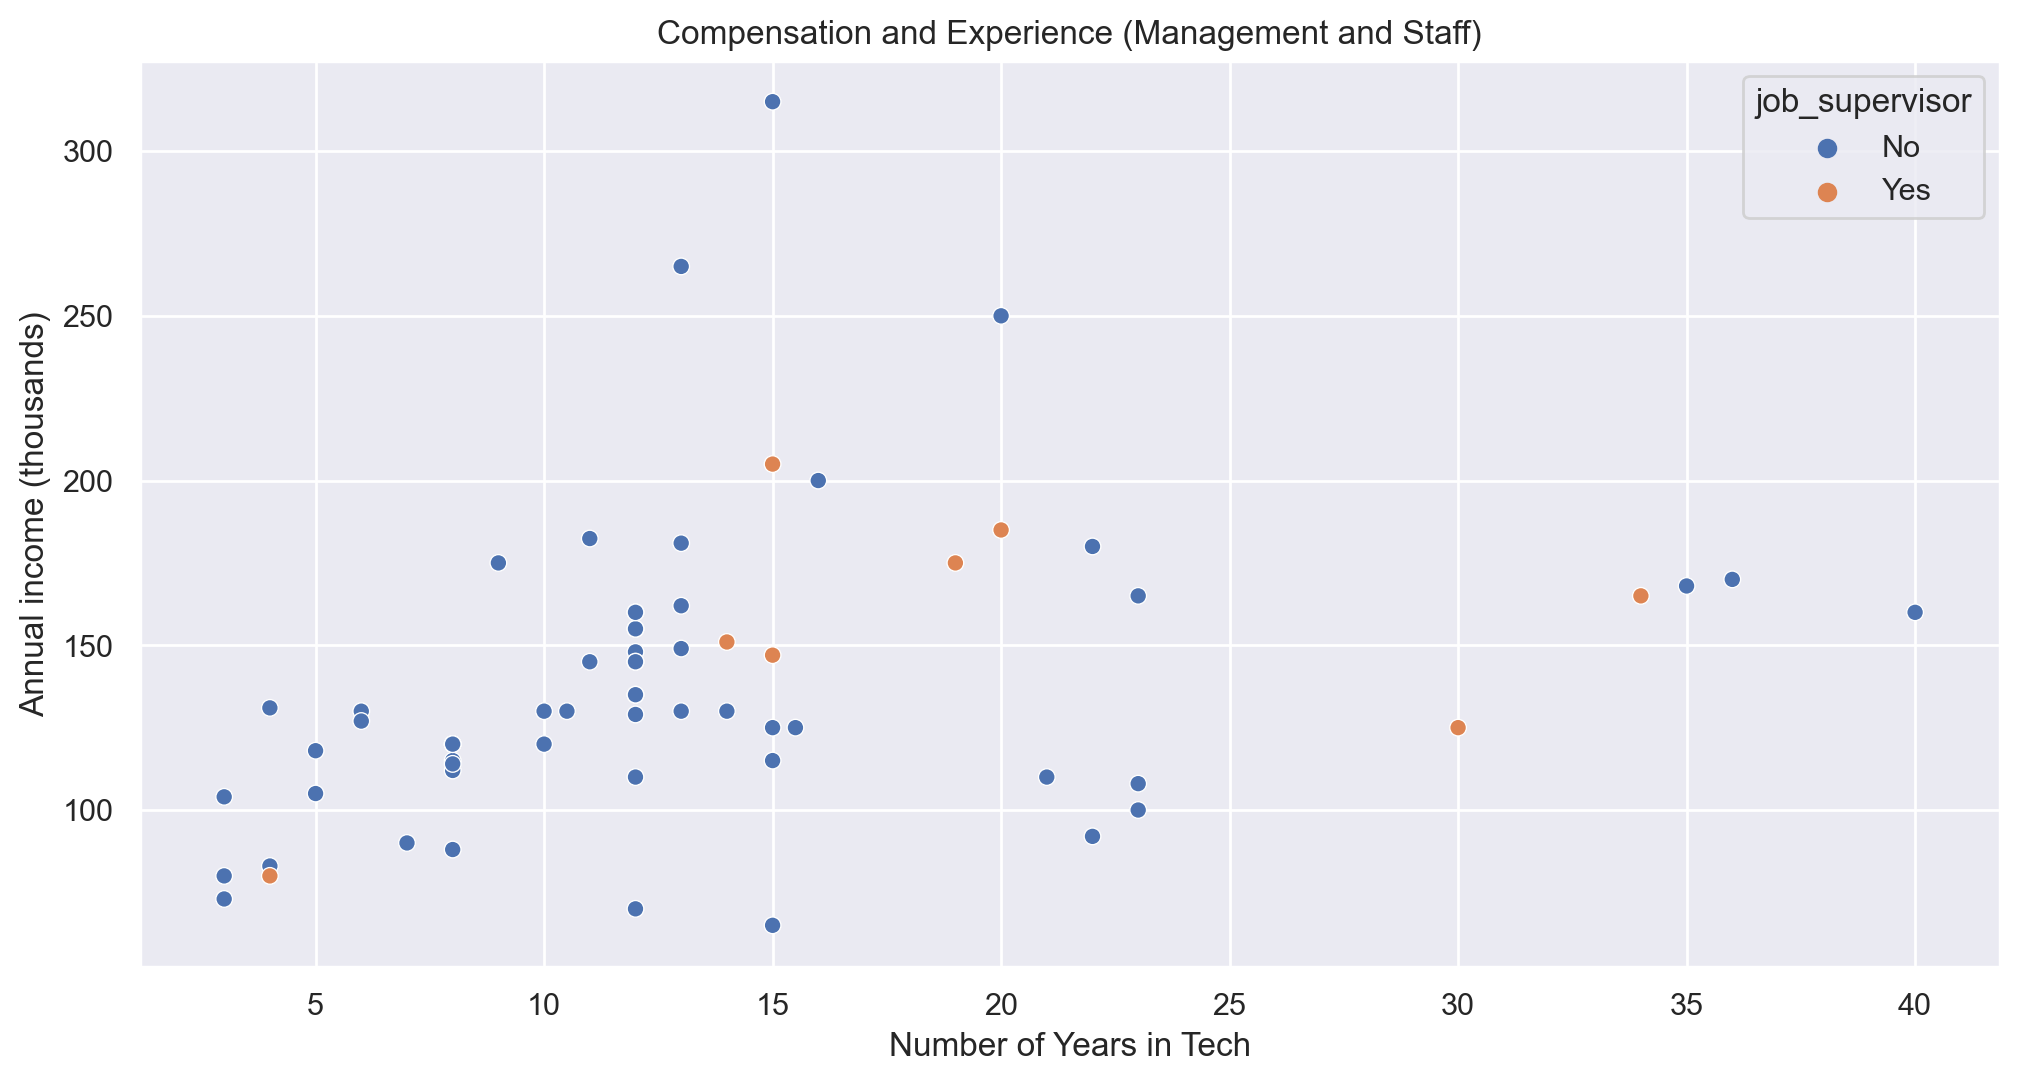

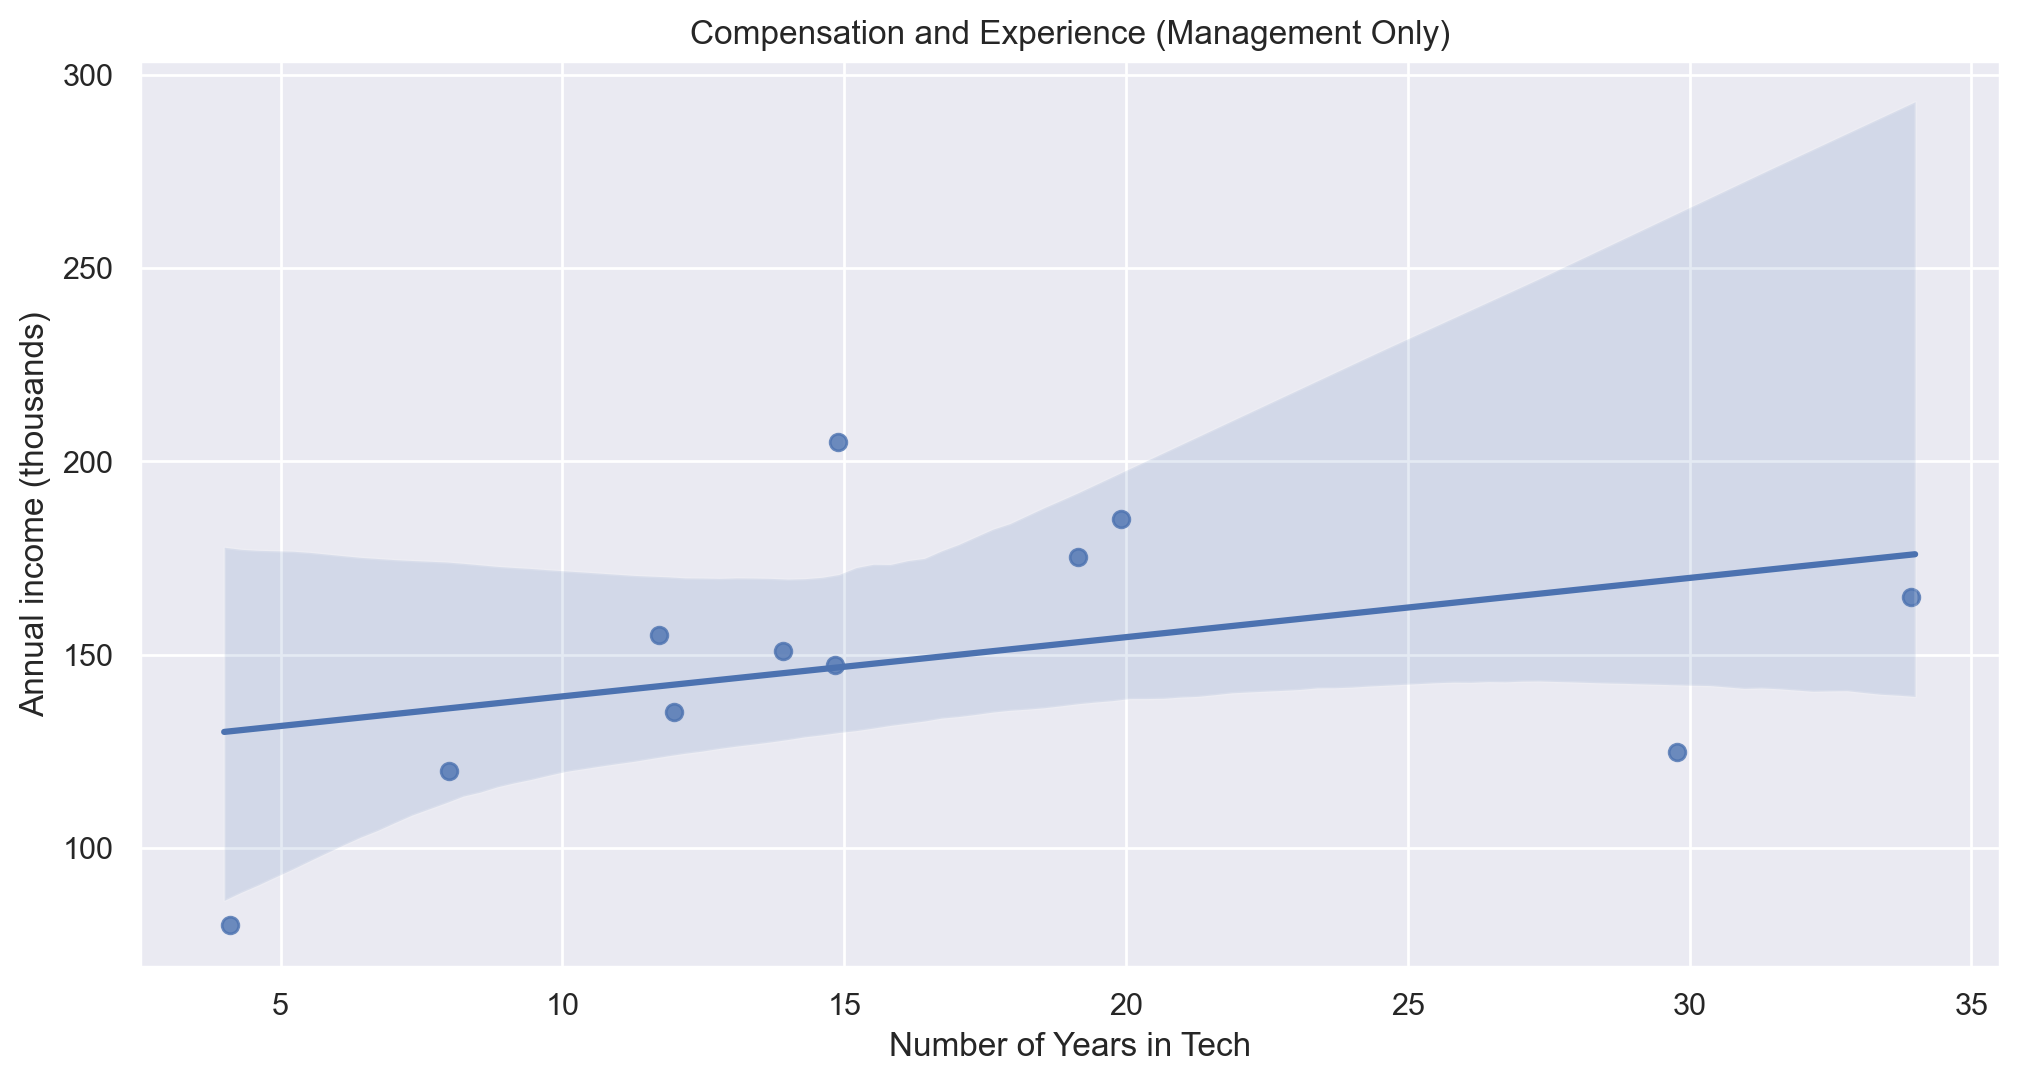

In [40]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.scatterplot(
    x = "tech_tenure",
    y = "job_pay",
    hue = "job_supervisor",
    x_jitter = .3,
    y_jitter = .3,
    data=data)
plot.set(
    xlabel="Number of Years in Tech",
    ylabel="Annual income (thousands)",
    title="Compensation and Experience (Management and Staff)"
)
plt.show()
plt.close('all')

sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.regplot(
    x = "tech_tenure",
    y = "job_pay",
    x_jitter = .3,
    y_jitter = .3,
    data=data.loc[data['job_supervisor'] == "Yes"])
plot.set(
    xlabel="Number of Years in Tech",
    ylabel="Annual income (thousands)",
    title="Compensation and Experience (Management Only)"
)
plt.show()
plt.close('all')


Below are summary statistics for the entire data set.

In [41]:
data.describe()

,org_size,job_tenure,remote,tech_tenure,tech_jobs,job_pay,job_when_negotiated,job_hours,job_vacation,side_job_pay,...,benefits_retirement_matching,benefits_tuition,benefits_vision,misc_disability,misc_foreigner,misc_lgbt,misc_none,misc_parent,job_avg_tenure,log_org_size
count,65.000000,67.000000,68.000000,66.000000,66.000000,68.000000,68.000000,68.000000,65.000000,15.000000,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,66.000000,65.000000
mean,9823.200000,3.070647,6.573529,13.621212,4.712121,139.505882,2020.794118,40.926471,20.830769,9.400000,...,0.823529,0.250000,0.882353,0.044118,0.014706,0.117647,0.352941,0.514706,3.165200,2.678357
std,35623.130951,3.256501,0.903000,8.088007,2.351858,46.129143,0.534170,3.645959,6.241417,9.424891,...,0.384054,0.436232,0.324585,0.206883,0.121268,0.324585,0.481438,0.503500,1.800569,1.142754
min,3.000000,0.000000,2.000000,3.000000,1.000000,65.000000,2018.000000,35.000000,5.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,0.477121
25%,70.000000,1.000000,6.000000,8.000000,3.000000,111.500000,2021.000000,40.000000,15.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.845098
50%,200.000000,2.500000,7.000000,12.000000,4.000000,130.000000,2021.000000,40.000000,20.000000,10.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.612500,2.301030
75%,5000.000000,4.000000,7.000000,15.000000,6.000000,160.500000,2021.000000,40.000000,25.000000,11.000000,...,1.000000,0.250000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.950000,3.698970
max,250000.000000,22.000000,7.000000,40.000000,12.000000,315.000000,2021.000000,55.000000,43.000000,30.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,5.397940
